# Assignment 2: Conditional GAN for Bird Image Generation

**Objective**: Build a conditional Generative Adversarial Network (cGAN) to generate 64x64 bird images from attribute descriptions.

**Dataset**: CUB-200-2011 (5-class subset)
- Black_footed_Albatross
- Red_faced_Cormorant
- Bobolink
- Lazuli_Bunting
- Yellow_breasted_Chat

## 1. Setup and Configuration

In [8]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GitHub_Repos/CS604-CV-Assignments/assignment2/

Mounted at /content/drive
/content/drive/MyDrive/GitHub_Repos/CS604-CV-Assignments/assignment2


### 1.1 Import Libraries

In [164]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.models import inception_v3, Inception_V3_Weights
from scipy.linalg import sqrtm
from torchvision.utils import make_grid, save_image
from PIL import Image

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

### 1.2 Reproducibility Configuration

In [66]:
SEED = 42

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')

Using device: cuda
GPU: Tesla T4
Memory: 14.74 GB


### 1.3 Hyperparameters and Paths

In [192]:
DATA_ROOT = 'CUB_200_2011'
MODEL_DIR = 'models'
OUTPUT_DIR = 'outputs'
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(MODEL_DIR, 'checkpoints'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'figures'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'generated_samples'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'evaluation_images'), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, 'figures', 'training_progress'), exist_ok=True)

TARGET_CLASSES = [
    'Black_footed_Albatross',
    'Red_faced_Cormorant',
    'Bobolink',
    'Lazuli_Bunting',
    'Yellow_breasted_Chat'
]

IMG_SIZE = 64
BATCH_SIZE = 10
LATENT_DIM = 128
NUM_EPOCHS = 1000
LR_G = 0.00012
LR_D = 0.00018
BETA1 = 0.5
BETA2 = 0.999
LAMBDA_GP = 3

## 2. Data Exploration and Analysis

### 2.1 Load Dataset Metadata

In [193]:
images_df = pd.read_csv(
    os.path.join(DATA_ROOT, 'images.txt'),
    sep=' ',
    names=['image_id', 'image_path']
)

labels_df = pd.read_csv(
    os.path.join(DATA_ROOT, 'image_class_labels.txt'),
    sep=' ',
    names=['image_id', 'class_id']
)

split_df = pd.read_csv(
    os.path.join(DATA_ROOT, 'train_test_split.txt'),
    sep=' ',
    names=['image_id', 'is_training']
)

classes_df = pd.read_csv(
    os.path.join(DATA_ROOT, 'classes.txt'),
    sep=' ',
    names=['class_id', 'class_name']
)
classes_df['class_name'] = classes_df['class_name'].str.split('.', n=1).str[1]

attributes_list = pd.read_csv(
    os.path.join(DATA_ROOT, 'attributes', 'attributes.txt'),
    sep=' ',
    names=['attribute_id', 'attribute_name']
)
attributes_list['attribute_name'] = attributes_list['attribute_name'].str.split('::', n=1).str[1]

image_attributes = pd.read_csv(
    os.path.join(DATA_ROOT, 'attributes', 'image_attribute_labels.txt'),
    sep=r'\s+',
    names=['image_id', 'attribute_id', 'is_present', 'certainty_id', 'time'],
    usecols=[0, 1, 2, 3, 4],
    on_bad_lines='skip',
    engine='python'
)

### 2.2 Filter Target Classes

In [126]:
target_class_ids = classes_df[classes_df['class_name'].isin(TARGET_CLASSES)]['class_id'].values
class_id_to_name = dict(zip(classes_df['class_id'], classes_df['class_name']))
class_name_to_id = {name: idx for idx, name in enumerate(TARGET_CLASSES)}
class_id_to_label = {cid: class_name_to_id[class_id_to_name[cid]] for cid in target_class_ids}

filtered_df = images_df.merge(labels_df, on='image_id').merge(split_df, on='image_id')
filtered_df = filtered_df[filtered_df['class_id'].isin(target_class_ids)]
filtered_df['label'] = filtered_df['class_id'].map(class_id_to_label)

train_df = filtered_df[filtered_df['is_training'] == 1].reset_index(drop=True)
test_df = filtered_df[filtered_df['is_training'] == 0].reset_index(drop=True)

print(f'Total images: {len(filtered_df)}')
print(f'Training images: {len(train_df)}')
print(f'Test images: {len(test_df)}')

Total images: 289
Training images: 150
Test images: 139


### 2.3 Class Distribution

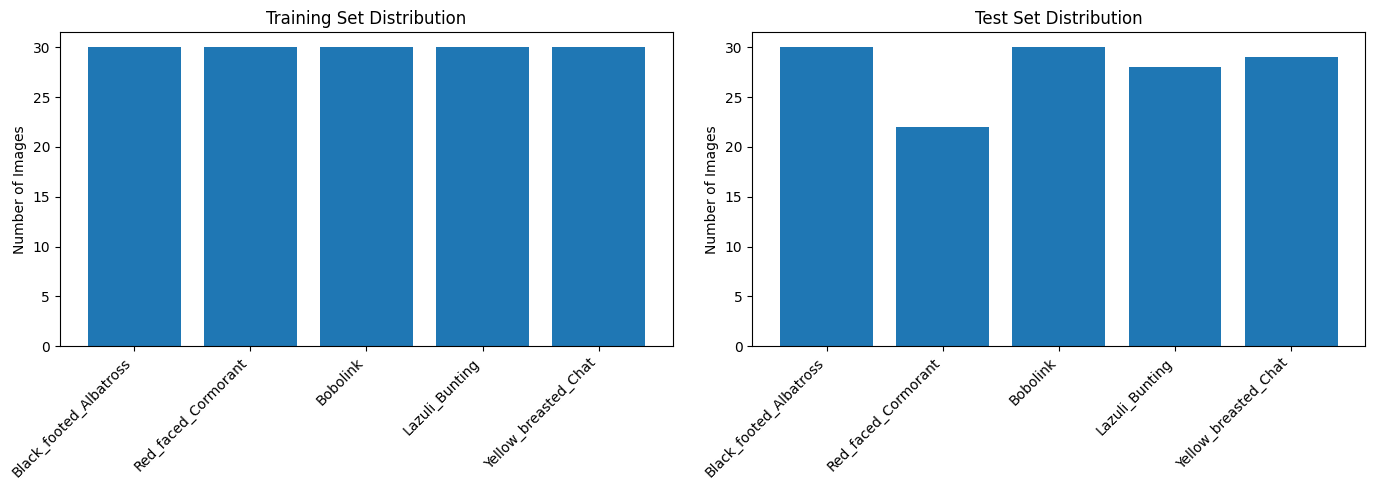

In [194]:
train_class_counts = train_df['label'].value_counts().sort_index()
test_class_counts = test_df['label'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].bar(range(len(TARGET_CLASSES)), train_class_counts.values)
axes[0].set_xticks(range(len(TARGET_CLASSES)))
axes[0].set_xticklabels(TARGET_CLASSES, rotation=45, ha='right')
axes[0].set_title('Training Set Distribution')
axes[0].set_ylabel('Number of Images')

axes[1].bar(range(len(TARGET_CLASSES)), test_class_counts.values)
axes[1].set_xticks(range(len(TARGET_CLASSES)))
axes[1].set_xticklabels(TARGET_CLASSES, rotation=45, ha='right')
axes[1].set_title('Test Set Distribution')
axes[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

### 2.4 Attribute Statistics

In [195]:
print(f'Total number of attributes: {len(attributes_list)}')
print(f'Total attribute annotations: {len(image_attributes)}')
print(f'\nCertainty levels:')
print(image_attributes['certainty_id'].value_counts().sort_index())
print(f'\nAttribute presence:')
print(image_attributes['is_present'].value_counts())

Total number of attributes: 312
Total attribute annotations: 3677856

Certainty levels:
certainty_id
1     394906
2     228021
3    1021155
4    2033774
Name: count, dtype: int64

Attribute presence:
is_present
0    3306809
1     371047
Name: count, dtype: int64


## 3. Part 1: Attribute Data Processing

### Data Pipeline

- Used MTurk annotations from `image_attribute_labels.txt`
- Applied **majority voting**: attribute = 1 if >50% workers say "present"
- Processed all 312 attributes per image

### Attribute Vector Format

- **Dimension**: 312
- **Type**: Binary vector (0 or 1)
- **Sparsity**: 90.40%

### Processing Method

- Collected multiple worker votes per attribute
- Applied majority voting rule
- Stored in dictionary: `image_id -> attribute_vector`

### 3.1 Build Attribute Vectors

In [196]:
def build_attribute_vector(image_id, attr_df, num_attributes=312):
    img_attrs = attr_df[attr_df['image_id'] == image_id]

    attr_votes = {}
    for _, row in img_attrs.iterrows():
        attr_idx = int(row['attribute_id']) - 1
        if attr_idx not in attr_votes:
            attr_votes[attr_idx] = []
        attr_votes[attr_idx].append(int(row['is_present']))

    attr_vector = np.zeros(num_attributes)
    for attr_idx, votes in attr_votes.items():
        if len(votes) > 0:
            attr_vector[attr_idx] = 1.0 if sum(votes) > len(votes) / 2 else 0.0

    return attr_vector

train_attributes = {}
for img_id in train_df['image_id']:
    train_attributes[img_id] = build_attribute_vector(img_id, image_attributes)

test_attributes = {}
for img_id in test_df['image_id']:
    test_attributes[img_id] = build_attribute_vector(img_id, image_attributes)

print(f'Built attribute vectors for {len(train_attributes)} training images')
print(f'Built attribute vectors for {len(test_attributes)} test images')
print(f'Attribute vector dimension: {len(train_attributes[train_df.iloc[0]["image_id"]])}')

Built attribute vectors for 150 training images
Built attribute vectors for 139 test images
Attribute vector dimension: 312


### 3.2 Attribute Vector Analysis

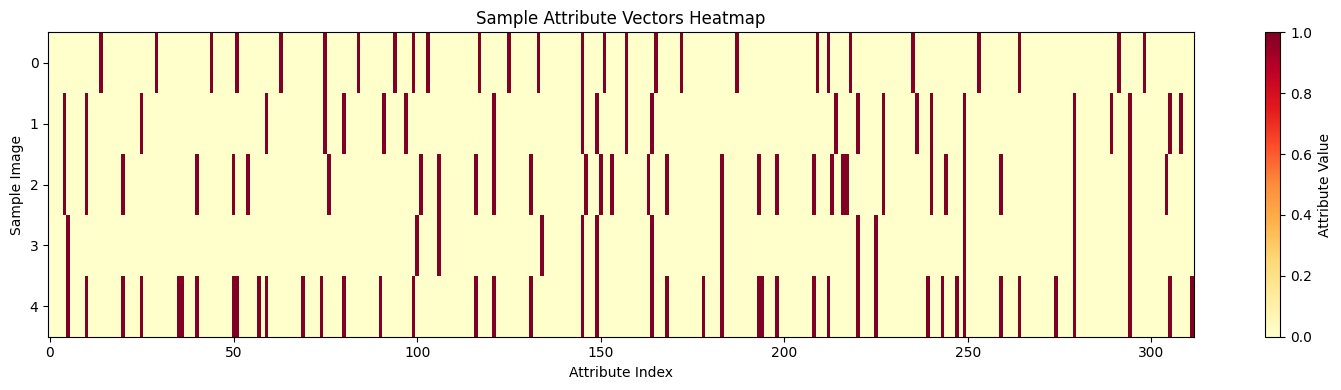

Attribute vector sparsity: 90.40%
Average non-zero attributes per image: 29.9


In [197]:
sample_vectors = np.array([train_attributes[img_id] for img_id in list(train_attributes.keys())[:5]])

plt.figure(figsize=(15, 4))
plt.imshow(sample_vectors, aspect='auto', cmap='YlOrRd')
plt.colorbar(label='Attribute Value')
plt.xlabel('Attribute Index')
plt.ylabel('Sample Image')
plt.title('Sample Attribute Vectors Heatmap')
plt.tight_layout()
plt.show()

all_train_vectors = np.array(list(train_attributes.values()))
attr_sparsity = (all_train_vectors == 0).sum() / all_train_vectors.size
print(f'Attribute vector sparsity: {attr_sparsity:.2%}')
print(f'Average non-zero attributes per image: {(all_train_vectors > 0).sum(axis=1).mean():.1f}')

### 3.3 Dataset Class

In [198]:
class BirdAttributeDataset(Dataset):
    def __init__(self, df, attributes_dict, data_root, transform=None):
        self.df = df
        self.attributes_dict = attributes_dict
        self.data_root = data_root
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.data_root, 'images', row['image_path'])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        attr_vector = torch.FloatTensor(self.attributes_dict[row['image_id']])
        label = row['label']

        return image, attr_vector, label

### 3.4 Data Transforms and Loaders

In [199]:
train_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = BirdAttributeDataset(train_df, train_attributes, DATA_ROOT, transform=train_transform)
test_dataset = BirdAttributeDataset(test_df, test_attributes, DATA_ROOT, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f'Training batches: {len(train_loader)}')
print(f'Test batches: {len(test_loader)}')

Training batches: 15
Test batches: 14


### 3.5 Visualize Sample Data

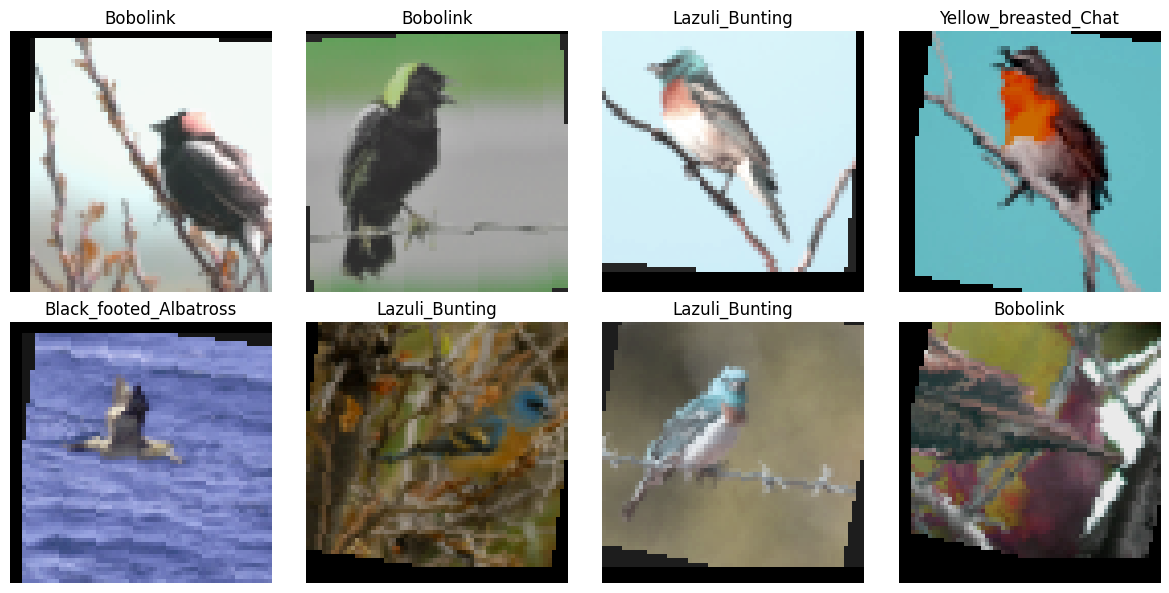

In [200]:
sample_images, sample_attrs, sample_labels = next(iter(train_loader))

fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i in range(8):
    ax = axes[i // 4, i % 4]
    img = sample_images[i].permute(1, 2, 0).numpy()
    img = img * 0.5 + 0.5
    img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(TARGET_CLASSES[sample_labels[i]])
    ax.axis('off')
plt.tight_layout()
plt.show()

### Generator

- **Input**: Noise (128-dim) + Attributes (312-dim) = 440-dim
- **Structure**: FC layer -> 4 ConvTranspose2d blocks
- **Output**: 3x64x64 RGB image
- **Upsampling**: 4x4 -> 8x8 -> 16x16 -> 32x32 -> 64x64
- **Activation**: ReLU + BatchNorm, final Tanh

### Discriminator

- **Input**: Image (3x64x64) + Attributes (312-dim)
- **Structure**: Attribute projection + 5 Conv2d blocks
- **Output**: Single probability (real/fake)
- **Downsampling**: 64x64 -> 32x32 -> 16x16 -> 8x8 -> 4x4 -> 1x1
- **Activation**: LeakyReLU + BatchNorm, final Sigmoid

### Loss Functions

- **Base**: Binary Cross-Entropy (BCE)
- **Label smoothing**: Real=0.9, Fake=0.1
- **Gradient Penalty**: lambda = 3 (WGAN-GP style)

### Training

- **Epochs**: 1000, Batch size: 10
- **Learning rates**: G=0.00012, D=0.00018
- **Optimizer**: Adam (b1=0.5, b2=0.999)
- **Strategy**: 3 generator updates per 1 discriminator update
- **Scheduler**: CosineAnnealingLR

### 4.1 Generator Architecture

In [201]:
class Generator(nn.Module):
    def __init__(self, noise_dim=128, attr_dim=312, ngf=32, img_channels=3):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.attr_dim = attr_dim

        self.fc = nn.Sequential(
            nn.Linear(noise_dim + attr_dim, 1024 * 4 * 4),
            nn.BatchNorm1d(1024 * 4 * 4),
            nn.ReLU(True)
        )

        self.conv_blocks = nn.Sequential(
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),

            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),

            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            nn.ConvTranspose2d(128, img_channels, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, noise, attributes):
        x = torch.cat([noise, attributes], dim=1)
        x = self.fc(x)
        x = x.view(x.size(0), 1024, 4, 4)
        x = self.conv_blocks(x)
        return x

### 4.2 Discriminator Architecture

In [202]:
class Discriminator(nn.Module):
    def __init__(self, attr_dim=312, ndf=64):
        super(Discriminator, self).__init__()
        self.attr_dim = attr_dim

        self.attr_projection = nn.Sequential(
            nn.Linear(attr_dim, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 64 * 64),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.main = nn.Sequential(
            nn.Conv2d(4, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, image, attributes):
        attr_map = self.attr_projection(attributes)
        attr_map = attr_map.view(attr_map.size(0), 1, 64, 64)
        x = torch.cat([image, attr_map], dim=1)
        x = self.main(x)
        return x.view(-1, 1).squeeze(1)

### 4.3 Initialize Models

In [203]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

generator = Generator(noise_dim=LATENT_DIM, attr_dim=312, ngf=32).to(device)
discriminator = Discriminator(attr_dim=312, ndf=32).to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)

print(f'Generator parameters: {sum(p.numel() for p in generator.parameters()):,}')
print(f'Discriminator parameters: {sum(p.numel() for p in discriminator.parameters()):,}')

Generator parameters: 18,276,096
Discriminator parameters: 1,336,576


### 4.4 Loss Functions and Optimizers

In [204]:
criterion = nn.BCELoss()

optimizer_G = optim.Adam(generator.parameters(), lr=LR_G, betas=(BETA1, BETA2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=LR_D, betas=(BETA1, BETA2))

scheduler_G = optim.lr_scheduler.CosineAnnealingLR(optimizer_G, T_max=NUM_EPOCHS, eta_min=5e-7)
scheduler_D = optim.lr_scheduler.CosineAnnealingLR(optimizer_D, T_max=NUM_EPOCHS, eta_min=5e-7)

In [205]:
def compute_gradient_penalty(discriminator, real_imgs, fake_imgs, attributes, device):
    batch_size = real_imgs.size(0)
    alpha = torch.rand(batch_size, 1, 1, 1, device=device)

    interpolates = (alpha * real_imgs + (1 - alpha) * fake_imgs).requires_grad_(True)

    d_interpolates = discriminator(interpolates, attributes)

    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(d_interpolates),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(batch_size, -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    return gradient_penalty

### 4.5 FID Score Calculation

In [206]:
def get_inception_features(images, inception_model, device):
    inception_model.eval()
    with torch.no_grad():
        if images.size(2) != 299 or images.size(3) != 299:
            images = nn.functional.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
        features = inception_model(images)
    return features.cpu().numpy()

def calculate_fid(real_features, fake_features):
    mu_real = np.mean(real_features, axis=0)
    mu_fake = np.mean(fake_features, axis=0)

    sigma_real = np.cov(real_features, rowvar=False)
    sigma_fake = np.cov(fake_features, rowvar=False)

    diff = mu_real - mu_fake
    covmean = sqrtm(sigma_real.dot(sigma_fake))

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = diff.dot(diff) + np.trace(sigma_real + sigma_fake - 2 * covmean)
    return fid

def compute_fid_score(generator, train_loader, num_samples, latent_dim, device):
    inception_model = inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1, transform_input=False)
    inception_model.fc = nn.Identity()
    inception_model = inception_model.to(device)
    inception_model.eval()

    real_features = []
    fake_features = []

    generator.eval()
    with torch.no_grad():
        samples_collected = 0
        for real_imgs, attributes, _ in train_loader:
            if samples_collected >= num_samples:
                break

            batch_size = min(real_imgs.size(0), num_samples - samples_collected)
            real_imgs = real_imgs[:batch_size].to(device)
            attributes = attributes[:batch_size].to(device)

            real_feat = get_inception_features(real_imgs, inception_model, device)
            real_features.append(real_feat)

            noise = torch.randn(batch_size, latent_dim, device=device)
            fake_imgs = generator(noise, attributes)
            fake_feat = get_inception_features(fake_imgs, inception_model, device)
            fake_features.append(fake_feat)

            samples_collected += batch_size

    real_features = np.concatenate(real_features, axis=0)
    fake_features = np.concatenate(fake_features, axis=0)

    fid = calculate_fid(real_features, fake_features)
    return fid

### 4.5 Training Loop

In [207]:
def train_gan(generator, discriminator, train_loader, num_epochs, device):
    g_losses = []
    d_losses = []
    fid_scores = []
    best_fid = float('inf')
    best_epoch = 0
    best_generator_state = None
    best_discriminator_state = None
    current_fid = None

    fixed_noise = torch.randn(10, LATENT_DIM, device=device)
    sample_batch = next(iter(train_loader))
    fixed_attrs = sample_batch[1][:10].to(device)

    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()

        epoch_g_loss = 0
        epoch_d_loss = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for real_imgs, attributes, _ in pbar:
            batch_size = real_imgs.size(0)
            real_imgs = real_imgs.to(device)
            attributes = attributes.to(device)

            real_labels = torch.ones(batch_size, device=device) * 0.9
            fake_labels = torch.zeros(batch_size, device=device) + 0.1

            optimizer_D.zero_grad()

            real_output = discriminator(real_imgs, attributes)
            d_loss_real = criterion(real_output, real_labels)

            noise = torch.randn(batch_size, LATENT_DIM, device=device)
            fake_imgs = generator(noise, attributes)
            fake_output = discriminator(fake_imgs.detach(), attributes)
            d_loss_fake = criterion(fake_output, fake_labels)

            d_loss = d_loss_real + d_loss_fake

            gp = compute_gradient_penalty(discriminator, real_imgs, fake_imgs, attributes, device)
            d_loss_total = d_loss + LAMBDA_GP * gp

            d_loss_total.backward()
            torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1.0)
            optimizer_D.step()

            g_loss_accum = 0
            for _ in range(3):
                optimizer_G.zero_grad()

                noise = torch.randn(batch_size, LATENT_DIM, device=device)
                fake_imgs = generator(noise, attributes)
                fake_output = discriminator(fake_imgs, attributes)
                g_loss = criterion(fake_output, torch.ones(batch_size, device=device))

                g_loss.backward()
                torch.nn.utils.clip_grad_norm_(generator.parameters(), 1.0)
                optimizer_G.step()

                g_loss_accum += g_loss.item()

            epoch_g_loss += g_loss_accum / 3
            epoch_d_loss += d_loss.item()

            postfix_dict = {
                'D_loss': f'{d_loss.item():.4f}',
                'G_loss': f'{g_loss_accum/3:.4f}'
            }
            if current_fid is not None:
                postfix_dict['FID'] = f'{current_fid:.2f}'
            pbar.set_postfix(postfix_dict)

        avg_g_loss = epoch_g_loss / len(train_loader)
        avg_d_loss = epoch_d_loss / len(train_loader)
        g_losses.append(avg_g_loss)
        d_losses.append(avg_d_loss)

        scheduler_G.step()
        scheduler_D.step()

        if (epoch + 1) % 10 == 0:
            generator.eval()
            with torch.no_grad():
                fake_samples = generator(fixed_noise, fixed_attrs)
                save_image(
                    fake_samples,
                    os.path.join(OUTPUT_DIR, 'figures', 'training_progress', f'epoch_{epoch+1}.png'),
                    nrow=5,
                    normalize=True
                )

            print(f'\nCalculating FID score...')
            fid = compute_fid_score(generator, train_loader, num_samples=150, latent_dim=LATENT_DIM, device=device)
            fid_scores.append(fid)
            current_fid = fid

            print(f'Epoch [{epoch+1}/{num_epochs}] - D_loss: {avg_d_loss:.4f}, G_loss: {avg_g_loss:.4f}, FID: {fid:.2f}')

            if fid < best_fid:
                best_fid = fid
                best_epoch = epoch + 1
                best_generator_state = {k: v.cpu().clone() for k, v in generator.state_dict().items()}
                best_discriminator_state = {k: v.cpu().clone() for k, v in discriminator.state_dict().items()}

                torch.save({
                    'epoch': epoch,
                    'generator_state_dict': best_generator_state,
                    'fid': fid,
                }, os.path.join(MODEL_DIR, 'generator_best.pt'))

                torch.save({
                    'epoch': epoch,
                    'discriminator_state_dict': best_discriminator_state,
                    'fid': fid,
                }, os.path.join(MODEL_DIR, 'discriminator_best.pt'))

                print(f'New best FID: {fid:.2f} at epoch {epoch+1}')

            torch.save({
                'epoch': epoch,
                'generator_state_dict': generator.state_dict(),
                'discriminator_state_dict': discriminator.state_dict(),
                'optimizer_G_state_dict': optimizer_G.state_dict(),
                'optimizer_D_state_dict': optimizer_D.state_dict(),
            }, os.path.join(MODEL_DIR, 'checkpoints', f'checkpoint_epoch_{epoch+1}.pt'))

        else:
            fid_display = f', FID: {current_fid:.2f}' if current_fid is not None else ''
            print(f'Epoch [{epoch+1}/{num_epochs}] - D_loss: {avg_d_loss:.4f}, G_loss: {avg_g_loss:.4f}{fid_display}')

    if best_generator_state is not None:
        print(f'\nLoading best model (Epoch {best_epoch}, FID: {best_fid:.2f})...')
        generator.load_state_dict({k: v.to(device) for k, v in best_generator_state.items()})
        discriminator.load_state_dict({k: v.to(device) for k, v in best_discriminator_state.items()})

    return g_losses, d_losses, fid_scores, best_fid, best_epoch

### 4.6 Train the Model

In [208]:
g_losses, d_losses, fid_scores, best_fid, best_epoch = train_gan(
    generator, discriminator, train_loader, NUM_EPOCHS, device
)

Epoch 1/1000: 100%|██████████| 15/15 [00:02<00:00,  7.28it/s, D_loss=6.0370, G_loss=0.2698]


Epoch [1/1000] - D_loss: 5.5490, G_loss: 0.1518


Epoch 2/1000: 100%|██████████| 15/15 [00:01<00:00,  7.59it/s, D_loss=6.3234, G_loss=0.3636]


Epoch [2/1000] - D_loss: 6.7183, G_loss: 0.2508


Epoch 3/1000: 100%|██████████| 15/15 [00:02<00:00,  7.41it/s, D_loss=4.4545, G_loss=0.9694]


Epoch [3/1000] - D_loss: 6.0240, G_loss: 0.5511


Epoch 4/1000: 100%|██████████| 15/15 [00:01<00:00,  7.52it/s, D_loss=2.2592, G_loss=2.9243]


Epoch [4/1000] - D_loss: 3.6354, G_loss: 1.7345


Epoch 5/1000: 100%|██████████| 15/15 [00:01<00:00,  7.52it/s, D_loss=2.5148, G_loss=3.5048]


Epoch [5/1000] - D_loss: 2.5043, G_loss: 2.4898


Epoch 6/1000: 100%|██████████| 15/15 [00:01<00:00,  7.52it/s, D_loss=1.4313, G_loss=4.1034]


Epoch [6/1000] - D_loss: 2.6116, G_loss: 2.0770


Epoch 7/1000: 100%|██████████| 15/15 [00:02<00:00,  7.24it/s, D_loss=1.8748, G_loss=1.5036]


Epoch [7/1000] - D_loss: 2.0142, G_loss: 1.8685


Epoch 8/1000: 100%|██████████| 15/15 [00:02<00:00,  7.42it/s, D_loss=2.3626, G_loss=0.6749]


Epoch [8/1000] - D_loss: 1.8420, G_loss: 1.6920


Epoch 9/1000: 100%|██████████| 15/15 [00:02<00:00,  7.22it/s, D_loss=2.0085, G_loss=0.6069]


Epoch [9/1000] - D_loss: 2.5192, G_loss: 0.5274


Epoch 10/1000: 100%|██████████| 15/15 [00:02<00:00,  7.44it/s, D_loss=2.3002, G_loss=0.5656]



Calculating FID score...
Epoch [10/1000] - D_loss: 2.1196, G_loss: 0.6821, FID: 329.68
New best FID: 329.68 at epoch 10


Epoch 11/1000: 100%|██████████| 15/15 [00:02<00:00,  5.61it/s, D_loss=2.9904, G_loss=0.5439, FID=329.68]


Epoch [11/1000] - D_loss: 2.2226, G_loss: 0.6540, FID: 329.68


Epoch 12/1000: 100%|██████████| 15/15 [00:02<00:00,  7.43it/s, D_loss=2.6223, G_loss=0.5401, FID=329.68]


Epoch [12/1000] - D_loss: 2.2123, G_loss: 0.6389, FID: 329.68


Epoch 13/1000: 100%|██████████| 15/15 [00:02<00:00,  7.45it/s, D_loss=2.1674, G_loss=0.5232, FID=329.68]


Epoch [13/1000] - D_loss: 2.1574, G_loss: 0.6210, FID: 329.68


Epoch 14/1000: 100%|██████████| 15/15 [00:02<00:00,  7.46it/s, D_loss=1.8465, G_loss=0.6840, FID=329.68]


Epoch [14/1000] - D_loss: 1.9298, G_loss: 0.6618, FID: 329.68


Epoch 15/1000: 100%|██████████| 15/15 [00:07<00:00,  1.90it/s, D_loss=2.1069, G_loss=0.5291, FID=329.68]


Epoch [15/1000] - D_loss: 1.8857, G_loss: 0.6607, FID: 329.68


Epoch 16/1000: 100%|██████████| 15/15 [00:02<00:00,  7.27it/s, D_loss=1.6503, G_loss=0.9714, FID=329.68]


Epoch [16/1000] - D_loss: 1.8648, G_loss: 0.7406, FID: 329.68


Epoch 17/1000: 100%|██████████| 15/15 [00:02<00:00,  7.40it/s, D_loss=2.0630, G_loss=0.8671, FID=329.68]


Epoch [17/1000] - D_loss: 1.8267, G_loss: 0.7893, FID: 329.68


Epoch 18/1000: 100%|██████████| 15/15 [00:02<00:00,  7.46it/s, D_loss=1.5327, G_loss=0.7839, FID=329.68]


Epoch [18/1000] - D_loss: 1.7420, G_loss: 0.7924, FID: 329.68


Epoch 19/1000: 100%|██████████| 15/15 [00:02<00:00,  7.39it/s, D_loss=1.8938, G_loss=0.5646, FID=329.68]


Epoch [19/1000] - D_loss: 1.7696, G_loss: 0.6300, FID: 329.68


Epoch 20/1000: 100%|██████████| 15/15 [00:02<00:00,  7.32it/s, D_loss=1.7607, G_loss=0.7690, FID=329.68]



Calculating FID score...
Epoch [20/1000] - D_loss: 1.8443, G_loss: 0.6965, FID: 318.10
New best FID: 318.10 at epoch 20


Epoch 21/1000: 100%|██████████| 15/15 [00:02<00:00,  5.25it/s, D_loss=1.6159, G_loss=0.5015, FID=318.10]


Epoch [21/1000] - D_loss: 1.7419, G_loss: 0.6614, FID: 318.10


Epoch 22/1000: 100%|██████████| 15/15 [00:02<00:00,  7.43it/s, D_loss=1.4659, G_loss=1.0041, FID=318.10]


Epoch [22/1000] - D_loss: 1.7794, G_loss: 0.6400, FID: 318.10


Epoch 23/1000: 100%|██████████| 15/15 [00:02<00:00,  7.43it/s, D_loss=1.5644, G_loss=0.7915, FID=318.10]


Epoch [23/1000] - D_loss: 1.6907, G_loss: 0.6256, FID: 318.10


Epoch 24/1000: 100%|██████████| 15/15 [00:02<00:00,  7.40it/s, D_loss=2.3833, G_loss=0.3944, FID=318.10]


Epoch [24/1000] - D_loss: 1.7521, G_loss: 0.6200, FID: 318.10


Epoch 25/1000: 100%|██████████| 15/15 [00:07<00:00,  1.91it/s, D_loss=1.6602, G_loss=0.7591, FID=318.10]


Epoch [25/1000] - D_loss: 1.6911, G_loss: 0.6642, FID: 318.10


Epoch 26/1000: 100%|██████████| 15/15 [00:02<00:00,  7.17it/s, D_loss=1.7430, G_loss=0.6020, FID=318.10]


Epoch [26/1000] - D_loss: 1.6108, G_loss: 0.7039, FID: 318.10


Epoch 27/1000: 100%|██████████| 15/15 [00:02<00:00,  7.29it/s, D_loss=1.5883, G_loss=0.6124, FID=318.10]


Epoch [27/1000] - D_loss: 1.6951, G_loss: 0.6955, FID: 318.10


Epoch 28/1000: 100%|██████████| 15/15 [00:02<00:00,  7.36it/s, D_loss=1.7690, G_loss=0.7497, FID=318.10]


Epoch [28/1000] - D_loss: 1.6606, G_loss: 0.7087, FID: 318.10


Epoch 29/1000: 100%|██████████| 15/15 [00:02<00:00,  7.23it/s, D_loss=1.6833, G_loss=0.5683, FID=318.10]


Epoch [29/1000] - D_loss: 1.6884, G_loss: 0.6262, FID: 318.10


Epoch 30/1000: 100%|██████████| 15/15 [00:02<00:00,  7.37it/s, D_loss=1.9052, G_loss=0.5665, FID=318.10]



Calculating FID score...
Epoch [30/1000] - D_loss: 1.7032, G_loss: 0.6725, FID: 311.90
New best FID: 311.90 at epoch 30


Epoch 31/1000: 100%|██████████| 15/15 [00:02<00:00,  6.36it/s, D_loss=1.6198, G_loss=0.7429, FID=311.90]


Epoch [31/1000] - D_loss: 1.6929, G_loss: 0.6535, FID: 311.90


Epoch 32/1000: 100%|██████████| 15/15 [00:01<00:00,  7.50it/s, D_loss=1.5993, G_loss=0.5966, FID=311.90]


Epoch [32/1000] - D_loss: 1.7053, G_loss: 0.6901, FID: 311.90


Epoch 33/1000: 100%|██████████| 15/15 [00:02<00:00,  7.38it/s, D_loss=1.4644, G_loss=0.6796, FID=311.90]


Epoch [33/1000] - D_loss: 1.7109, G_loss: 0.6609, FID: 311.90


Epoch 34/1000: 100%|██████████| 15/15 [00:02<00:00,  7.28it/s, D_loss=1.4823, G_loss=0.6263, FID=311.90]


Epoch [34/1000] - D_loss: 1.6349, G_loss: 0.6792, FID: 311.90


Epoch 35/1000: 100%|██████████| 15/15 [00:07<00:00,  1.91it/s, D_loss=1.5372, G_loss=0.7210, FID=311.90]


Epoch [35/1000] - D_loss: 1.6448, G_loss: 0.6642, FID: 311.90


Epoch 36/1000: 100%|██████████| 15/15 [00:02<00:00,  6.87it/s, D_loss=1.5300, G_loss=0.8385, FID=311.90]


Epoch [36/1000] - D_loss: 1.6467, G_loss: 0.6684, FID: 311.90


Epoch 37/1000: 100%|██████████| 15/15 [00:02<00:00,  7.22it/s, D_loss=1.4742, G_loss=0.8808, FID=311.90]


Epoch [37/1000] - D_loss: 1.6815, G_loss: 0.6405, FID: 311.90


Epoch 38/1000: 100%|██████████| 15/15 [00:02<00:00,  7.35it/s, D_loss=1.6847, G_loss=0.6294, FID=311.90]


Epoch [38/1000] - D_loss: 1.6211, G_loss: 0.6651, FID: 311.90


Epoch 39/1000: 100%|██████████| 15/15 [00:02<00:00,  7.38it/s, D_loss=1.4306, G_loss=0.9284, FID=311.90]


Epoch [39/1000] - D_loss: 1.6797, G_loss: 0.6925, FID: 311.90


Epoch 40/1000: 100%|██████████| 15/15 [00:02<00:00,  7.34it/s, D_loss=1.6712, G_loss=0.6894, FID=311.90]



Calculating FID score...
Epoch [40/1000] - D_loss: 1.6703, G_loss: 0.7328, FID: 304.37
New best FID: 304.37 at epoch 40


Epoch 41/1000: 100%|██████████| 15/15 [00:02<00:00,  5.09it/s, D_loss=1.8963, G_loss=0.6145, FID=304.37]


Epoch [41/1000] - D_loss: 1.8561, G_loss: 0.5899, FID: 304.37


Epoch 42/1000: 100%|██████████| 15/15 [00:02<00:00,  7.32it/s, D_loss=1.7201, G_loss=0.5546, FID=304.37]


Epoch [42/1000] - D_loss: 1.8464, G_loss: 0.6391, FID: 304.37


Epoch 43/1000: 100%|██████████| 15/15 [00:02<00:00,  7.27it/s, D_loss=1.4575, G_loss=0.5244, FID=304.37]


Epoch [43/1000] - D_loss: 1.8412, G_loss: 0.5520, FID: 304.37


Epoch 44/1000: 100%|██████████| 15/15 [00:02<00:00,  5.34it/s, D_loss=2.0997, G_loss=0.4377, FID=304.37]


Epoch [44/1000] - D_loss: 2.0039, G_loss: 0.5501, FID: 304.37


Epoch 45/1000: 100%|██████████| 15/15 [00:06<00:00,  2.23it/s, D_loss=1.8803, G_loss=0.6779, FID=304.37]


Epoch [45/1000] - D_loss: 1.8387, G_loss: 0.6335, FID: 304.37


Epoch 46/1000: 100%|██████████| 15/15 [00:02<00:00,  7.29it/s, D_loss=1.6012, G_loss=1.0296, FID=304.37]


Epoch [46/1000] - D_loss: 1.9187, G_loss: 0.5977, FID: 304.37


Epoch 47/1000: 100%|██████████| 15/15 [00:02<00:00,  7.29it/s, D_loss=1.5127, G_loss=0.7491, FID=304.37]


Epoch [47/1000] - D_loss: 1.7683, G_loss: 0.7037, FID: 304.37


Epoch 48/1000: 100%|██████████| 15/15 [00:02<00:00,  7.28it/s, D_loss=1.6099, G_loss=0.6885, FID=304.37]


Epoch [48/1000] - D_loss: 1.7763, G_loss: 0.6040, FID: 304.37


Epoch 49/1000: 100%|██████████| 15/15 [00:02<00:00,  7.29it/s, D_loss=1.7577, G_loss=0.4491, FID=304.37]


Epoch [49/1000] - D_loss: 1.7596, G_loss: 0.6581, FID: 304.37


Epoch 50/1000: 100%|██████████| 15/15 [00:02<00:00,  7.33it/s, D_loss=1.7313, G_loss=0.5090, FID=304.37]



Calculating FID score...
Epoch [50/1000] - D_loss: 1.8158, G_loss: 0.6519, FID: 312.07


Epoch 51/1000: 100%|██████████| 15/15 [00:02<00:00,  6.26it/s, D_loss=1.6379, G_loss=1.1228, FID=312.07]


Epoch [51/1000] - D_loss: 1.7792, G_loss: 0.6276, FID: 312.07


Epoch 52/1000: 100%|██████████| 15/15 [00:02<00:00,  7.44it/s, D_loss=1.7716, G_loss=0.9439, FID=312.07]


Epoch [52/1000] - D_loss: 1.7594, G_loss: 0.6839, FID: 312.07


Epoch 53/1000: 100%|██████████| 15/15 [00:02<00:00,  7.28it/s, D_loss=1.8446, G_loss=0.7687, FID=312.07]


Epoch [53/1000] - D_loss: 1.8408, G_loss: 0.6984, FID: 312.07


Epoch 54/1000: 100%|██████████| 15/15 [00:02<00:00,  7.41it/s, D_loss=1.8039, G_loss=0.6811, FID=312.07]


Epoch [54/1000] - D_loss: 1.7810, G_loss: 0.6539, FID: 312.07


Epoch 55/1000: 100%|██████████| 15/15 [00:02<00:00,  7.30it/s, D_loss=1.4971, G_loss=0.8264, FID=312.07]


Epoch [55/1000] - D_loss: 1.5786, G_loss: 0.7151, FID: 312.07


Epoch 56/1000: 100%|██████████| 15/15 [00:06<00:00,  2.44it/s, D_loss=1.6050, G_loss=1.3466, FID=312.07]


Epoch [56/1000] - D_loss: 1.5298, G_loss: 0.9281, FID: 312.07


Epoch 57/1000: 100%|██████████| 15/15 [00:02<00:00,  7.08it/s, D_loss=1.6223, G_loss=0.9878, FID=312.07]


Epoch [57/1000] - D_loss: 1.5998, G_loss: 0.9172, FID: 312.07


Epoch 58/1000: 100%|██████████| 15/15 [00:02<00:00,  7.26it/s, D_loss=1.2119, G_loss=0.8496, FID=312.07]


Epoch [58/1000] - D_loss: 1.7436, G_loss: 0.8713, FID: 312.07


Epoch 59/1000: 100%|██████████| 15/15 [00:02<00:00,  7.29it/s, D_loss=1.2723, G_loss=0.8013, FID=312.07]


Epoch [59/1000] - D_loss: 1.3710, G_loss: 0.9595, FID: 312.07


Epoch 60/1000: 100%|██████████| 15/15 [00:02<00:00,  7.33it/s, D_loss=1.5423, G_loss=1.1169, FID=312.07]



Calculating FID score...
Epoch [60/1000] - D_loss: 1.6408, G_loss: 0.8766, FID: 367.48


Epoch 61/1000: 100%|██████████| 15/15 [00:02<00:00,  6.16it/s, D_loss=1.7130, G_loss=0.8945, FID=367.48]


Epoch [61/1000] - D_loss: 1.5075, G_loss: 0.8332, FID: 367.48


Epoch 62/1000: 100%|██████████| 15/15 [00:02<00:00,  7.32it/s, D_loss=1.3867, G_loss=0.9760, FID=367.48]


Epoch [62/1000] - D_loss: 1.5736, G_loss: 0.8755, FID: 367.48


Epoch 63/1000: 100%|██████████| 15/15 [00:02<00:00,  7.31it/s, D_loss=1.4717, G_loss=0.7128, FID=367.48]


Epoch [63/1000] - D_loss: 1.5886, G_loss: 0.8279, FID: 367.48


Epoch 64/1000: 100%|██████████| 15/15 [00:02<00:00,  7.35it/s, D_loss=1.9204, G_loss=0.7601, FID=367.48]


Epoch [64/1000] - D_loss: 1.6262, G_loss: 0.8638, FID: 367.48


Epoch 65/1000: 100%|██████████| 15/15 [00:02<00:00,  7.29it/s, D_loss=1.6543, G_loss=0.7220, FID=367.48]


Epoch [65/1000] - D_loss: 1.7603, G_loss: 0.7606, FID: 367.48


Epoch 66/1000: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s, D_loss=1.9187, G_loss=0.9563, FID=367.48]


Epoch [66/1000] - D_loss: 1.7679, G_loss: 0.6799, FID: 367.48


Epoch 67/1000: 100%|██████████| 15/15 [00:02<00:00,  7.24it/s, D_loss=1.6385, G_loss=0.7644, FID=367.48]


Epoch [67/1000] - D_loss: 1.6435, G_loss: 0.7466, FID: 367.48


Epoch 68/1000: 100%|██████████| 15/15 [00:02<00:00,  7.24it/s, D_loss=1.4238, G_loss=1.0373, FID=367.48]


Epoch [68/1000] - D_loss: 1.7881, G_loss: 0.8176, FID: 367.48


Epoch 69/1000: 100%|██████████| 15/15 [00:02<00:00,  7.28it/s, D_loss=2.1489, G_loss=0.5338, FID=367.48]


Epoch [69/1000] - D_loss: 1.9444, G_loss: 0.6732, FID: 367.48


Epoch 70/1000: 100%|██████████| 15/15 [00:02<00:00,  7.26it/s, D_loss=1.8940, G_loss=0.7001, FID=367.48]



Calculating FID score...
Epoch [70/1000] - D_loss: 1.7571, G_loss: 0.7121, FID: 337.67


Epoch 71/1000: 100%|██████████| 15/15 [00:02<00:00,  6.03it/s, D_loss=1.6413, G_loss=0.8579, FID=337.67]


Epoch [71/1000] - D_loss: 1.7574, G_loss: 0.7145, FID: 337.67


Epoch 72/1000: 100%|██████████| 15/15 [00:02<00:00,  7.36it/s, D_loss=1.8309, G_loss=0.5337, FID=337.67]


Epoch [72/1000] - D_loss: 1.7779, G_loss: 0.6218, FID: 337.67


Epoch 73/1000: 100%|██████████| 15/15 [00:02<00:00,  7.24it/s, D_loss=1.4740, G_loss=0.7502, FID=337.67]


Epoch [73/1000] - D_loss: 1.6651, G_loss: 0.7563, FID: 337.67


Epoch 74/1000: 100%|██████████| 15/15 [00:02<00:00,  7.27it/s, D_loss=2.1331, G_loss=0.7156, FID=337.67]


Epoch [74/1000] - D_loss: 1.7462, G_loss: 0.7216, FID: 337.67


Epoch 75/1000: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s, D_loss=1.7436, G_loss=0.9282, FID=337.67]


Epoch [75/1000] - D_loss: 1.6692, G_loss: 0.7266, FID: 337.67


Epoch 76/1000: 100%|██████████| 15/15 [00:02<00:00,  6.91it/s, D_loss=1.8360, G_loss=0.6571, FID=337.67]


Epoch [76/1000] - D_loss: 1.7096, G_loss: 0.7610, FID: 337.67


Epoch 77/1000: 100%|██████████| 15/15 [00:02<00:00,  7.17it/s, D_loss=1.4944, G_loss=0.5822, FID=337.67]


Epoch [77/1000] - D_loss: 1.6223, G_loss: 0.6376, FID: 337.67


Epoch 78/1000: 100%|██████████| 15/15 [00:02<00:00,  7.20it/s, D_loss=1.6681, G_loss=0.9685, FID=337.67]


Epoch [78/1000] - D_loss: 1.6012, G_loss: 0.7960, FID: 337.67


Epoch 79/1000: 100%|██████████| 15/15 [00:02<00:00,  7.33it/s, D_loss=1.5987, G_loss=0.9308, FID=337.67]


Epoch [79/1000] - D_loss: 1.7150, G_loss: 0.6663, FID: 337.67


Epoch 80/1000: 100%|██████████| 15/15 [00:02<00:00,  7.30it/s, D_loss=1.5224, G_loss=0.7517, FID=337.67]



Calculating FID score...
Epoch [80/1000] - D_loss: 1.5735, G_loss: 0.7434, FID: 298.61
New best FID: 298.61 at epoch 80


Epoch 81/1000: 100%|██████████| 15/15 [00:02<00:00,  6.13it/s, D_loss=1.4409, G_loss=0.9114, FID=298.61]


Epoch [81/1000] - D_loss: 1.5746, G_loss: 0.8320, FID: 298.61


Epoch 82/1000: 100%|██████████| 15/15 [00:02<00:00,  7.26it/s, D_loss=1.6486, G_loss=0.4834, FID=298.61]


Epoch [82/1000] - D_loss: 1.5393, G_loss: 0.8136, FID: 298.61


Epoch 83/1000: 100%|██████████| 15/15 [00:02<00:00,  7.32it/s, D_loss=1.6158, G_loss=0.8138, FID=298.61]


Epoch [83/1000] - D_loss: 1.6082, G_loss: 0.8306, FID: 298.61


Epoch 84/1000: 100%|██████████| 15/15 [00:02<00:00,  7.23it/s, D_loss=1.8688, G_loss=0.2978, FID=298.61]


Epoch [84/1000] - D_loss: 1.5945, G_loss: 0.6969, FID: 298.61


Epoch 85/1000: 100%|██████████| 15/15 [00:07<00:00,  1.92it/s, D_loss=1.5403, G_loss=0.7144, FID=298.61]


Epoch [85/1000] - D_loss: 1.7435, G_loss: 0.6929, FID: 298.61


Epoch 86/1000: 100%|██████████| 15/15 [00:02<00:00,  7.17it/s, D_loss=1.4464, G_loss=0.9591, FID=298.61]


Epoch [86/1000] - D_loss: 1.5628, G_loss: 0.7451, FID: 298.61


Epoch 87/1000: 100%|██████████| 15/15 [00:02<00:00,  7.20it/s, D_loss=1.7672, G_loss=0.5795, FID=298.61]


Epoch [87/1000] - D_loss: 1.6286, G_loss: 0.7368, FID: 298.61


Epoch 88/1000: 100%|██████████| 15/15 [00:02<00:00,  7.18it/s, D_loss=1.5942, G_loss=0.6692, FID=298.61]


Epoch [88/1000] - D_loss: 1.6296, G_loss: 0.8240, FID: 298.61


Epoch 89/1000: 100%|██████████| 15/15 [00:02<00:00,  7.16it/s, D_loss=1.5605, G_loss=0.7500, FID=298.61]


Epoch [89/1000] - D_loss: 1.7076, G_loss: 0.7318, FID: 298.61


Epoch 90/1000: 100%|██████████| 15/15 [00:02<00:00,  7.06it/s, D_loss=1.4997, G_loss=0.9361, FID=298.61]



Calculating FID score...
Epoch [90/1000] - D_loss: 1.5832, G_loss: 0.7854, FID: 290.69
New best FID: 290.69 at epoch 90


Epoch 91/1000: 100%|██████████| 15/15 [00:02<00:00,  6.08it/s, D_loss=1.6760, G_loss=0.6185, FID=290.69]


Epoch [91/1000] - D_loss: 1.6372, G_loss: 0.6907, FID: 290.69


Epoch 92/1000: 100%|██████████| 15/15 [00:02<00:00,  7.29it/s, D_loss=1.3974, G_loss=0.6460, FID=290.69]


Epoch [92/1000] - D_loss: 1.5119, G_loss: 0.7479, FID: 290.69


Epoch 93/1000: 100%|██████████| 15/15 [00:02<00:00,  7.25it/s, D_loss=1.4916, G_loss=0.7167, FID=290.69]


Epoch [93/1000] - D_loss: 1.5573, G_loss: 0.7410, FID: 290.69


Epoch 94/1000: 100%|██████████| 15/15 [00:02<00:00,  7.24it/s, D_loss=1.2420, G_loss=1.1258, FID=290.69]


Epoch [94/1000] - D_loss: 1.4227, G_loss: 0.9185, FID: 290.69


Epoch 95/1000: 100%|██████████| 15/15 [00:07<00:00,  1.92it/s, D_loss=1.3063, G_loss=1.1536, FID=290.69]


Epoch [95/1000] - D_loss: 1.5111, G_loss: 0.8389, FID: 290.69


Epoch 96/1000: 100%|██████████| 15/15 [00:02<00:00,  7.12it/s, D_loss=1.6319, G_loss=0.6812, FID=290.69]


Epoch [96/1000] - D_loss: 1.4764, G_loss: 0.8777, FID: 290.69


Epoch 97/1000: 100%|██████████| 15/15 [00:02<00:00,  7.21it/s, D_loss=1.1115, G_loss=1.1290, FID=290.69]


Epoch [97/1000] - D_loss: 1.3731, G_loss: 0.8856, FID: 290.69


Epoch 98/1000: 100%|██████████| 15/15 [00:02<00:00,  7.25it/s, D_loss=1.3230, G_loss=1.1934, FID=290.69]


Epoch [98/1000] - D_loss: 1.6012, G_loss: 0.9368, FID: 290.69


Epoch 99/1000: 100%|██████████| 15/15 [00:02<00:00,  7.24it/s, D_loss=1.3489, G_loss=1.0342, FID=290.69]


Epoch [99/1000] - D_loss: 1.3001, G_loss: 0.9873, FID: 290.69


Epoch 100/1000: 100%|██████████| 15/15 [00:02<00:00,  7.19it/s, D_loss=1.4843, G_loss=1.0012, FID=290.69]



Calculating FID score...
Epoch [100/1000] - D_loss: 1.4936, G_loss: 0.8183, FID: 330.70


Epoch 101/1000: 100%|██████████| 15/15 [00:02<00:00,  5.92it/s, D_loss=1.5080, G_loss=0.9507, FID=330.70]


Epoch [101/1000] - D_loss: 1.4046, G_loss: 0.8238, FID: 330.70


Epoch 102/1000: 100%|██████████| 15/15 [00:02<00:00,  7.25it/s, D_loss=1.4608, G_loss=0.5509, FID=330.70]


Epoch [102/1000] - D_loss: 1.4680, G_loss: 0.9201, FID: 330.70


Epoch 103/1000: 100%|██████████| 15/15 [00:02<00:00,  7.26it/s, D_loss=1.6700, G_loss=0.9811, FID=330.70]


Epoch [103/1000] - D_loss: 1.6063, G_loss: 0.8564, FID: 330.70


Epoch 104/1000: 100%|██████████| 15/15 [00:02<00:00,  7.28it/s, D_loss=1.9210, G_loss=0.3746, FID=330.70]


Epoch [104/1000] - D_loss: 1.7139, G_loss: 0.6552, FID: 330.70


Epoch 105/1000: 100%|██████████| 15/15 [00:06<00:00,  2.29it/s, D_loss=1.6275, G_loss=0.9209, FID=330.70]


Epoch [105/1000] - D_loss: 1.5605, G_loss: 0.7495, FID: 330.70


Epoch 106/1000: 100%|██████████| 15/15 [00:02<00:00,  7.17it/s, D_loss=1.5834, G_loss=0.7362, FID=330.70]


Epoch [106/1000] - D_loss: 1.5762, G_loss: 0.7658, FID: 330.70


Epoch 107/1000: 100%|██████████| 15/15 [00:02<00:00,  7.25it/s, D_loss=1.6903, G_loss=0.5373, FID=330.70]


Epoch [107/1000] - D_loss: 1.5674, G_loss: 0.7054, FID: 330.70


Epoch 108/1000: 100%|██████████| 15/15 [00:02<00:00,  7.26it/s, D_loss=1.3678, G_loss=1.3723, FID=330.70]


Epoch [108/1000] - D_loss: 1.5254, G_loss: 0.8375, FID: 330.70


Epoch 109/1000: 100%|██████████| 15/15 [00:02<00:00,  7.16it/s, D_loss=1.6930, G_loss=0.7289, FID=330.70]


Epoch [109/1000] - D_loss: 1.5496, G_loss: 0.7481, FID: 330.70


Epoch 110/1000: 100%|██████████| 15/15 [00:02<00:00,  7.19it/s, D_loss=1.4943, G_loss=0.8290, FID=330.70]



Calculating FID score...
Epoch [110/1000] - D_loss: 1.5910, G_loss: 0.8461, FID: 278.34
New best FID: 278.34 at epoch 110


Epoch 111/1000: 100%|██████████| 15/15 [00:02<00:00,  6.39it/s, D_loss=1.3334, G_loss=0.8936, FID=278.34]


Epoch [111/1000] - D_loss: 1.4756, G_loss: 0.8104, FID: 278.34


Epoch 112/1000: 100%|██████████| 15/15 [00:02<00:00,  7.20it/s, D_loss=1.5661, G_loss=0.5040, FID=278.34]


Epoch [112/1000] - D_loss: 1.4493, G_loss: 0.8245, FID: 278.34


Epoch 113/1000: 100%|██████████| 15/15 [00:02<00:00,  7.31it/s, D_loss=1.4526, G_loss=1.3221, FID=278.34]


Epoch [113/1000] - D_loss: 1.5589, G_loss: 0.8225, FID: 278.34


Epoch 114/1000: 100%|██████████| 15/15 [00:02<00:00,  7.22it/s, D_loss=1.3264, G_loss=1.0457, FID=278.34]


Epoch [114/1000] - D_loss: 1.4065, G_loss: 0.8732, FID: 278.34


Epoch 115/1000: 100%|██████████| 15/15 [00:07<00:00,  1.93it/s, D_loss=1.7707, G_loss=0.9509, FID=278.34]


Epoch [115/1000] - D_loss: 1.4894, G_loss: 0.9572, FID: 278.34


Epoch 116/1000: 100%|██████████| 15/15 [00:02<00:00,  7.25it/s, D_loss=1.4869, G_loss=0.7638, FID=278.34]


Epoch [116/1000] - D_loss: 1.5436, G_loss: 0.8809, FID: 278.34


Epoch 117/1000: 100%|██████████| 15/15 [00:02<00:00,  7.18it/s, D_loss=1.4881, G_loss=0.7507, FID=278.34]


Epoch [117/1000] - D_loss: 1.3625, G_loss: 0.8979, FID: 278.34


Epoch 118/1000: 100%|██████████| 15/15 [00:02<00:00,  7.22it/s, D_loss=1.6045, G_loss=0.7150, FID=278.34]


Epoch [118/1000] - D_loss: 1.5178, G_loss: 0.8287, FID: 278.34


Epoch 119/1000: 100%|██████████| 15/15 [00:02<00:00,  7.19it/s, D_loss=1.1850, G_loss=1.1391, FID=278.34]


Epoch [119/1000] - D_loss: 1.3751, G_loss: 0.9276, FID: 278.34


Epoch 120/1000: 100%|██████████| 15/15 [00:02<00:00,  7.16it/s, D_loss=1.5793, G_loss=0.7187, FID=278.34]



Calculating FID score...
Epoch [120/1000] - D_loss: 1.3256, G_loss: 0.9436, FID: 304.78


Epoch 121/1000: 100%|██████████| 15/15 [00:02<00:00,  6.16it/s, D_loss=1.4303, G_loss=0.7059, FID=304.78]


Epoch [121/1000] - D_loss: 1.6762, G_loss: 0.7537, FID: 304.78


Epoch 122/1000: 100%|██████████| 15/15 [00:02<00:00,  7.30it/s, D_loss=1.5314, G_loss=0.7851, FID=304.78]


Epoch [122/1000] - D_loss: 1.5026, G_loss: 0.8004, FID: 304.78


Epoch 123/1000: 100%|██████████| 15/15 [00:02<00:00,  7.25it/s, D_loss=1.6229, G_loss=0.6534, FID=304.78]


Epoch [123/1000] - D_loss: 1.8191, G_loss: 0.6416, FID: 304.78


Epoch 124/1000: 100%|██████████| 15/15 [00:02<00:00,  7.23it/s, D_loss=1.9198, G_loss=0.5514, FID=304.78]


Epoch [124/1000] - D_loss: 1.7545, G_loss: 0.6818, FID: 304.78


Epoch 125/1000: 100%|██████████| 15/15 [00:06<00:00,  2.27it/s, D_loss=1.5411, G_loss=0.7269, FID=304.78]


Epoch [125/1000] - D_loss: 1.6431, G_loss: 0.6842, FID: 304.78


Epoch 126/1000: 100%|██████████| 15/15 [00:02<00:00,  6.94it/s, D_loss=1.6508, G_loss=0.8695, FID=304.78]


Epoch [126/1000] - D_loss: 1.5102, G_loss: 0.7622, FID: 304.78


Epoch 127/1000: 100%|██████████| 15/15 [00:02<00:00,  7.16it/s, D_loss=1.4212, G_loss=1.0040, FID=304.78]


Epoch [127/1000] - D_loss: 1.5676, G_loss: 0.7783, FID: 304.78


Epoch 128/1000: 100%|██████████| 15/15 [00:02<00:00,  7.22it/s, D_loss=1.5842, G_loss=0.7185, FID=304.78]


Epoch [128/1000] - D_loss: 1.4693, G_loss: 0.7389, FID: 304.78


Epoch 129/1000: 100%|██████████| 15/15 [00:02<00:00,  7.24it/s, D_loss=1.4482, G_loss=0.7902, FID=304.78]


Epoch [129/1000] - D_loss: 1.4663, G_loss: 0.7836, FID: 304.78


Epoch 130/1000: 100%|██████████| 15/15 [00:02<00:00,  7.23it/s, D_loss=1.4184, G_loss=0.4408, FID=304.78]



Calculating FID score...
Epoch [130/1000] - D_loss: 1.4709, G_loss: 0.7958, FID: 279.02


Epoch 131/1000: 100%|██████████| 15/15 [00:02<00:00,  5.82it/s, D_loss=1.7812, G_loss=0.4769, FID=279.02]


Epoch [131/1000] - D_loss: 1.5187, G_loss: 0.7630, FID: 279.02


Epoch 132/1000: 100%|██████████| 15/15 [00:02<00:00,  7.17it/s, D_loss=1.2636, G_loss=0.7202, FID=279.02]


Epoch [132/1000] - D_loss: 1.4407, G_loss: 0.8157, FID: 279.02


Epoch 133/1000: 100%|██████████| 15/15 [00:02<00:00,  7.24it/s, D_loss=1.2114, G_loss=1.2242, FID=279.02]


Epoch [133/1000] - D_loss: 1.4226, G_loss: 0.8622, FID: 279.02


Epoch 134/1000: 100%|██████████| 15/15 [00:02<00:00,  7.25it/s, D_loss=1.3622, G_loss=0.9212, FID=279.02]


Epoch [134/1000] - D_loss: 1.5070, G_loss: 0.8518, FID: 279.02


Epoch 135/1000: 100%|██████████| 15/15 [00:06<00:00,  2.28it/s, D_loss=1.3871, G_loss=0.8427, FID=279.02]


Epoch [135/1000] - D_loss: 1.4624, G_loss: 0.8186, FID: 279.02


Epoch 136/1000: 100%|██████████| 15/15 [00:02<00:00,  7.19it/s, D_loss=1.7922, G_loss=0.8528, FID=279.02]


Epoch [136/1000] - D_loss: 1.5373, G_loss: 0.8228, FID: 279.02


Epoch 137/1000: 100%|██████████| 15/15 [00:02<00:00,  7.21it/s, D_loss=1.7530, G_loss=0.5859, FID=279.02]


Epoch [137/1000] - D_loss: 1.5105, G_loss: 0.7576, FID: 279.02


Epoch 138/1000: 100%|██████████| 15/15 [00:02<00:00,  7.24it/s, D_loss=1.3711, G_loss=0.8291, FID=279.02]


Epoch [138/1000] - D_loss: 1.5626, G_loss: 0.6896, FID: 279.02


Epoch 139/1000: 100%|██████████| 15/15 [00:02<00:00,  7.23it/s, D_loss=1.4908, G_loss=0.8574, FID=279.02]


Epoch [139/1000] - D_loss: 1.5123, G_loss: 0.8517, FID: 279.02


Epoch 140/1000: 100%|██████████| 15/15 [00:02<00:00,  7.26it/s, D_loss=1.3595, G_loss=1.3414, FID=279.02]



Calculating FID score...
Epoch [140/1000] - D_loss: 1.3981, G_loss: 0.9209, FID: 300.06


Epoch 141/1000: 100%|██████████| 15/15 [00:02<00:00,  5.47it/s, D_loss=1.5676, G_loss=0.6396, FID=300.06]


Epoch [141/1000] - D_loss: 1.5398, G_loss: 0.8798, FID: 300.06


Epoch 142/1000: 100%|██████████| 15/15 [00:02<00:00,  7.26it/s, D_loss=1.7223, G_loss=0.8752, FID=300.06]


Epoch [142/1000] - D_loss: 1.6012, G_loss: 0.6875, FID: 300.06


Epoch 143/1000: 100%|██████████| 15/15 [00:02<00:00,  7.19it/s, D_loss=1.5611, G_loss=0.4568, FID=300.06]


Epoch [143/1000] - D_loss: 1.6073, G_loss: 0.6772, FID: 300.06


Epoch 144/1000: 100%|██████████| 15/15 [00:02<00:00,  7.24it/s, D_loss=1.5681, G_loss=0.6318, FID=300.06]


Epoch [144/1000] - D_loss: 1.5774, G_loss: 0.7438, FID: 300.06


Epoch 145/1000: 100%|██████████| 15/15 [00:06<00:00,  2.28it/s, D_loss=1.5447, G_loss=1.2568, FID=300.06]


Epoch [145/1000] - D_loss: 1.4918, G_loss: 0.7920, FID: 300.06


Epoch 146/1000: 100%|██████████| 15/15 [00:02<00:00,  7.14it/s, D_loss=1.7858, G_loss=0.7283, FID=300.06]


Epoch [146/1000] - D_loss: 1.5374, G_loss: 0.7955, FID: 300.06


Epoch 147/1000: 100%|██████████| 15/15 [00:02<00:00,  7.10it/s, D_loss=1.6161, G_loss=0.4867, FID=300.06]


Epoch [147/1000] - D_loss: 1.4564, G_loss: 0.7535, FID: 300.06


Epoch 148/1000: 100%|██████████| 15/15 [00:02<00:00,  7.14it/s, D_loss=1.6733, G_loss=0.8085, FID=300.06]


Epoch [148/1000] - D_loss: 1.6169, G_loss: 0.7768, FID: 300.06


Epoch 149/1000: 100%|██████████| 15/15 [00:02<00:00,  7.12it/s, D_loss=1.3809, G_loss=0.8571, FID=300.06]


Epoch [149/1000] - D_loss: 1.5869, G_loss: 0.6588, FID: 300.06


Epoch 150/1000: 100%|██████████| 15/15 [00:02<00:00,  7.23it/s, D_loss=1.4432, G_loss=0.9243, FID=300.06]



Calculating FID score...
Epoch [150/1000] - D_loss: 1.5366, G_loss: 0.7042, FID: 280.82


Epoch 151/1000: 100%|██████████| 15/15 [00:02<00:00,  6.16it/s, D_loss=1.5967, G_loss=0.6167, FID=280.82]


Epoch [151/1000] - D_loss: 1.4647, G_loss: 0.7508, FID: 280.82


Epoch 152/1000: 100%|██████████| 15/15 [00:02<00:00,  7.25it/s, D_loss=1.6791, G_loss=0.3046, FID=280.82]


Epoch [152/1000] - D_loss: 1.4988, G_loss: 0.7233, FID: 280.82


Epoch 153/1000: 100%|██████████| 15/15 [00:02<00:00,  7.30it/s, D_loss=1.4505, G_loss=0.7601, FID=280.82]


Epoch [153/1000] - D_loss: 1.5396, G_loss: 0.7801, FID: 280.82


Epoch 154/1000: 100%|██████████| 15/15 [00:02<00:00,  7.28it/s, D_loss=1.5415, G_loss=0.7443, FID=280.82]


Epoch [154/1000] - D_loss: 1.5264, G_loss: 0.8049, FID: 280.82


Epoch 155/1000: 100%|██████████| 15/15 [00:06<00:00,  2.28it/s, D_loss=1.4967, G_loss=0.5633, FID=280.82]


Epoch [155/1000] - D_loss: 1.4391, G_loss: 0.8039, FID: 280.82


Epoch 156/1000: 100%|██████████| 15/15 [00:02<00:00,  6.85it/s, D_loss=1.6646, G_loss=0.5372, FID=280.82]


Epoch [156/1000] - D_loss: 1.6474, G_loss: 0.7351, FID: 280.82


Epoch 157/1000: 100%|██████████| 15/15 [00:02<00:00,  7.13it/s, D_loss=1.7131, G_loss=0.5820, FID=280.82]


Epoch [157/1000] - D_loss: 1.4878, G_loss: 0.7923, FID: 280.82


Epoch 158/1000: 100%|██████████| 15/15 [00:02<00:00,  7.17it/s, D_loss=1.8679, G_loss=0.5501, FID=280.82]


Epoch [158/1000] - D_loss: 1.5953, G_loss: 0.8064, FID: 280.82


Epoch 159/1000: 100%|██████████| 15/15 [00:02<00:00,  7.19it/s, D_loss=1.2975, G_loss=0.8419, FID=280.82]


Epoch [159/1000] - D_loss: 1.5067, G_loss: 0.7628, FID: 280.82


Epoch 160/1000: 100%|██████████| 15/15 [00:02<00:00,  7.19it/s, D_loss=1.5427, G_loss=0.6283, FID=280.82]



Calculating FID score...
Epoch [160/1000] - D_loss: 1.5595, G_loss: 0.7242, FID: 286.22


Epoch 161/1000: 100%|██████████| 15/15 [00:02<00:00,  5.89it/s, D_loss=1.4743, G_loss=0.7498, FID=286.22]


Epoch [161/1000] - D_loss: 1.5246, G_loss: 0.6925, FID: 286.22


Epoch 162/1000: 100%|██████████| 15/15 [00:02<00:00,  7.26it/s, D_loss=1.6058, G_loss=0.6129, FID=286.22]


Epoch [162/1000] - D_loss: 1.5080, G_loss: 0.7500, FID: 286.22


Epoch 163/1000: 100%|██████████| 15/15 [00:02<00:00,  7.25it/s, D_loss=1.7252, G_loss=0.8705, FID=286.22]


Epoch [163/1000] - D_loss: 1.6741, G_loss: 0.7223, FID: 286.22


Epoch 164/1000: 100%|██████████| 15/15 [00:02<00:00,  7.12it/s, D_loss=1.6193, G_loss=0.5668, FID=286.22]


Epoch [164/1000] - D_loss: 1.6396, G_loss: 0.6802, FID: 286.22


Epoch 165/1000: 100%|██████████| 15/15 [00:06<00:00,  2.29it/s, D_loss=1.3088, G_loss=0.7782, FID=286.22]


Epoch [165/1000] - D_loss: 1.5136, G_loss: 0.7458, FID: 286.22


Epoch 166/1000: 100%|██████████| 15/15 [00:02<00:00,  6.92it/s, D_loss=1.5295, G_loss=0.5904, FID=286.22]


Epoch [166/1000] - D_loss: 1.4893, G_loss: 0.7803, FID: 286.22


Epoch 167/1000: 100%|██████████| 15/15 [00:02<00:00,  7.09it/s, D_loss=1.6431, G_loss=1.0788, FID=286.22]


Epoch [167/1000] - D_loss: 1.5230, G_loss: 0.7472, FID: 286.22


Epoch 168/1000: 100%|██████████| 15/15 [00:02<00:00,  7.20it/s, D_loss=1.5793, G_loss=0.6488, FID=286.22]


Epoch [168/1000] - D_loss: 1.5336, G_loss: 0.7390, FID: 286.22


Epoch 169/1000: 100%|██████████| 15/15 [00:02<00:00,  7.13it/s, D_loss=1.4227, G_loss=0.9186, FID=286.22]


Epoch [169/1000] - D_loss: 1.4209, G_loss: 0.7992, FID: 286.22


Epoch 170/1000: 100%|██████████| 15/15 [00:02<00:00,  7.13it/s, D_loss=1.5618, G_loss=0.7640, FID=286.22]



Calculating FID score...
Epoch [170/1000] - D_loss: 1.5254, G_loss: 0.7282, FID: 277.96
New best FID: 277.96 at epoch 170


Epoch 171/1000: 100%|██████████| 15/15 [00:02<00:00,  5.10it/s, D_loss=1.5987, G_loss=0.8666, FID=277.96]


Epoch [171/1000] - D_loss: 1.5809, G_loss: 0.7548, FID: 277.96


Epoch 172/1000: 100%|██████████| 15/15 [00:02<00:00,  7.15it/s, D_loss=1.5320, G_loss=0.8372, FID=277.96]


Epoch [172/1000] - D_loss: 1.5887, G_loss: 0.7176, FID: 277.96


Epoch 173/1000: 100%|██████████| 15/15 [00:02<00:00,  7.25it/s, D_loss=1.2884, G_loss=0.6934, FID=277.96]


Epoch [173/1000] - D_loss: 1.5870, G_loss: 0.6949, FID: 277.96


Epoch 174/1000: 100%|██████████| 15/15 [00:02<00:00,  7.22it/s, D_loss=1.5513, G_loss=0.6792, FID=277.96]


Epoch [174/1000] - D_loss: 1.4720, G_loss: 0.8282, FID: 277.96


Epoch 175/1000: 100%|██████████| 15/15 [00:07<00:00,  1.93it/s, D_loss=1.4371, G_loss=0.8275, FID=277.96]


Epoch [175/1000] - D_loss: 1.4007, G_loss: 0.9094, FID: 277.96


Epoch 176/1000: 100%|██████████| 15/15 [00:02<00:00,  7.10it/s, D_loss=1.5319, G_loss=0.5985, FID=277.96]


Epoch [176/1000] - D_loss: 1.4610, G_loss: 0.8305, FID: 277.96


Epoch 177/1000: 100%|██████████| 15/15 [00:02<00:00,  7.12it/s, D_loss=1.6395, G_loss=0.8441, FID=277.96]


Epoch [177/1000] - D_loss: 1.4181, G_loss: 0.9535, FID: 277.96


Epoch 178/1000: 100%|██████████| 15/15 [00:02<00:00,  7.21it/s, D_loss=1.5974, G_loss=0.8763, FID=277.96]


Epoch [178/1000] - D_loss: 1.5361, G_loss: 0.7713, FID: 277.96


Epoch 179/1000: 100%|██████████| 15/15 [00:02<00:00,  7.17it/s, D_loss=1.6081, G_loss=1.0806, FID=277.96]


Epoch [179/1000] - D_loss: 1.4916, G_loss: 0.7957, FID: 277.96


Epoch 180/1000: 100%|██████████| 15/15 [00:02<00:00,  7.06it/s, D_loss=1.5531, G_loss=0.5262, FID=277.96]



Calculating FID score...
Epoch [180/1000] - D_loss: 1.4685, G_loss: 0.8272, FID: 271.08
New best FID: 271.08 at epoch 180


Epoch 181/1000: 100%|██████████| 15/15 [00:02<00:00,  5.67it/s, D_loss=1.3200, G_loss=0.9824, FID=271.08]


Epoch [181/1000] - D_loss: 1.4917, G_loss: 0.8635, FID: 271.08


Epoch 182/1000: 100%|██████████| 15/15 [00:02<00:00,  7.19it/s, D_loss=1.2426, G_loss=0.9679, FID=271.08]


Epoch [182/1000] - D_loss: 1.4375, G_loss: 0.8058, FID: 271.08


Epoch 183/1000: 100%|██████████| 15/15 [00:03<00:00,  4.74it/s, D_loss=1.5999, G_loss=0.4909, FID=271.08]


Epoch [183/1000] - D_loss: 1.5088, G_loss: 0.7606, FID: 271.08


Epoch 184/1000: 100%|██████████| 15/15 [00:02<00:00,  7.15it/s, D_loss=1.5307, G_loss=0.8320, FID=271.08]


Epoch [184/1000] - D_loss: 1.5283, G_loss: 0.8191, FID: 271.08


Epoch 185/1000: 100%|██████████| 15/15 [00:06<00:00,  2.35it/s, D_loss=1.8007, G_loss=0.4877, FID=271.08]


Epoch [185/1000] - D_loss: 1.5122, G_loss: 0.7584, FID: 271.08


Epoch 186/1000: 100%|██████████| 15/15 [00:02<00:00,  7.06it/s, D_loss=1.6066, G_loss=0.8210, FID=271.08]


Epoch [186/1000] - D_loss: 1.5670, G_loss: 0.7664, FID: 271.08


Epoch 187/1000: 100%|██████████| 15/15 [00:02<00:00,  7.05it/s, D_loss=1.4725, G_loss=0.9229, FID=271.08]


Epoch [187/1000] - D_loss: 1.5506, G_loss: 0.7631, FID: 271.08


Epoch 188/1000: 100%|██████████| 15/15 [00:02<00:00,  7.16it/s, D_loss=1.4784, G_loss=0.6357, FID=271.08]


Epoch [188/1000] - D_loss: 1.5324, G_loss: 0.7239, FID: 271.08


Epoch 189/1000: 100%|██████████| 15/15 [00:02<00:00,  7.10it/s, D_loss=1.5336, G_loss=0.5762, FID=271.08]


Epoch [189/1000] - D_loss: 1.5054, G_loss: 0.7726, FID: 271.08


Epoch 190/1000: 100%|██████████| 15/15 [00:02<00:00,  7.10it/s, D_loss=1.4091, G_loss=0.8438, FID=271.08]



Calculating FID score...
Epoch [190/1000] - D_loss: 1.5352, G_loss: 0.7588, FID: 271.75


Epoch 191/1000: 100%|██████████| 15/15 [00:02<00:00,  5.93it/s, D_loss=1.3761, G_loss=0.8097, FID=271.75]


Epoch [191/1000] - D_loss: 1.4972, G_loss: 0.7979, FID: 271.75


Epoch 192/1000: 100%|██████████| 15/15 [00:02<00:00,  7.26it/s, D_loss=1.3867, G_loss=1.0227, FID=271.75]


Epoch [192/1000] - D_loss: 1.4483, G_loss: 0.7795, FID: 271.75


Epoch 193/1000: 100%|██████████| 15/15 [00:02<00:00,  7.21it/s, D_loss=1.5989, G_loss=0.7582, FID=271.75]


Epoch [193/1000] - D_loss: 1.5027, G_loss: 0.8205, FID: 271.75


Epoch 194/1000: 100%|██████████| 15/15 [00:02<00:00,  7.17it/s, D_loss=1.5345, G_loss=0.7348, FID=271.75]


Epoch [194/1000] - D_loss: 1.5101, G_loss: 0.8414, FID: 271.75


Epoch 195/1000: 100%|██████████| 15/15 [00:06<00:00,  2.28it/s, D_loss=1.4453, G_loss=0.6756, FID=271.75]


Epoch [195/1000] - D_loss: 1.5507, G_loss: 0.7130, FID: 271.75


Epoch 196/1000: 100%|██████████| 15/15 [00:02<00:00,  7.07it/s, D_loss=1.7742, G_loss=0.4569, FID=271.75]


Epoch [196/1000] - D_loss: 1.5700, G_loss: 0.7054, FID: 271.75


Epoch 197/1000: 100%|██████████| 15/15 [00:02<00:00,  7.04it/s, D_loss=1.4366, G_loss=0.6427, FID=271.75]


Epoch [197/1000] - D_loss: 1.4696, G_loss: 0.8233, FID: 271.75


Epoch 198/1000: 100%|██████████| 15/15 [00:02<00:00,  7.18it/s, D_loss=1.4070, G_loss=0.8276, FID=271.75]


Epoch [198/1000] - D_loss: 1.5216, G_loss: 0.6922, FID: 271.75


Epoch 199/1000: 100%|██████████| 15/15 [00:02<00:00,  7.15it/s, D_loss=1.6539, G_loss=0.7611, FID=271.75]


Epoch [199/1000] - D_loss: 1.4242, G_loss: 0.8490, FID: 271.75


Epoch 200/1000: 100%|██████████| 15/15 [00:02<00:00,  7.21it/s, D_loss=1.6038, G_loss=0.7598, FID=271.75]



Calculating FID score...
Epoch [200/1000] - D_loss: 1.4982, G_loss: 0.8193, FID: 266.08
New best FID: 266.08 at epoch 200


Epoch 201/1000: 100%|██████████| 15/15 [00:02<00:00,  5.42it/s, D_loss=1.5484, G_loss=0.9436, FID=266.08]


Epoch [201/1000] - D_loss: 1.4958, G_loss: 0.7953, FID: 266.08


Epoch 202/1000: 100%|██████████| 15/15 [00:02<00:00,  7.26it/s, D_loss=1.4047, G_loss=0.8500, FID=266.08]


Epoch [202/1000] - D_loss: 1.5477, G_loss: 0.8089, FID: 266.08


Epoch 203/1000: 100%|██████████| 15/15 [00:02<00:00,  7.08it/s, D_loss=1.5553, G_loss=0.5427, FID=266.08]


Epoch [203/1000] - D_loss: 1.4782, G_loss: 0.7211, FID: 266.08


Epoch 204/1000: 100%|██████████| 15/15 [00:03<00:00,  4.47it/s, D_loss=1.3693, G_loss=0.8056, FID=266.08]


Epoch [204/1000] - D_loss: 1.4765, G_loss: 0.7513, FID: 266.08


Epoch 205/1000: 100%|██████████| 15/15 [00:06<00:00,  2.41it/s, D_loss=1.5618, G_loss=0.7127, FID=266.08]


Epoch [205/1000] - D_loss: 1.5334, G_loss: 0.8022, FID: 266.08


Epoch 206/1000: 100%|██████████| 15/15 [00:02<00:00,  6.89it/s, D_loss=1.5889, G_loss=0.8357, FID=266.08]


Epoch [206/1000] - D_loss: 1.4773, G_loss: 0.8001, FID: 266.08


Epoch 207/1000: 100%|██████████| 15/15 [00:02<00:00,  7.04it/s, D_loss=1.6325, G_loss=0.8361, FID=266.08]


Epoch [207/1000] - D_loss: 1.6010, G_loss: 0.6868, FID: 266.08


Epoch 208/1000: 100%|██████████| 15/15 [00:02<00:00,  7.05it/s, D_loss=1.5460, G_loss=0.7425, FID=266.08]


Epoch [208/1000] - D_loss: 1.4076, G_loss: 0.7967, FID: 266.08


Epoch 209/1000: 100%|██████████| 15/15 [00:02<00:00,  7.18it/s, D_loss=1.5020, G_loss=0.8722, FID=266.08]


Epoch [209/1000] - D_loss: 1.4717, G_loss: 0.8342, FID: 266.08


Epoch 210/1000: 100%|██████████| 15/15 [00:02<00:00,  7.10it/s, D_loss=1.6527, G_loss=0.5203, FID=266.08]



Calculating FID score...
Epoch [210/1000] - D_loss: 1.5825, G_loss: 0.6346, FID: 287.51


Epoch 211/1000: 100%|██████████| 15/15 [00:02<00:00,  6.13it/s, D_loss=1.3094, G_loss=0.7393, FID=287.51]


Epoch [211/1000] - D_loss: 1.4886, G_loss: 0.7581, FID: 287.51


Epoch 212/1000: 100%|██████████| 15/15 [00:02<00:00,  7.21it/s, D_loss=1.9578, G_loss=0.5981, FID=287.51]


Epoch [212/1000] - D_loss: 1.5267, G_loss: 0.7827, FID: 287.51


Epoch 213/1000: 100%|██████████| 15/15 [00:02<00:00,  7.19it/s, D_loss=1.6969, G_loss=0.5473, FID=287.51]


Epoch [213/1000] - D_loss: 1.5257, G_loss: 0.8319, FID: 287.51


Epoch 214/1000: 100%|██████████| 15/15 [00:02<00:00,  7.19it/s, D_loss=1.3623, G_loss=0.6654, FID=287.51]


Epoch [214/1000] - D_loss: 1.3658, G_loss: 0.8814, FID: 287.51


Epoch 215/1000: 100%|██████████| 15/15 [00:02<00:00,  7.18it/s, D_loss=1.2851, G_loss=0.6049, FID=287.51]


Epoch [215/1000] - D_loss: 1.3124, G_loss: 0.9366, FID: 287.51


Epoch 216/1000: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s, D_loss=1.2735, G_loss=0.7950, FID=287.51]


Epoch [216/1000] - D_loss: 1.2349, G_loss: 1.0451, FID: 287.51


Epoch 217/1000: 100%|██████████| 15/15 [00:02<00:00,  7.00it/s, D_loss=1.3422, G_loss=1.0682, FID=287.51]


Epoch [217/1000] - D_loss: 1.5742, G_loss: 0.8277, FID: 287.51


Epoch 218/1000: 100%|██████████| 15/15 [00:02<00:00,  7.02it/s, D_loss=1.5269, G_loss=0.6007, FID=287.51]


Epoch [218/1000] - D_loss: 1.4937, G_loss: 0.7735, FID: 287.51


Epoch 219/1000: 100%|██████████| 15/15 [00:02<00:00,  7.11it/s, D_loss=1.7246, G_loss=0.5637, FID=287.51]


Epoch [219/1000] - D_loss: 1.5471, G_loss: 0.6705, FID: 287.51


Epoch 220/1000: 100%|██████████| 15/15 [00:02<00:00,  7.10it/s, D_loss=1.3732, G_loss=0.9918, FID=287.51]



Calculating FID score...
Epoch [220/1000] - D_loss: 1.4508, G_loss: 0.8009, FID: 272.06


Epoch 221/1000: 100%|██████████| 15/15 [00:02<00:00,  6.20it/s, D_loss=1.6443, G_loss=0.6400, FID=272.06]


Epoch [221/1000] - D_loss: 1.4836, G_loss: 0.8279, FID: 272.06


Epoch 222/1000: 100%|██████████| 15/15 [00:02<00:00,  7.20it/s, D_loss=1.2509, G_loss=0.9170, FID=272.06]


Epoch [222/1000] - D_loss: 1.4323, G_loss: 0.8378, FID: 272.06


Epoch 223/1000: 100%|██████████| 15/15 [00:02<00:00,  7.12it/s, D_loss=1.4145, G_loss=1.0132, FID=272.06]


Epoch [223/1000] - D_loss: 1.5263, G_loss: 0.7647, FID: 272.06


Epoch 224/1000: 100%|██████████| 15/15 [00:02<00:00,  7.18it/s, D_loss=1.4481, G_loss=0.9283, FID=272.06]


Epoch [224/1000] - D_loss: 1.4798, G_loss: 0.8229, FID: 272.06


Epoch 225/1000: 100%|██████████| 15/15 [00:02<00:00,  7.14it/s, D_loss=1.5673, G_loss=0.7787, FID=272.06]


Epoch [225/1000] - D_loss: 1.4463, G_loss: 0.8112, FID: 272.06


Epoch 226/1000: 100%|██████████| 15/15 [00:05<00:00,  2.54it/s, D_loss=1.2820, G_loss=1.1423, FID=272.06]


Epoch [226/1000] - D_loss: 1.5043, G_loss: 0.8435, FID: 272.06


Epoch 227/1000: 100%|██████████| 15/15 [00:02<00:00,  6.93it/s, D_loss=1.6610, G_loss=0.8459, FID=272.06]


Epoch [227/1000] - D_loss: 1.4103, G_loss: 0.8657, FID: 272.06


Epoch 228/1000: 100%|██████████| 15/15 [00:02<00:00,  7.04it/s, D_loss=1.8333, G_loss=0.5634, FID=272.06]


Epoch [228/1000] - D_loss: 1.5507, G_loss: 0.7184, FID: 272.06


Epoch 229/1000: 100%|██████████| 15/15 [00:02<00:00,  7.09it/s, D_loss=1.5281, G_loss=0.5930, FID=272.06]


Epoch [229/1000] - D_loss: 1.5164, G_loss: 0.7440, FID: 272.06


Epoch 230/1000: 100%|██████████| 15/15 [00:02<00:00,  7.14it/s, D_loss=1.6821, G_loss=0.8362, FID=272.06]



Calculating FID score...
Epoch [230/1000] - D_loss: 1.4494, G_loss: 0.8380, FID: 292.56


Epoch 231/1000: 100%|██████████| 15/15 [00:02<00:00,  5.84it/s, D_loss=1.1706, G_loss=0.8251, FID=292.56]


Epoch [231/1000] - D_loss: 1.4286, G_loss: 0.8288, FID: 292.56


Epoch 232/1000: 100%|██████████| 15/15 [00:02<00:00,  7.19it/s, D_loss=1.7827, G_loss=0.6889, FID=292.56]


Epoch [232/1000] - D_loss: 1.4634, G_loss: 0.7935, FID: 292.56


Epoch 233/1000: 100%|██████████| 15/15 [00:02<00:00,  7.10it/s, D_loss=1.5173, G_loss=0.8518, FID=292.56]


Epoch [233/1000] - D_loss: 1.5613, G_loss: 0.7481, FID: 292.56


Epoch 234/1000: 100%|██████████| 15/15 [00:02<00:00,  7.09it/s, D_loss=1.4405, G_loss=0.9740, FID=292.56]


Epoch [234/1000] - D_loss: 1.4051, G_loss: 0.8164, FID: 292.56


Epoch 235/1000: 100%|██████████| 15/15 [00:06<00:00,  2.25it/s, D_loss=1.3978, G_loss=0.9451, FID=292.56]


Epoch [235/1000] - D_loss: 1.5243, G_loss: 0.8251, FID: 292.56


Epoch 236/1000: 100%|██████████| 15/15 [00:02<00:00,  7.10it/s, D_loss=1.5502, G_loss=1.0218, FID=292.56]


Epoch [236/1000] - D_loss: 1.4083, G_loss: 0.7772, FID: 292.56


Epoch 237/1000: 100%|██████████| 15/15 [00:02<00:00,  7.06it/s, D_loss=1.5919, G_loss=0.9682, FID=292.56]


Epoch [237/1000] - D_loss: 1.4169, G_loss: 0.8054, FID: 292.56


Epoch 238/1000: 100%|██████████| 15/15 [00:02<00:00,  7.14it/s, D_loss=1.4051, G_loss=0.8702, FID=292.56]


Epoch [238/1000] - D_loss: 1.4406, G_loss: 0.7958, FID: 292.56


Epoch 239/1000: 100%|██████████| 15/15 [00:02<00:00,  7.11it/s, D_loss=1.2222, G_loss=0.7003, FID=292.56]


Epoch [239/1000] - D_loss: 1.3070, G_loss: 0.8505, FID: 292.56


Epoch 240/1000: 100%|██████████| 15/15 [00:02<00:00,  7.04it/s, D_loss=1.4354, G_loss=0.7833, FID=292.56]



Calculating FID score...
Epoch [240/1000] - D_loss: 1.4589, G_loss: 0.7880, FID: 287.60


Epoch 241/1000: 100%|██████████| 15/15 [00:02<00:00,  5.89it/s, D_loss=1.2255, G_loss=1.0331, FID=287.60]


Epoch [241/1000] - D_loss: 1.4669, G_loss: 0.7594, FID: 287.60


Epoch 242/1000: 100%|██████████| 15/15 [00:02<00:00,  7.08it/s, D_loss=1.6954, G_loss=0.7536, FID=287.60]


Epoch [242/1000] - D_loss: 1.5468, G_loss: 0.7769, FID: 287.60


Epoch 243/1000: 100%|██████████| 15/15 [00:02<00:00,  7.03it/s, D_loss=1.4587, G_loss=1.0784, FID=287.60]


Epoch [243/1000] - D_loss: 1.5884, G_loss: 0.7783, FID: 287.60


Epoch 244/1000: 100%|██████████| 15/15 [00:02<00:00,  7.09it/s, D_loss=1.2597, G_loss=0.7828, FID=287.60]


Epoch [244/1000] - D_loss: 1.5200, G_loss: 0.7586, FID: 287.60


Epoch 245/1000: 100%|██████████| 15/15 [00:06<00:00,  2.31it/s, D_loss=1.3907, G_loss=0.9582, FID=287.60]


Epoch [245/1000] - D_loss: 1.3951, G_loss: 0.8737, FID: 287.60


Epoch 246/1000: 100%|██████████| 15/15 [00:02<00:00,  7.01it/s, D_loss=1.3029, G_loss=0.8210, FID=287.60]


Epoch [246/1000] - D_loss: 1.3997, G_loss: 0.8291, FID: 287.60


Epoch 247/1000: 100%|██████████| 15/15 [00:02<00:00,  6.96it/s, D_loss=1.8871, G_loss=0.5793, FID=287.60]


Epoch [247/1000] - D_loss: 1.4992, G_loss: 0.7699, FID: 287.60


Epoch 248/1000: 100%|██████████| 15/15 [00:02<00:00,  7.04it/s, D_loss=1.2165, G_loss=0.6645, FID=287.60]


Epoch [248/1000] - D_loss: 1.4250, G_loss: 0.7578, FID: 287.60


Epoch 249/1000: 100%|██████████| 15/15 [00:02<00:00,  7.10it/s, D_loss=1.5349, G_loss=0.7184, FID=287.60]


Epoch [249/1000] - D_loss: 1.4139, G_loss: 0.7880, FID: 287.60


Epoch 250/1000: 100%|██████████| 15/15 [00:02<00:00,  7.04it/s, D_loss=1.2697, G_loss=1.0262, FID=287.60]



Calculating FID score...
Epoch [250/1000] - D_loss: 1.5037, G_loss: 0.8202, FID: 277.31


Epoch 251/1000: 100%|██████████| 15/15 [00:02<00:00,  6.01it/s, D_loss=1.6423, G_loss=0.7332, FID=277.31]


Epoch [251/1000] - D_loss: 1.4714, G_loss: 0.7997, FID: 277.31


Epoch 252/1000: 100%|██████████| 15/15 [00:02<00:00,  7.15it/s, D_loss=1.4085, G_loss=0.7661, FID=277.31]


Epoch [252/1000] - D_loss: 1.4398, G_loss: 0.8323, FID: 277.31


Epoch 253/1000: 100%|██████████| 15/15 [00:02<00:00,  7.15it/s, D_loss=1.3944, G_loss=0.7594, FID=277.31]


Epoch [253/1000] - D_loss: 1.5182, G_loss: 0.7845, FID: 277.31


Epoch 254/1000: 100%|██████████| 15/15 [00:02<00:00,  7.18it/s, D_loss=1.4472, G_loss=0.9868, FID=277.31]


Epoch [254/1000] - D_loss: 1.3252, G_loss: 0.8968, FID: 277.31


Epoch 255/1000: 100%|██████████| 15/15 [00:06<00:00,  2.27it/s, D_loss=1.4254, G_loss=0.9095, FID=277.31]


Epoch [255/1000] - D_loss: 1.4510, G_loss: 0.8124, FID: 277.31


Epoch 256/1000: 100%|██████████| 15/15 [00:02<00:00,  7.13it/s, D_loss=1.3128, G_loss=0.9138, FID=277.31]


Epoch [256/1000] - D_loss: 1.4248, G_loss: 0.8953, FID: 277.31


Epoch 257/1000: 100%|██████████| 15/15 [00:02<00:00,  7.00it/s, D_loss=1.5817, G_loss=0.7123, FID=277.31]


Epoch [257/1000] - D_loss: 1.5460, G_loss: 0.7284, FID: 277.31


Epoch 258/1000: 100%|██████████| 15/15 [00:02<00:00,  7.08it/s, D_loss=1.5445, G_loss=0.8748, FID=277.31]


Epoch [258/1000] - D_loss: 1.4950, G_loss: 0.8058, FID: 277.31


Epoch 259/1000: 100%|██████████| 15/15 [00:02<00:00,  7.10it/s, D_loss=1.4649, G_loss=0.6777, FID=277.31]


Epoch [259/1000] - D_loss: 1.3781, G_loss: 0.7990, FID: 277.31


Epoch 260/1000: 100%|██████████| 15/15 [00:02<00:00,  7.04it/s, D_loss=1.2854, G_loss=1.0236, FID=277.31]



Calculating FID score...
Epoch [260/1000] - D_loss: 1.3965, G_loss: 0.8014, FID: 286.94


Epoch 261/1000: 100%|██████████| 15/15 [00:02<00:00,  6.17it/s, D_loss=1.6276, G_loss=0.8962, FID=286.94]


Epoch [261/1000] - D_loss: 1.4468, G_loss: 0.8713, FID: 286.94


Epoch 262/1000: 100%|██████████| 15/15 [00:02<00:00,  7.12it/s, D_loss=1.3938, G_loss=0.8337, FID=286.94]


Epoch [262/1000] - D_loss: 1.4350, G_loss: 0.8297, FID: 286.94


Epoch 263/1000: 100%|██████████| 15/15 [00:02<00:00,  6.98it/s, D_loss=1.2553, G_loss=1.0946, FID=286.94]


Epoch [263/1000] - D_loss: 1.3109, G_loss: 0.9747, FID: 286.94


Epoch 264/1000: 100%|██████████| 15/15 [00:02<00:00,  7.08it/s, D_loss=1.5045, G_loss=0.7802, FID=286.94]


Epoch [264/1000] - D_loss: 1.4022, G_loss: 0.7908, FID: 286.94


Epoch 265/1000: 100%|██████████| 15/15 [00:06<00:00,  2.27it/s, D_loss=1.7725, G_loss=1.0456, FID=286.94]


Epoch [265/1000] - D_loss: 1.3313, G_loss: 0.9705, FID: 286.94


Epoch 266/1000: 100%|██████████| 15/15 [00:02<00:00,  7.05it/s, D_loss=1.1294, G_loss=0.9632, FID=286.94]


Epoch [266/1000] - D_loss: 1.4274, G_loss: 0.7536, FID: 286.94


Epoch 267/1000: 100%|██████████| 15/15 [00:02<00:00,  6.98it/s, D_loss=1.6773, G_loss=0.5243, FID=286.94]


Epoch [267/1000] - D_loss: 1.4337, G_loss: 0.7646, FID: 286.94


Epoch 268/1000: 100%|██████████| 15/15 [00:02<00:00,  7.06it/s, D_loss=1.4207, G_loss=0.7040, FID=286.94]


Epoch [268/1000] - D_loss: 1.4638, G_loss: 0.8384, FID: 286.94


Epoch 269/1000: 100%|██████████| 15/15 [00:02<00:00,  7.11it/s, D_loss=1.8644, G_loss=1.0492, FID=286.94]


Epoch [269/1000] - D_loss: 1.4612, G_loss: 0.8810, FID: 286.94


Epoch 270/1000: 100%|██████████| 15/15 [00:02<00:00,  7.14it/s, D_loss=1.2767, G_loss=1.2735, FID=286.94]



Calculating FID score...
Epoch [270/1000] - D_loss: 1.4890, G_loss: 0.8447, FID: 276.94


Epoch 271/1000: 100%|██████████| 15/15 [00:02<00:00,  5.85it/s, D_loss=1.4568, G_loss=0.5740, FID=276.94]


Epoch [271/1000] - D_loss: 1.3845, G_loss: 0.9114, FID: 276.94


Epoch 272/1000: 100%|██████████| 15/15 [00:02<00:00,  7.15it/s, D_loss=1.7350, G_loss=0.7471, FID=276.94]


Epoch [272/1000] - D_loss: 1.4654, G_loss: 0.8624, FID: 276.94


Epoch 273/1000: 100%|██████████| 15/15 [00:02<00:00,  7.08it/s, D_loss=1.3348, G_loss=0.9146, FID=276.94]


Epoch [273/1000] - D_loss: 1.3980, G_loss: 0.8086, FID: 276.94


Epoch 274/1000: 100%|██████████| 15/15 [00:02<00:00,  7.12it/s, D_loss=1.2917, G_loss=0.6909, FID=276.94]


Epoch [274/1000] - D_loss: 1.3417, G_loss: 0.8765, FID: 276.94


Epoch 275/1000: 100%|██████████| 15/15 [00:06<00:00,  2.27it/s, D_loss=1.2312, G_loss=1.0740, FID=276.94]


Epoch [275/1000] - D_loss: 1.2231, G_loss: 1.0300, FID: 276.94


Epoch 276/1000: 100%|██████████| 15/15 [00:02<00:00,  7.04it/s, D_loss=1.3960, G_loss=0.9498, FID=276.94]


Epoch [276/1000] - D_loss: 1.6004, G_loss: 0.6828, FID: 276.94


Epoch 277/1000: 100%|██████████| 15/15 [00:02<00:00,  7.09it/s, D_loss=1.4076, G_loss=1.1749, FID=276.94]


Epoch [277/1000] - D_loss: 1.5217, G_loss: 0.8595, FID: 276.94


Epoch 278/1000: 100%|██████████| 15/15 [00:02<00:00,  7.16it/s, D_loss=1.5194, G_loss=0.8693, FID=276.94]


Epoch [278/1000] - D_loss: 1.3750, G_loss: 0.8692, FID: 276.94


Epoch 279/1000: 100%|██████████| 15/15 [00:02<00:00,  7.03it/s, D_loss=1.5664, G_loss=0.5354, FID=276.94]


Epoch [279/1000] - D_loss: 1.5173, G_loss: 0.7915, FID: 276.94


Epoch 280/1000: 100%|██████████| 15/15 [00:02<00:00,  6.98it/s, D_loss=1.4485, G_loss=0.9367, FID=276.94]



Calculating FID score...
Epoch [280/1000] - D_loss: 1.5763, G_loss: 0.7206, FID: 273.71


Epoch 281/1000: 100%|██████████| 15/15 [00:02<00:00,  5.42it/s, D_loss=1.6851, G_loss=0.6260, FID=273.71]


Epoch [281/1000] - D_loss: 1.5995, G_loss: 0.6901, FID: 273.71


Epoch 282/1000: 100%|██████████| 15/15 [00:02<00:00,  7.07it/s, D_loss=1.5161, G_loss=1.0920, FID=273.71]


Epoch [282/1000] - D_loss: 1.5072, G_loss: 0.8158, FID: 273.71


Epoch 283/1000: 100%|██████████| 15/15 [00:02<00:00,  7.02it/s, D_loss=1.1940, G_loss=0.9854, FID=273.71]


Epoch [283/1000] - D_loss: 1.4361, G_loss: 0.7789, FID: 273.71


Epoch 284/1000: 100%|██████████| 15/15 [00:02<00:00,  7.13it/s, D_loss=1.6707, G_loss=1.0512, FID=273.71]


Epoch [284/1000] - D_loss: 1.2808, G_loss: 1.1021, FID: 273.71


Epoch 285/1000: 100%|██████████| 15/15 [00:06<00:00,  2.29it/s, D_loss=1.4186, G_loss=0.6778, FID=273.71]


Epoch [285/1000] - D_loss: 1.5007, G_loss: 0.8279, FID: 273.71


Epoch 286/1000: 100%|██████████| 15/15 [00:02<00:00,  6.97it/s, D_loss=1.3390, G_loss=0.9883, FID=273.71]


Epoch [286/1000] - D_loss: 1.4551, G_loss: 0.7850, FID: 273.71


Epoch 287/1000: 100%|██████████| 15/15 [00:02<00:00,  6.99it/s, D_loss=1.2674, G_loss=0.8483, FID=273.71]


Epoch [287/1000] - D_loss: 1.2942, G_loss: 0.9217, FID: 273.71


Epoch 288/1000: 100%|██████████| 15/15 [00:02<00:00,  7.00it/s, D_loss=1.6317, G_loss=0.8370, FID=273.71]


Epoch [288/1000] - D_loss: 1.5188, G_loss: 0.8196, FID: 273.71


Epoch 289/1000: 100%|██████████| 15/15 [00:02<00:00,  7.09it/s, D_loss=1.5879, G_loss=0.6603, FID=273.71]


Epoch [289/1000] - D_loss: 1.4173, G_loss: 0.7838, FID: 273.71


Epoch 290/1000: 100%|██████████| 15/15 [00:02<00:00,  7.09it/s, D_loss=1.6437, G_loss=0.4359, FID=273.71]



Calculating FID score...
Epoch [290/1000] - D_loss: 1.5139, G_loss: 0.7686, FID: 270.67


Epoch 291/1000: 100%|██████████| 15/15 [00:02<00:00,  6.10it/s, D_loss=1.2692, G_loss=1.2715, FID=270.67]


Epoch [291/1000] - D_loss: 1.3999, G_loss: 0.9051, FID: 270.67


Epoch 292/1000: 100%|██████████| 15/15 [00:02<00:00,  6.89it/s, D_loss=1.2168, G_loss=0.8627, FID=270.67]


Epoch [292/1000] - D_loss: 1.3410, G_loss: 0.8820, FID: 270.67


Epoch 293/1000: 100%|██████████| 15/15 [00:02<00:00,  7.11it/s, D_loss=1.2549, G_loss=0.9705, FID=270.67]


Epoch [293/1000] - D_loss: 1.4000, G_loss: 0.7951, FID: 270.67


Epoch 294/1000: 100%|██████████| 15/15 [00:02<00:00,  7.12it/s, D_loss=1.3545, G_loss=0.7153, FID=270.67]


Epoch [294/1000] - D_loss: 1.5616, G_loss: 0.7535, FID: 270.67


Epoch 295/1000: 100%|██████████| 15/15 [00:06<00:00,  2.28it/s, D_loss=1.5950, G_loss=0.5988, FID=270.67]


Epoch [295/1000] - D_loss: 1.4088, G_loss: 0.8119, FID: 270.67


Epoch 296/1000: 100%|██████████| 15/15 [00:02<00:00,  6.93it/s, D_loss=1.4679, G_loss=0.6303, FID=270.67]


Epoch [296/1000] - D_loss: 1.3646, G_loss: 0.8348, FID: 270.67


Epoch 297/1000: 100%|██████████| 15/15 [00:02<00:00,  6.96it/s, D_loss=1.4811, G_loss=0.6369, FID=270.67]


Epoch [297/1000] - D_loss: 1.4294, G_loss: 0.7285, FID: 270.67


Epoch 298/1000: 100%|██████████| 15/15 [00:02<00:00,  7.11it/s, D_loss=1.3419, G_loss=0.9435, FID=270.67]


Epoch [298/1000] - D_loss: 1.5271, G_loss: 0.8442, FID: 270.67


Epoch 299/1000: 100%|██████████| 15/15 [00:02<00:00,  7.02it/s, D_loss=1.3752, G_loss=1.0105, FID=270.67]


Epoch [299/1000] - D_loss: 1.3447, G_loss: 0.8465, FID: 270.67


Epoch 300/1000: 100%|██████████| 15/15 [00:02<00:00,  7.05it/s, D_loss=1.3154, G_loss=0.6958, FID=270.67]



Calculating FID score...
Epoch [300/1000] - D_loss: 1.4521, G_loss: 0.7341, FID: 278.65


Epoch 301/1000: 100%|██████████| 15/15 [00:02<00:00,  6.08it/s, D_loss=1.3883, G_loss=0.8423, FID=278.65]


Epoch [301/1000] - D_loss: 1.4850, G_loss: 0.7684, FID: 278.65


Epoch 302/1000: 100%|██████████| 15/15 [00:02<00:00,  7.06it/s, D_loss=1.4172, G_loss=0.6774, FID=278.65]


Epoch [302/1000] - D_loss: 1.4723, G_loss: 0.8473, FID: 278.65


Epoch 303/1000: 100%|██████████| 15/15 [00:02<00:00,  6.99it/s, D_loss=1.6008, G_loss=0.8086, FID=278.65]


Epoch [303/1000] - D_loss: 1.5962, G_loss: 0.7426, FID: 278.65


Epoch 304/1000: 100%|██████████| 15/15 [00:02<00:00,  7.05it/s, D_loss=1.2925, G_loss=0.8222, FID=278.65]


Epoch [304/1000] - D_loss: 1.5215, G_loss: 0.8125, FID: 278.65


Epoch 305/1000: 100%|██████████| 15/15 [00:06<00:00,  2.33it/s, D_loss=1.3549, G_loss=0.6793, FID=278.65]


Epoch [305/1000] - D_loss: 1.3729, G_loss: 0.8125, FID: 278.65


Epoch 306/1000: 100%|██████████| 15/15 [00:02<00:00,  6.95it/s, D_loss=1.8589, G_loss=0.6583, FID=278.65]


Epoch [306/1000] - D_loss: 1.3942, G_loss: 0.8818, FID: 278.65


Epoch 307/1000: 100%|██████████| 15/15 [00:02<00:00,  6.97it/s, D_loss=1.2788, G_loss=1.0550, FID=278.65]


Epoch [307/1000] - D_loss: 1.3293, G_loss: 0.9067, FID: 278.65


Epoch 308/1000: 100%|██████████| 15/15 [00:02<00:00,  6.83it/s, D_loss=1.2006, G_loss=1.2162, FID=278.65]


Epoch [308/1000] - D_loss: 1.4103, G_loss: 0.8641, FID: 278.65


Epoch 309/1000: 100%|██████████| 15/15 [00:02<00:00,  7.01it/s, D_loss=1.2288, G_loss=1.0660, FID=278.65]


Epoch [309/1000] - D_loss: 1.4427, G_loss: 0.8375, FID: 278.65


Epoch 310/1000: 100%|██████████| 15/15 [00:02<00:00,  7.02it/s, D_loss=1.2669, G_loss=1.0417, FID=278.65]



Calculating FID score...
Epoch [310/1000] - D_loss: 1.3540, G_loss: 0.8847, FID: 264.49
New best FID: 264.49 at epoch 310


Epoch 311/1000: 100%|██████████| 15/15 [00:02<00:00,  5.36it/s, D_loss=1.3414, G_loss=0.8295, FID=264.49]


Epoch [311/1000] - D_loss: 1.2993, G_loss: 0.9492, FID: 264.49


Epoch 312/1000: 100%|██████████| 15/15 [00:02<00:00,  7.14it/s, D_loss=1.3350, G_loss=0.8261, FID=264.49]


Epoch [312/1000] - D_loss: 1.4525, G_loss: 0.8442, FID: 264.49


Epoch 313/1000: 100%|██████████| 15/15 [00:02<00:00,  7.11it/s, D_loss=1.8739, G_loss=0.8817, FID=264.49]


Epoch [313/1000] - D_loss: 1.3671, G_loss: 0.8776, FID: 264.49


Epoch 314/1000: 100%|██████████| 15/15 [00:02<00:00,  7.12it/s, D_loss=1.6298, G_loss=0.6212, FID=264.49]


Epoch [314/1000] - D_loss: 1.4317, G_loss: 0.8589, FID: 264.49


Epoch 315/1000: 100%|██████████| 15/15 [00:06<00:00,  2.17it/s, D_loss=1.2672, G_loss=0.9039, FID=264.49]


Epoch [315/1000] - D_loss: 1.4398, G_loss: 0.8293, FID: 264.49


Epoch 316/1000: 100%|██████████| 15/15 [00:02<00:00,  7.08it/s, D_loss=1.3742, G_loss=0.7392, FID=264.49]


Epoch [316/1000] - D_loss: 1.4454, G_loss: 0.8265, FID: 264.49


Epoch 317/1000: 100%|██████████| 15/15 [00:02<00:00,  7.15it/s, D_loss=1.5733, G_loss=0.6352, FID=264.49]


Epoch [317/1000] - D_loss: 1.4362, G_loss: 0.7772, FID: 264.49


Epoch 318/1000: 100%|██████████| 15/15 [00:02<00:00,  7.03it/s, D_loss=1.2593, G_loss=0.9510, FID=264.49]


Epoch [318/1000] - D_loss: 1.3638, G_loss: 0.8580, FID: 264.49


Epoch 319/1000: 100%|██████████| 15/15 [00:02<00:00,  7.02it/s, D_loss=1.2032, G_loss=1.3050, FID=264.49]


Epoch [319/1000] - D_loss: 1.3716, G_loss: 0.8863, FID: 264.49


Epoch 320/1000: 100%|██████████| 15/15 [00:02<00:00,  7.03it/s, D_loss=1.4097, G_loss=0.7171, FID=264.49]



Calculating FID score...
Epoch [320/1000] - D_loss: 1.3616, G_loss: 0.8434, FID: 278.41


Epoch 321/1000: 100%|██████████| 15/15 [00:02<00:00,  5.37it/s, D_loss=1.1959, G_loss=0.8184, FID=278.41]


Epoch [321/1000] - D_loss: 1.2114, G_loss: 1.0610, FID: 278.41


Epoch 322/1000: 100%|██████████| 15/15 [00:02<00:00,  7.02it/s, D_loss=2.0726, G_loss=0.8127, FID=278.41]


Epoch [322/1000] - D_loss: 1.1580, G_loss: 1.2985, FID: 278.41


Epoch 323/1000: 100%|██████████| 15/15 [00:02<00:00,  7.13it/s, D_loss=1.3168, G_loss=0.9017, FID=278.41]


Epoch [323/1000] - D_loss: 1.4299, G_loss: 0.8876, FID: 278.41


Epoch 324/1000: 100%|██████████| 15/15 [00:02<00:00,  7.16it/s, D_loss=1.4173, G_loss=0.7947, FID=278.41]


Epoch [324/1000] - D_loss: 1.4016, G_loss: 0.9202, FID: 278.41


Epoch 325/1000: 100%|██████████| 15/15 [00:06<00:00,  2.33it/s, D_loss=1.2939, G_loss=1.3305, FID=278.41]


Epoch [325/1000] - D_loss: 1.4090, G_loss: 0.8771, FID: 278.41


Epoch 326/1000: 100%|██████████| 15/15 [00:02<00:00,  6.92it/s, D_loss=1.3463, G_loss=1.0543, FID=278.41]


Epoch [326/1000] - D_loss: 1.4569, G_loss: 0.8561, FID: 278.41


Epoch 327/1000: 100%|██████████| 15/15 [00:02<00:00,  7.12it/s, D_loss=1.5797, G_loss=1.0872, FID=278.41]


Epoch [327/1000] - D_loss: 1.4939, G_loss: 0.8392, FID: 278.41


Epoch 328/1000: 100%|██████████| 15/15 [00:02<00:00,  7.11it/s, D_loss=1.2373, G_loss=0.8653, FID=278.41]


Epoch [328/1000] - D_loss: 1.3662, G_loss: 0.9272, FID: 278.41


Epoch 329/1000: 100%|██████████| 15/15 [00:02<00:00,  6.97it/s, D_loss=1.4390, G_loss=0.6350, FID=278.41]


Epoch [329/1000] - D_loss: 1.3595, G_loss: 0.8744, FID: 278.41


Epoch 330/1000: 100%|██████████| 15/15 [00:02<00:00,  7.00it/s, D_loss=1.4531, G_loss=0.9491, FID=278.41]



Calculating FID score...
Epoch [330/1000] - D_loss: 1.2710, G_loss: 1.0038, FID: 270.53


Epoch 331/1000: 100%|██████████| 15/15 [00:02<00:00,  6.07it/s, D_loss=1.2198, G_loss=0.9397, FID=270.53]


Epoch [331/1000] - D_loss: 1.3992, G_loss: 0.8628, FID: 270.53


Epoch 332/1000: 100%|██████████| 15/15 [00:02<00:00,  7.05it/s, D_loss=1.3373, G_loss=0.9890, FID=270.53]


Epoch [332/1000] - D_loss: 1.3505, G_loss: 0.9217, FID: 270.53


Epoch 333/1000: 100%|██████████| 15/15 [00:02<00:00,  7.10it/s, D_loss=1.3261, G_loss=0.8848, FID=270.53]


Epoch [333/1000] - D_loss: 1.2933, G_loss: 1.0855, FID: 270.53


Epoch 334/1000: 100%|██████████| 15/15 [00:02<00:00,  7.07it/s, D_loss=1.3312, G_loss=0.8285, FID=270.53]


Epoch [334/1000] - D_loss: 1.2546, G_loss: 0.9698, FID: 270.53


Epoch 335/1000: 100%|██████████| 15/15 [00:06<00:00,  2.29it/s, D_loss=0.9800, G_loss=1.1003, FID=270.53]


Epoch [335/1000] - D_loss: 1.1700, G_loss: 1.1741, FID: 270.53


Epoch 336/1000: 100%|██████████| 15/15 [00:02<00:00,  6.84it/s, D_loss=0.9922, G_loss=1.3240, FID=270.53]


Epoch [336/1000] - D_loss: 1.0232, G_loss: 1.2514, FID: 270.53


Epoch 337/1000: 100%|██████████| 15/15 [00:02<00:00,  6.92it/s, D_loss=1.5226, G_loss=1.1831, FID=270.53]


Epoch [337/1000] - D_loss: 1.6088, G_loss: 1.0512, FID: 270.53


Epoch 338/1000: 100%|██████████| 15/15 [00:02<00:00,  7.10it/s, D_loss=1.4444, G_loss=0.9953, FID=270.53]


Epoch [338/1000] - D_loss: 1.4739, G_loss: 0.8198, FID: 270.53


Epoch 339/1000: 100%|██████████| 15/15 [00:02<00:00,  6.94it/s, D_loss=1.4786, G_loss=0.9061, FID=270.53]


Epoch [339/1000] - D_loss: 1.2775, G_loss: 1.1395, FID: 270.53


Epoch 340/1000: 100%|██████████| 15/15 [00:02<00:00,  7.06it/s, D_loss=1.1251, G_loss=1.1484, FID=270.53]



Calculating FID score...
Epoch [340/1000] - D_loss: 1.4276, G_loss: 0.9737, FID: 281.32


Epoch 341/1000: 100%|██████████| 15/15 [00:02<00:00,  6.01it/s, D_loss=1.7948, G_loss=0.6698, FID=281.32]


Epoch [341/1000] - D_loss: 1.2867, G_loss: 1.1158, FID: 281.32


Epoch 342/1000: 100%|██████████| 15/15 [00:02<00:00,  7.10it/s, D_loss=1.0868, G_loss=0.8835, FID=281.32]


Epoch [342/1000] - D_loss: 1.5167, G_loss: 0.7752, FID: 281.32


Epoch 343/1000: 100%|██████████| 15/15 [00:02<00:00,  7.04it/s, D_loss=1.0767, G_loss=1.0980, FID=281.32]


Epoch [343/1000] - D_loss: 1.3700, G_loss: 0.8926, FID: 281.32


Epoch 344/1000: 100%|██████████| 15/15 [00:02<00:00,  7.01it/s, D_loss=1.3384, G_loss=1.5158, FID=281.32]


Epoch [344/1000] - D_loss: 1.1790, G_loss: 1.1545, FID: 281.32


Epoch 345/1000: 100%|██████████| 15/15 [00:06<00:00,  2.25it/s, D_loss=1.2304, G_loss=1.3631, FID=281.32]


Epoch [345/1000] - D_loss: 1.2728, G_loss: 1.1008, FID: 281.32


Epoch 346/1000: 100%|██████████| 15/15 [00:02<00:00,  6.94it/s, D_loss=1.1653, G_loss=0.8428, FID=281.32]


Epoch [346/1000] - D_loss: 1.3420, G_loss: 0.8704, FID: 281.32


Epoch 347/1000: 100%|██████████| 15/15 [00:02<00:00,  6.93it/s, D_loss=1.8633, G_loss=0.5729, FID=281.32]


Epoch [347/1000] - D_loss: 1.3920, G_loss: 0.8594, FID: 281.32


Epoch 348/1000: 100%|██████████| 15/15 [00:02<00:00,  7.01it/s, D_loss=1.1121, G_loss=0.8920, FID=281.32]


Epoch [348/1000] - D_loss: 1.2933, G_loss: 1.0315, FID: 281.32


Epoch 349/1000: 100%|██████████| 15/15 [00:02<00:00,  7.02it/s, D_loss=1.4338, G_loss=0.9327, FID=281.32]


Epoch [349/1000] - D_loss: 1.2638, G_loss: 1.0632, FID: 281.32


Epoch 350/1000: 100%|██████████| 15/15 [00:02<00:00,  7.04it/s, D_loss=1.2655, G_loss=1.2976, FID=281.32]



Calculating FID score...
Epoch [350/1000] - D_loss: 1.3871, G_loss: 0.9385, FID: 309.10


Epoch 351/1000: 100%|██████████| 15/15 [00:02<00:00,  5.37it/s, D_loss=1.1275, G_loss=1.1370, FID=309.10]


Epoch [351/1000] - D_loss: 1.3356, G_loss: 0.9154, FID: 309.10


Epoch 352/1000: 100%|██████████| 15/15 [00:02<00:00,  7.06it/s, D_loss=0.9550, G_loss=1.4832, FID=309.10]


Epoch [352/1000] - D_loss: 1.2364, G_loss: 1.1996, FID: 309.10


Epoch 353/1000: 100%|██████████| 15/15 [00:02<00:00,  7.13it/s, D_loss=1.3303, G_loss=0.4346, FID=309.10]


Epoch [353/1000] - D_loss: 1.1995, G_loss: 1.1457, FID: 309.10


Epoch 354/1000: 100%|██████████| 15/15 [00:02<00:00,  7.09it/s, D_loss=1.6915, G_loss=0.8229, FID=309.10]


Epoch [354/1000] - D_loss: 1.4865, G_loss: 0.9043, FID: 309.10


Epoch 355/1000: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s, D_loss=1.3687, G_loss=0.7422, FID=309.10]


Epoch [355/1000] - D_loss: 1.4042, G_loss: 0.7646, FID: 309.10


Epoch 356/1000: 100%|██████████| 15/15 [00:02<00:00,  7.18it/s, D_loss=1.3778, G_loss=0.8232, FID=309.10]


Epoch [356/1000] - D_loss: 1.3727, G_loss: 0.8189, FID: 309.10


Epoch 357/1000: 100%|██████████| 15/15 [00:02<00:00,  6.97it/s, D_loss=1.5450, G_loss=0.8200, FID=309.10]


Epoch [357/1000] - D_loss: 1.3371, G_loss: 0.8654, FID: 309.10


Epoch 358/1000: 100%|██████████| 15/15 [00:02<00:00,  6.94it/s, D_loss=1.0840, G_loss=1.2360, FID=309.10]


Epoch [358/1000] - D_loss: 1.3215, G_loss: 1.0194, FID: 309.10


Epoch 359/1000: 100%|██████████| 15/15 [00:02<00:00,  7.07it/s, D_loss=1.1961, G_loss=1.1489, FID=309.10]


Epoch [359/1000] - D_loss: 1.1493, G_loss: 0.9845, FID: 309.10


Epoch 360/1000: 100%|██████████| 15/15 [00:02<00:00,  7.00it/s, D_loss=1.0304, G_loss=0.9366, FID=309.10]



Calculating FID score...
Epoch [360/1000] - D_loss: 1.2357, G_loss: 0.9999, FID: 259.85
New best FID: 259.85 at epoch 360


Epoch 361/1000: 100%|██████████| 15/15 [00:02<00:00,  5.49it/s, D_loss=1.4648, G_loss=1.2842, FID=259.85]


Epoch [361/1000] - D_loss: 1.3266, G_loss: 1.0049, FID: 259.85


Epoch 362/1000: 100%|██████████| 15/15 [00:02<00:00,  7.07it/s, D_loss=1.1549, G_loss=1.3022, FID=259.85]


Epoch [362/1000] - D_loss: 1.3462, G_loss: 0.9784, FID: 259.85


Epoch 363/1000: 100%|██████████| 15/15 [00:02<00:00,  7.02it/s, D_loss=1.5511, G_loss=0.6908, FID=259.85]


Epoch [363/1000] - D_loss: 1.3250, G_loss: 0.8489, FID: 259.85


Epoch 364/1000: 100%|██████████| 15/15 [00:02<00:00,  7.06it/s, D_loss=1.4088, G_loss=0.8639, FID=259.85]


Epoch [364/1000] - D_loss: 1.3924, G_loss: 0.8409, FID: 259.85


Epoch 365/1000: 100%|██████████| 15/15 [00:07<00:00,  1.90it/s, D_loss=1.2807, G_loss=1.0657, FID=259.85]


Epoch [365/1000] - D_loss: 1.3173, G_loss: 0.9388, FID: 259.85


Epoch 366/1000: 100%|██████████| 15/15 [00:02<00:00,  6.92it/s, D_loss=1.0782, G_loss=1.0039, FID=259.85]


Epoch [366/1000] - D_loss: 1.2343, G_loss: 1.0107, FID: 259.85


Epoch 367/1000: 100%|██████████| 15/15 [00:02<00:00,  6.92it/s, D_loss=1.5185, G_loss=0.7079, FID=259.85]


Epoch [367/1000] - D_loss: 1.3333, G_loss: 0.9538, FID: 259.85


Epoch 368/1000: 100%|██████████| 15/15 [00:02<00:00,  6.97it/s, D_loss=1.3331, G_loss=0.9198, FID=259.85]


Epoch [368/1000] - D_loss: 1.3291, G_loss: 0.9752, FID: 259.85


Epoch 369/1000: 100%|██████████| 15/15 [00:02<00:00,  6.97it/s, D_loss=1.4120, G_loss=0.8483, FID=259.85]


Epoch [369/1000] - D_loss: 1.3344, G_loss: 0.9957, FID: 259.85


Epoch 370/1000: 100%|██████████| 15/15 [00:02<00:00,  6.98it/s, D_loss=1.1755, G_loss=1.2986, FID=259.85]



Calculating FID score...
Epoch [370/1000] - D_loss: 1.1817, G_loss: 1.1640, FID: 269.86


Epoch 371/1000: 100%|██████████| 15/15 [00:02<00:00,  6.75it/s, D_loss=1.3132, G_loss=0.8879, FID=269.86]


Epoch [371/1000] - D_loss: 1.3476, G_loss: 0.8516, FID: 269.86


Epoch 372/1000: 100%|██████████| 15/15 [00:02<00:00,  7.08it/s, D_loss=1.3233, G_loss=0.8707, FID=269.86]


Epoch [372/1000] - D_loss: 1.3488, G_loss: 0.8809, FID: 269.86


Epoch 373/1000: 100%|██████████| 15/15 [00:02<00:00,  6.98it/s, D_loss=1.3737, G_loss=0.5149, FID=269.86]


Epoch [373/1000] - D_loss: 1.4040, G_loss: 0.8222, FID: 269.86


Epoch 374/1000: 100%|██████████| 15/15 [00:02<00:00,  7.02it/s, D_loss=1.6505, G_loss=0.9792, FID=269.86]


Epoch [374/1000] - D_loss: 1.4570, G_loss: 0.8577, FID: 269.86


Epoch 375/1000: 100%|██████████| 15/15 [00:06<00:00,  2.31it/s, D_loss=1.1129, G_loss=0.9383, FID=269.86]


Epoch [375/1000] - D_loss: 1.4147, G_loss: 0.9138, FID: 269.86


Epoch 376/1000: 100%|██████████| 15/15 [00:02<00:00,  6.67it/s, D_loss=1.3032, G_loss=0.6844, FID=269.86]


Epoch [376/1000] - D_loss: 1.3092, G_loss: 0.9287, FID: 269.86


Epoch 377/1000: 100%|██████████| 15/15 [00:02<00:00,  6.80it/s, D_loss=1.1150, G_loss=0.8604, FID=269.86]


Epoch [377/1000] - D_loss: 1.4073, G_loss: 0.8957, FID: 269.86


Epoch 378/1000: 100%|██████████| 15/15 [00:02<00:00,  7.02it/s, D_loss=1.0367, G_loss=0.8533, FID=269.86]


Epoch [378/1000] - D_loss: 1.3271, G_loss: 0.8809, FID: 269.86


Epoch 379/1000: 100%|██████████| 15/15 [00:02<00:00,  7.03it/s, D_loss=1.2482, G_loss=0.9807, FID=269.86]


Epoch [379/1000] - D_loss: 1.2413, G_loss: 1.0367, FID: 269.86


Epoch 380/1000: 100%|██████████| 15/15 [00:02<00:00,  7.05it/s, D_loss=1.1777, G_loss=0.9672, FID=269.86]



Calculating FID score...
Epoch [380/1000] - D_loss: 1.2206, G_loss: 0.9964, FID: 267.30


Epoch 381/1000: 100%|██████████| 15/15 [00:02<00:00,  5.37it/s, D_loss=1.1600, G_loss=0.8244, FID=267.30]


Epoch [381/1000] - D_loss: 1.1782, G_loss: 1.0765, FID: 267.30


Epoch 382/1000: 100%|██████████| 15/15 [00:02<00:00,  6.97it/s, D_loss=0.9270, G_loss=1.5739, FID=267.30]


Epoch [382/1000] - D_loss: 1.1851, G_loss: 1.1470, FID: 267.30


Epoch 383/1000: 100%|██████████| 15/15 [00:02<00:00,  7.03it/s, D_loss=1.3196, G_loss=0.8929, FID=267.30]


Epoch [383/1000] - D_loss: 1.2937, G_loss: 1.0167, FID: 267.30


Epoch 384/1000: 100%|██████████| 15/15 [00:02<00:00,  7.06it/s, D_loss=1.6978, G_loss=0.9804, FID=267.30]


Epoch [384/1000] - D_loss: 1.4651, G_loss: 0.8136, FID: 267.30


Epoch 385/1000: 100%|██████████| 15/15 [00:06<00:00,  2.29it/s, D_loss=1.1084, G_loss=1.0668, FID=267.30]


Epoch [385/1000] - D_loss: 1.3131, G_loss: 0.8598, FID: 267.30


Epoch 386/1000: 100%|██████████| 15/15 [00:02<00:00,  7.00it/s, D_loss=1.8565, G_loss=0.7480, FID=267.30]


Epoch [386/1000] - D_loss: 1.3570, G_loss: 0.9024, FID: 267.30


Epoch 387/1000: 100%|██████████| 15/15 [00:02<00:00,  6.82it/s, D_loss=1.1720, G_loss=0.8989, FID=267.30]


Epoch [387/1000] - D_loss: 1.3211, G_loss: 0.9195, FID: 267.30


Epoch 388/1000: 100%|██████████| 15/15 [00:02<00:00,  7.03it/s, D_loss=1.2975, G_loss=0.9913, FID=267.30]


Epoch [388/1000] - D_loss: 1.3177, G_loss: 0.9368, FID: 267.30


Epoch 389/1000: 100%|██████████| 15/15 [00:02<00:00,  6.97it/s, D_loss=1.2271, G_loss=0.9900, FID=267.30]


Epoch [389/1000] - D_loss: 1.2130, G_loss: 0.9384, FID: 267.30


Epoch 390/1000: 100%|██████████| 15/15 [00:02<00:00,  6.99it/s, D_loss=0.9978, G_loss=1.7474, FID=267.30]



Calculating FID score...
Epoch [390/1000] - D_loss: 1.0698, G_loss: 1.2267, FID: 263.02


Epoch 391/1000: 100%|██████████| 15/15 [00:02<00:00,  5.88it/s, D_loss=1.3685, G_loss=0.6813, FID=263.02]


Epoch [391/1000] - D_loss: 1.2657, G_loss: 1.1490, FID: 263.02


Epoch 392/1000: 100%|██████████| 15/15 [00:02<00:00,  7.05it/s, D_loss=1.0676, G_loss=0.9539, FID=263.02]


Epoch [392/1000] - D_loss: 1.4648, G_loss: 0.8045, FID: 263.02


Epoch 393/1000: 100%|██████████| 15/15 [00:02<00:00,  6.99it/s, D_loss=1.2722, G_loss=0.7294, FID=263.02]


Epoch [393/1000] - D_loss: 1.5646, G_loss: 0.7795, FID: 263.02


Epoch 394/1000: 100%|██████████| 15/15 [00:02<00:00,  7.02it/s, D_loss=1.0130, G_loss=1.2406, FID=263.02]


Epoch [394/1000] - D_loss: 1.2377, G_loss: 1.0448, FID: 263.02


Epoch 395/1000: 100%|██████████| 15/15 [00:06<00:00,  2.27it/s, D_loss=1.1588, G_loss=0.7700, FID=263.02]


Epoch [395/1000] - D_loss: 1.3062, G_loss: 0.9958, FID: 263.02


Epoch 396/1000: 100%|██████████| 15/15 [00:02<00:00,  7.00it/s, D_loss=1.0714, G_loss=0.8946, FID=263.02]


Epoch [396/1000] - D_loss: 1.2760, G_loss: 0.8833, FID: 263.02


Epoch 397/1000: 100%|██████████| 15/15 [00:02<00:00,  7.02it/s, D_loss=1.0763, G_loss=0.7046, FID=263.02]


Epoch [397/1000] - D_loss: 1.2067, G_loss: 0.9738, FID: 263.02


Epoch 398/1000: 100%|██████████| 15/15 [00:02<00:00,  6.93it/s, D_loss=1.2538, G_loss=0.7224, FID=263.02]


Epoch [398/1000] - D_loss: 1.2855, G_loss: 0.9390, FID: 263.02


Epoch 399/1000: 100%|██████████| 15/15 [00:02<00:00,  6.97it/s, D_loss=1.2228, G_loss=0.9659, FID=263.02]


Epoch [399/1000] - D_loss: 1.3753, G_loss: 0.8569, FID: 263.02


Epoch 400/1000: 100%|██████████| 15/15 [00:02<00:00,  6.92it/s, D_loss=0.9420, G_loss=0.8815, FID=263.02]



Calculating FID score...
Epoch [400/1000] - D_loss: 1.1697, G_loss: 1.0022, FID: 266.80


Epoch 401/1000: 100%|██████████| 15/15 [00:02<00:00,  6.08it/s, D_loss=1.5686, G_loss=0.8355, FID=266.80]


Epoch [401/1000] - D_loss: 1.1915, G_loss: 1.0412, FID: 266.80


Epoch 402/1000: 100%|██████████| 15/15 [00:02<00:00,  7.03it/s, D_loss=1.1007, G_loss=0.9936, FID=266.80]


Epoch [402/1000] - D_loss: 1.1852, G_loss: 1.0239, FID: 266.80


Epoch 403/1000: 100%|██████████| 15/15 [00:02<00:00,  7.00it/s, D_loss=1.3091, G_loss=0.3593, FID=266.80]


Epoch [403/1000] - D_loss: 1.3474, G_loss: 1.0994, FID: 266.80


Epoch 404/1000: 100%|██████████| 15/15 [00:06<00:00,  2.21it/s, D_loss=1.6902, G_loss=0.8820, FID=266.80]


Epoch [404/1000] - D_loss: 1.3052, G_loss: 0.9193, FID: 266.80


Epoch 405/1000: 100%|██████████| 15/15 [00:02<00:00,  6.85it/s, D_loss=1.1366, G_loss=1.2519, FID=266.80]


Epoch [405/1000] - D_loss: 1.2327, G_loss: 1.0650, FID: 266.80


Epoch 406/1000: 100%|██████████| 15/15 [00:02<00:00,  6.87it/s, D_loss=1.0226, G_loss=0.7703, FID=266.80]


Epoch [406/1000] - D_loss: 1.1998, G_loss: 0.9701, FID: 266.80


Epoch 407/1000: 100%|██████████| 15/15 [00:02<00:00,  7.02it/s, D_loss=1.4614, G_loss=0.6276, FID=266.80]


Epoch [407/1000] - D_loss: 1.3735, G_loss: 0.8366, FID: 266.80


Epoch 408/1000: 100%|██████████| 15/15 [00:02<00:00,  6.94it/s, D_loss=1.2953, G_loss=1.2022, FID=266.80]


Epoch [408/1000] - D_loss: 1.1756, G_loss: 1.1006, FID: 266.80


Epoch 409/1000: 100%|██████████| 15/15 [00:02<00:00,  6.95it/s, D_loss=0.9577, G_loss=1.2382, FID=266.80]


Epoch [409/1000] - D_loss: 1.1503, G_loss: 1.0644, FID: 266.80


Epoch 410/1000: 100%|██████████| 15/15 [00:02<00:00,  6.95it/s, D_loss=1.2475, G_loss=1.3817, FID=266.80]



Calculating FID score...
Epoch [410/1000] - D_loss: 1.2039, G_loss: 1.1888, FID: 267.11


Epoch 411/1000: 100%|██████████| 15/15 [00:02<00:00,  5.72it/s, D_loss=1.3351, G_loss=0.9107, FID=267.11]


Epoch [411/1000] - D_loss: 1.3064, G_loss: 0.9803, FID: 267.11


Epoch 412/1000: 100%|██████████| 15/15 [00:02<00:00,  6.95it/s, D_loss=1.1563, G_loss=0.9008, FID=267.11]


Epoch [412/1000] - D_loss: 1.1904, G_loss: 1.0743, FID: 267.11


Epoch 413/1000: 100%|██████████| 15/15 [00:02<00:00,  7.01it/s, D_loss=0.9440, G_loss=1.8601, FID=267.11]


Epoch [413/1000] - D_loss: 1.1746, G_loss: 1.1113, FID: 267.11


Epoch 414/1000: 100%|██████████| 15/15 [00:02<00:00,  6.98it/s, D_loss=1.1937, G_loss=1.3535, FID=267.11]


Epoch [414/1000] - D_loss: 1.0898, G_loss: 1.1184, FID: 267.11


Epoch 415/1000: 100%|██████████| 15/15 [00:06<00:00,  2.27it/s, D_loss=0.9655, G_loss=1.4310, FID=267.11]


Epoch [415/1000] - D_loss: 1.0510, G_loss: 1.4005, FID: 267.11


Epoch 416/1000: 100%|██████████| 15/15 [00:02<00:00,  6.93it/s, D_loss=1.3927, G_loss=0.6389, FID=267.11]


Epoch [416/1000] - D_loss: 1.3294, G_loss: 0.8696, FID: 267.11


Epoch 417/1000: 100%|██████████| 15/15 [00:02<00:00,  6.84it/s, D_loss=1.3666, G_loss=0.9077, FID=267.11]


Epoch [417/1000] - D_loss: 1.3007, G_loss: 0.9251, FID: 267.11


Epoch 418/1000: 100%|██████████| 15/15 [00:02<00:00,  6.98it/s, D_loss=1.1880, G_loss=1.3333, FID=267.11]


Epoch [418/1000] - D_loss: 1.4018, G_loss: 0.8068, FID: 267.11


Epoch 419/1000: 100%|██████████| 15/15 [00:02<00:00,  6.93it/s, D_loss=1.1527, G_loss=1.3090, FID=267.11]


Epoch [419/1000] - D_loss: 1.1233, G_loss: 1.1202, FID: 267.11


Epoch 420/1000: 100%|██████████| 15/15 [00:02<00:00,  6.94it/s, D_loss=1.1467, G_loss=0.9770, FID=267.11]



Calculating FID score...
Epoch [420/1000] - D_loss: 1.2890, G_loss: 0.8754, FID: 251.46
New best FID: 251.46 at epoch 420


Epoch 421/1000: 100%|██████████| 15/15 [00:03<00:00,  4.96it/s, D_loss=1.2324, G_loss=1.1337, FID=251.46]


Epoch [421/1000] - D_loss: 1.2130, G_loss: 0.9213, FID: 251.46


Epoch 422/1000: 100%|██████████| 15/15 [00:02<00:00,  7.01it/s, D_loss=1.2838, G_loss=0.6633, FID=251.46]


Epoch [422/1000] - D_loss: 1.3044, G_loss: 0.9462, FID: 251.46


Epoch 423/1000: 100%|██████████| 15/15 [00:02<00:00,  7.02it/s, D_loss=1.2588, G_loss=1.3967, FID=251.46]


Epoch [423/1000] - D_loss: 1.2451, G_loss: 1.0176, FID: 251.46


Epoch 424/1000: 100%|██████████| 15/15 [00:02<00:00,  7.01it/s, D_loss=1.3559, G_loss=0.8661, FID=251.46]


Epoch [424/1000] - D_loss: 1.3033, G_loss: 0.9026, FID: 251.46


Epoch 425/1000: 100%|██████████| 15/15 [00:08<00:00,  1.85it/s, D_loss=1.1251, G_loss=1.4275, FID=251.46]


Epoch [425/1000] - D_loss: 1.2506, G_loss: 1.0137, FID: 251.46


Epoch 426/1000: 100%|██████████| 15/15 [00:02<00:00,  6.94it/s, D_loss=0.8547, G_loss=1.8156, FID=251.46]


Epoch [426/1000] - D_loss: 1.1664, G_loss: 1.1090, FID: 251.46


Epoch 427/1000: 100%|██████████| 15/15 [00:02<00:00,  6.92it/s, D_loss=1.5769, G_loss=0.6548, FID=251.46]


Epoch [427/1000] - D_loss: 1.2485, G_loss: 1.1193, FID: 251.46


Epoch 428/1000: 100%|██████████| 15/15 [00:02<00:00,  6.95it/s, D_loss=1.0365, G_loss=0.8140, FID=251.46]


Epoch [428/1000] - D_loss: 1.3306, G_loss: 0.9868, FID: 251.46


Epoch 429/1000: 100%|██████████| 15/15 [00:02<00:00,  6.96it/s, D_loss=1.3263, G_loss=0.7604, FID=251.46]


Epoch [429/1000] - D_loss: 1.2582, G_loss: 0.9693, FID: 251.46


Epoch 430/1000: 100%|██████████| 15/15 [00:02<00:00,  6.93it/s, D_loss=1.4449, G_loss=0.8709, FID=251.46]



Calculating FID score...
Epoch [430/1000] - D_loss: 1.3868, G_loss: 0.9315, FID: 253.31


Epoch 431/1000: 100%|██████████| 15/15 [00:02<00:00,  5.93it/s, D_loss=1.1967, G_loss=0.7531, FID=253.31]


Epoch [431/1000] - D_loss: 1.2558, G_loss: 1.0007, FID: 253.31


Epoch 432/1000: 100%|██████████| 15/15 [00:02<00:00,  6.97it/s, D_loss=1.0529, G_loss=1.3144, FID=253.31]


Epoch [432/1000] - D_loss: 1.1174, G_loss: 1.1586, FID: 253.31


Epoch 433/1000: 100%|██████████| 15/15 [00:02<00:00,  6.97it/s, D_loss=1.4257, G_loss=1.4653, FID=253.31]


Epoch [433/1000] - D_loss: 1.1321, G_loss: 1.1031, FID: 253.31


Epoch 434/1000: 100%|██████████| 15/15 [00:02<00:00,  6.96it/s, D_loss=1.1065, G_loss=1.2901, FID=253.31]


Epoch [434/1000] - D_loss: 1.1636, G_loss: 1.0500, FID: 253.31


Epoch 435/1000: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s, D_loss=1.3886, G_loss=0.7343, FID=253.31]


Epoch [435/1000] - D_loss: 1.2671, G_loss: 0.9473, FID: 253.31


Epoch 436/1000: 100%|██████████| 15/15 [00:02<00:00,  6.85it/s, D_loss=1.0518, G_loss=0.8037, FID=253.31]


Epoch [436/1000] - D_loss: 1.1937, G_loss: 1.0032, FID: 253.31


Epoch 437/1000: 100%|██████████| 15/15 [00:02<00:00,  6.77it/s, D_loss=1.0428, G_loss=1.1906, FID=253.31]


Epoch [437/1000] - D_loss: 1.3387, G_loss: 0.9806, FID: 253.31


Epoch 438/1000: 100%|██████████| 15/15 [00:02<00:00,  6.97it/s, D_loss=1.3561, G_loss=0.8025, FID=253.31]


Epoch [438/1000] - D_loss: 1.3792, G_loss: 0.9118, FID: 253.31


Epoch 439/1000: 100%|██████████| 15/15 [00:02<00:00,  6.86it/s, D_loss=0.8797, G_loss=0.9506, FID=253.31]


Epoch [439/1000] - D_loss: 1.0978, G_loss: 1.1551, FID: 253.31


Epoch 440/1000: 100%|██████████| 15/15 [00:02<00:00,  6.83it/s, D_loss=1.0337, G_loss=1.1406, FID=253.31]



Calculating FID score...
Epoch [440/1000] - D_loss: 1.1796, G_loss: 1.0539, FID: 248.79
New best FID: 248.79 at epoch 440


Epoch 441/1000: 100%|██████████| 15/15 [00:02<00:00,  6.00it/s, D_loss=1.4377, G_loss=1.2033, FID=248.79]


Epoch [441/1000] - D_loss: 1.2712, G_loss: 0.9040, FID: 248.79


Epoch 442/1000: 100%|██████████| 15/15 [00:02<00:00,  6.92it/s, D_loss=1.0371, G_loss=1.0667, FID=248.79]


Epoch [442/1000] - D_loss: 1.2242, G_loss: 1.0109, FID: 248.79


Epoch 443/1000: 100%|██████████| 15/15 [00:02<00:00,  6.90it/s, D_loss=1.0465, G_loss=1.3317, FID=248.79]


Epoch [443/1000] - D_loss: 1.1193, G_loss: 1.1397, FID: 248.79


Epoch 444/1000: 100%|██████████| 15/15 [00:02<00:00,  7.00it/s, D_loss=0.9536, G_loss=1.5028, FID=248.79]


Epoch [444/1000] - D_loss: 1.0275, G_loss: 1.2087, FID: 248.79


Epoch 445/1000: 100%|██████████| 15/15 [00:07<00:00,  1.90it/s, D_loss=1.0909, G_loss=1.5143, FID=248.79]


Epoch [445/1000] - D_loss: 1.1747, G_loss: 1.0725, FID: 248.79


Epoch 446/1000: 100%|██████████| 15/15 [00:02<00:00,  6.76it/s, D_loss=0.8817, G_loss=1.1782, FID=248.79]


Epoch [446/1000] - D_loss: 1.0765, G_loss: 1.1736, FID: 248.79


Epoch 447/1000: 100%|██████████| 15/15 [00:02<00:00,  6.85it/s, D_loss=1.6001, G_loss=1.1610, FID=248.79]


Epoch [447/1000] - D_loss: 1.1899, G_loss: 1.0510, FID: 248.79


Epoch 448/1000: 100%|██████████| 15/15 [00:02<00:00,  6.90it/s, D_loss=1.1887, G_loss=0.9642, FID=248.79]


Epoch [448/1000] - D_loss: 1.0963, G_loss: 1.0653, FID: 248.79


Epoch 449/1000: 100%|██████████| 15/15 [00:02<00:00,  6.93it/s, D_loss=0.9331, G_loss=1.0662, FID=248.79]


Epoch [449/1000] - D_loss: 1.1494, G_loss: 1.0165, FID: 248.79


Epoch 450/1000: 100%|██████████| 15/15 [00:02<00:00,  6.90it/s, D_loss=1.2495, G_loss=1.0226, FID=248.79]



Calculating FID score...
Epoch [450/1000] - D_loss: 1.3489, G_loss: 1.0334, FID: 248.86


Epoch 451/1000: 100%|██████████| 15/15 [00:02<00:00,  6.43it/s, D_loss=1.1848, G_loss=1.4147, FID=248.86]


Epoch [451/1000] - D_loss: 1.1430, G_loss: 1.2430, FID: 248.86


Epoch 452/1000: 100%|██████████| 15/15 [00:02<00:00,  6.91it/s, D_loss=1.2231, G_loss=0.8152, FID=248.86]


Epoch [452/1000] - D_loss: 1.1362, G_loss: 1.2832, FID: 248.86


Epoch 453/1000: 100%|██████████| 15/15 [00:02<00:00,  6.94it/s, D_loss=1.2527, G_loss=1.1269, FID=248.86]


Epoch [453/1000] - D_loss: 1.0417, G_loss: 1.2808, FID: 248.86


Epoch 454/1000: 100%|██████████| 15/15 [00:02<00:00,  6.93it/s, D_loss=1.0642, G_loss=1.5414, FID=248.86]


Epoch [454/1000] - D_loss: 1.0568, G_loss: 1.3410, FID: 248.86


Epoch 455/1000: 100%|██████████| 15/15 [00:06<00:00,  2.27it/s, D_loss=1.0828, G_loss=0.8525, FID=248.86]


Epoch [455/1000] - D_loss: 1.0841, G_loss: 1.0694, FID: 248.86


Epoch 456/1000: 100%|██████████| 15/15 [00:02<00:00,  6.86it/s, D_loss=1.0760, G_loss=1.0562, FID=248.86]


Epoch [456/1000] - D_loss: 1.0431, G_loss: 1.0784, FID: 248.86


Epoch 457/1000: 100%|██████████| 15/15 [00:02<00:00,  6.75it/s, D_loss=0.8379, G_loss=0.8705, FID=248.86]


Epoch [457/1000] - D_loss: 1.0346, G_loss: 1.3611, FID: 248.86


Epoch 458/1000: 100%|██████████| 15/15 [00:02<00:00,  6.88it/s, D_loss=1.0205, G_loss=1.0226, FID=248.86]


Epoch [458/1000] - D_loss: 1.0760, G_loss: 1.3087, FID: 248.86


Epoch 459/1000: 100%|██████████| 15/15 [00:02<00:00,  6.83it/s, D_loss=1.6190, G_loss=0.5440, FID=248.86]


Epoch [459/1000] - D_loss: 1.1483, G_loss: 1.1951, FID: 248.86


Epoch 460/1000: 100%|██████████| 15/15 [00:02<00:00,  6.88it/s, D_loss=1.2541, G_loss=1.1999, FID=248.86]



Calculating FID score...
Epoch [460/1000] - D_loss: 1.3858, G_loss: 0.8778, FID: 250.33


Epoch 461/1000: 100%|██████████| 15/15 [00:02<00:00,  5.69it/s, D_loss=1.2315, G_loss=1.1148, FID=250.33]


Epoch [461/1000] - D_loss: 1.3971, G_loss: 0.8978, FID: 250.33


Epoch 462/1000: 100%|██████████| 15/15 [00:02<00:00,  6.88it/s, D_loss=1.5956, G_loss=0.4314, FID=250.33]


Epoch [462/1000] - D_loss: 1.4142, G_loss: 0.8551, FID: 250.33


Epoch 463/1000: 100%|██████████| 15/15 [00:02<00:00,  6.97it/s, D_loss=1.2694, G_loss=0.7450, FID=250.33]


Epoch [463/1000] - D_loss: 1.2690, G_loss: 0.9053, FID: 250.33


Epoch 464/1000: 100%|██████████| 15/15 [00:02<00:00,  6.95it/s, D_loss=1.2433, G_loss=1.5850, FID=250.33]


Epoch [464/1000] - D_loss: 1.1955, G_loss: 0.9929, FID: 250.33


Epoch 465/1000: 100%|██████████| 15/15 [00:06<00:00,  2.24it/s, D_loss=1.4825, G_loss=0.5640, FID=250.33]


Epoch [465/1000] - D_loss: 1.4536, G_loss: 0.7855, FID: 250.33


Epoch 466/1000: 100%|██████████| 15/15 [00:02<00:00,  6.67it/s, D_loss=1.0493, G_loss=1.2257, FID=250.33]


Epoch [466/1000] - D_loss: 1.2851, G_loss: 0.8397, FID: 250.33


Epoch 467/1000: 100%|██████████| 15/15 [00:02<00:00,  6.87it/s, D_loss=1.0263, G_loss=1.2668, FID=250.33]


Epoch [467/1000] - D_loss: 1.1518, G_loss: 1.0403, FID: 250.33


Epoch 468/1000: 100%|██████████| 15/15 [00:02<00:00,  6.91it/s, D_loss=1.2192, G_loss=0.9439, FID=250.33]


Epoch [468/1000] - D_loss: 1.1771, G_loss: 1.0619, FID: 250.33


Epoch 469/1000: 100%|██████████| 15/15 [00:02<00:00,  6.94it/s, D_loss=1.1408, G_loss=1.4528, FID=250.33]


Epoch [469/1000] - D_loss: 1.1950, G_loss: 1.0058, FID: 250.33


Epoch 470/1000: 100%|██████████| 15/15 [00:02<00:00,  6.90it/s, D_loss=1.1100, G_loss=1.0664, FID=250.33]



Calculating FID score...
Epoch [470/1000] - D_loss: 1.2297, G_loss: 1.0426, FID: 268.11


Epoch 471/1000: 100%|██████████| 15/15 [00:02<00:00,  6.44it/s, D_loss=0.8273, G_loss=1.6481, FID=268.11]


Epoch [471/1000] - D_loss: 1.0125, G_loss: 1.3235, FID: 268.11


Epoch 472/1000: 100%|██████████| 15/15 [00:02<00:00,  6.93it/s, D_loss=2.1195, G_loss=0.8511, FID=268.11]


Epoch [472/1000] - D_loss: 1.2897, G_loss: 1.0336, FID: 268.11


Epoch 473/1000: 100%|██████████| 15/15 [00:02<00:00,  6.91it/s, D_loss=1.0629, G_loss=1.0909, FID=268.11]


Epoch [473/1000] - D_loss: 1.1808, G_loss: 1.0734, FID: 268.11


Epoch 474/1000: 100%|██████████| 15/15 [00:02<00:00,  6.82it/s, D_loss=1.5432, G_loss=0.9540, FID=268.11]


Epoch [474/1000] - D_loss: 1.2461, G_loss: 0.9899, FID: 268.11


Epoch 475/1000: 100%|██████████| 15/15 [00:06<00:00,  2.22it/s, D_loss=1.1265, G_loss=1.0608, FID=268.11]


Epoch [475/1000] - D_loss: 1.2150, G_loss: 1.0406, FID: 268.11


Epoch 476/1000: 100%|██████████| 15/15 [00:02<00:00,  6.78it/s, D_loss=1.2618, G_loss=0.9388, FID=268.11]


Epoch [476/1000] - D_loss: 1.1247, G_loss: 1.0109, FID: 268.11


Epoch 477/1000: 100%|██████████| 15/15 [00:02<00:00,  6.76it/s, D_loss=1.0284, G_loss=1.7183, FID=268.11]


Epoch [477/1000] - D_loss: 1.1669, G_loss: 1.1479, FID: 268.11


Epoch 478/1000: 100%|██████████| 15/15 [00:02<00:00,  6.87it/s, D_loss=1.6082, G_loss=0.4854, FID=268.11]


Epoch [478/1000] - D_loss: 1.0625, G_loss: 1.1116, FID: 268.11


Epoch 479/1000: 100%|██████████| 15/15 [00:02<00:00,  6.85it/s, D_loss=1.5857, G_loss=1.0098, FID=268.11]


Epoch [479/1000] - D_loss: 1.2759, G_loss: 1.1174, FID: 268.11


Epoch 480/1000: 100%|██████████| 15/15 [00:02<00:00,  6.87it/s, D_loss=0.8459, G_loss=1.3425, FID=268.11]



Calculating FID score...
Epoch [480/1000] - D_loss: 1.3189, G_loss: 1.0252, FID: 263.99


Epoch 481/1000: 100%|██████████| 15/15 [00:02<00:00,  5.27it/s, D_loss=1.2403, G_loss=0.9438, FID=263.99]


Epoch [481/1000] - D_loss: 1.2229, G_loss: 1.0932, FID: 263.99


Epoch 482/1000: 100%|██████████| 15/15 [00:02<00:00,  6.92it/s, D_loss=1.3549, G_loss=0.4996, FID=263.99]


Epoch [482/1000] - D_loss: 1.3846, G_loss: 0.8885, FID: 263.99


Epoch 483/1000: 100%|██████████| 15/15 [00:02<00:00,  6.87it/s, D_loss=1.0888, G_loss=1.0708, FID=263.99]


Epoch [483/1000] - D_loss: 1.1829, G_loss: 1.0350, FID: 263.99


Epoch 484/1000: 100%|██████████| 15/15 [00:02<00:00,  6.92it/s, D_loss=1.3340, G_loss=0.7523, FID=263.99]


Epoch [484/1000] - D_loss: 1.0129, G_loss: 1.1523, FID: 263.99


Epoch 485/1000: 100%|██████████| 15/15 [00:06<00:00,  2.21it/s, D_loss=1.3091, G_loss=0.8460, FID=263.99]


Epoch [485/1000] - D_loss: 1.2041, G_loss: 0.9989, FID: 263.99


Epoch 486/1000: 100%|██████████| 15/15 [00:02<00:00,  6.78it/s, D_loss=1.0750, G_loss=1.2068, FID=263.99]


Epoch [486/1000] - D_loss: 1.1735, G_loss: 0.9860, FID: 263.99


Epoch 487/1000: 100%|██████████| 15/15 [00:02<00:00,  6.83it/s, D_loss=0.9973, G_loss=1.2856, FID=263.99]


Epoch [487/1000] - D_loss: 1.1309, G_loss: 1.2157, FID: 263.99


Epoch 488/1000: 100%|██████████| 15/15 [00:02<00:00,  6.97it/s, D_loss=0.9221, G_loss=1.3254, FID=263.99]


Epoch [488/1000] - D_loss: 1.0572, G_loss: 1.0685, FID: 263.99


Epoch 489/1000: 100%|██████████| 15/15 [00:02<00:00,  6.91it/s, D_loss=1.1221, G_loss=1.0849, FID=263.99]


Epoch [489/1000] - D_loss: 1.0692, G_loss: 1.1570, FID: 263.99


Epoch 490/1000: 100%|██████████| 15/15 [00:02<00:00,  6.73it/s, D_loss=1.3064, G_loss=0.6545, FID=263.99]



Calculating FID score...
Epoch [490/1000] - D_loss: 1.2214, G_loss: 1.0135, FID: 247.87
New best FID: 247.87 at epoch 490


Epoch 491/1000: 100%|██████████| 15/15 [00:02<00:00,  5.85it/s, D_loss=0.9669, G_loss=1.3233, FID=247.87]


Epoch [491/1000] - D_loss: 1.1924, G_loss: 1.0381, FID: 247.87


Epoch 492/1000: 100%|██████████| 15/15 [00:02<00:00,  6.76it/s, D_loss=1.1962, G_loss=1.0595, FID=247.87]


Epoch [492/1000] - D_loss: 1.1230, G_loss: 1.0845, FID: 247.87


Epoch 493/1000: 100%|██████████| 15/15 [00:02<00:00,  6.77it/s, D_loss=1.1062, G_loss=0.8772, FID=247.87]


Epoch [493/1000] - D_loss: 1.1629, G_loss: 1.0238, FID: 247.87


Epoch 494/1000: 100%|██████████| 15/15 [00:02<00:00,  6.86it/s, D_loss=0.8308, G_loss=1.5680, FID=247.87]


Epoch [494/1000] - D_loss: 1.0947, G_loss: 1.1491, FID: 247.87


Epoch 495/1000: 100%|██████████| 15/15 [00:08<00:00,  1.84it/s, D_loss=1.0327, G_loss=1.4132, FID=247.87]


Epoch [495/1000] - D_loss: 0.9933, G_loss: 1.2625, FID: 247.87


Epoch 496/1000: 100%|██████████| 15/15 [00:02<00:00,  6.72it/s, D_loss=0.9990, G_loss=0.8628, FID=247.87]


Epoch [496/1000] - D_loss: 1.1226, G_loss: 1.1475, FID: 247.87


Epoch 497/1000: 100%|██████████| 15/15 [00:02<00:00,  6.81it/s, D_loss=1.3330, G_loss=0.9687, FID=247.87]


Epoch [497/1000] - D_loss: 1.1555, G_loss: 1.1114, FID: 247.87


Epoch 498/1000: 100%|██████████| 15/15 [00:02<00:00,  6.88it/s, D_loss=0.8938, G_loss=1.5415, FID=247.87]


Epoch [498/1000] - D_loss: 1.0970, G_loss: 1.1752, FID: 247.87


Epoch 499/1000: 100%|██████████| 15/15 [00:02<00:00,  6.79it/s, D_loss=1.1049, G_loss=1.1186, FID=247.87]


Epoch [499/1000] - D_loss: 1.0914, G_loss: 1.0910, FID: 247.87


Epoch 500/1000: 100%|██████████| 15/15 [00:02<00:00,  6.76it/s, D_loss=1.2923, G_loss=1.5021, FID=247.87]



Calculating FID score...
Epoch [500/1000] - D_loss: 1.0685, G_loss: 1.1536, FID: 275.90


Epoch 501/1000: 100%|██████████| 15/15 [00:02<00:00,  5.79it/s, D_loss=1.0334, G_loss=0.9953, FID=275.90]


Epoch [501/1000] - D_loss: 1.0340, G_loss: 1.2252, FID: 275.90


Epoch 502/1000: 100%|██████████| 15/15 [00:02<00:00,  6.89it/s, D_loss=0.8872, G_loss=1.2690, FID=275.90]


Epoch [502/1000] - D_loss: 0.9832, G_loss: 1.3091, FID: 275.90


Epoch 503/1000: 100%|██████████| 15/15 [00:02<00:00,  6.82it/s, D_loss=1.2556, G_loss=1.2332, FID=275.90]


Epoch [503/1000] - D_loss: 1.0050, G_loss: 1.2479, FID: 275.90


Epoch 504/1000: 100%|██████████| 15/15 [00:02<00:00,  6.94it/s, D_loss=1.0870, G_loss=1.5850, FID=275.90]


Epoch [504/1000] - D_loss: 1.1652, G_loss: 1.2369, FID: 275.90


Epoch 505/1000: 100%|██████████| 15/15 [00:06<00:00,  2.30it/s, D_loss=0.9705, G_loss=1.1506, FID=275.90]


Epoch [505/1000] - D_loss: 1.1689, G_loss: 1.0643, FID: 275.90


Epoch 506/1000: 100%|██████████| 15/15 [00:02<00:00,  6.90it/s, D_loss=1.0803, G_loss=1.0685, FID=275.90]


Epoch [506/1000] - D_loss: 0.9906, G_loss: 1.1959, FID: 275.90


Epoch 507/1000: 100%|██████████| 15/15 [00:02<00:00,  6.80it/s, D_loss=1.2523, G_loss=0.6056, FID=275.90]


Epoch [507/1000] - D_loss: 1.3344, G_loss: 0.9494, FID: 275.90


Epoch 508/1000: 100%|██████████| 15/15 [00:02<00:00,  6.81it/s, D_loss=1.2551, G_loss=1.2156, FID=275.90]


Epoch [508/1000] - D_loss: 1.4648, G_loss: 1.0918, FID: 275.90


Epoch 509/1000: 100%|██████████| 15/15 [00:02<00:00,  6.81it/s, D_loss=0.9784, G_loss=1.5295, FID=275.90]


Epoch [509/1000] - D_loss: 1.3091, G_loss: 1.0228, FID: 275.90


Epoch 510/1000: 100%|██████████| 15/15 [00:02<00:00,  6.83it/s, D_loss=0.9368, G_loss=1.4408, FID=275.90]



Calculating FID score...
Epoch [510/1000] - D_loss: 1.1385, G_loss: 1.1252, FID: 269.03


Epoch 511/1000: 100%|██████████| 15/15 [00:02<00:00,  6.65it/s, D_loss=1.2604, G_loss=0.9705, FID=269.03]


Epoch [511/1000] - D_loss: 1.2151, G_loss: 1.0288, FID: 269.03


Epoch 512/1000: 100%|██████████| 15/15 [00:02<00:00,  6.82it/s, D_loss=0.9436, G_loss=0.7617, FID=269.03]


Epoch [512/1000] - D_loss: 1.1677, G_loss: 1.0297, FID: 269.03


Epoch 513/1000: 100%|██████████| 15/15 [00:02<00:00,  6.85it/s, D_loss=0.9237, G_loss=1.1751, FID=269.03]


Epoch [513/1000] - D_loss: 1.1306, G_loss: 1.0269, FID: 269.03


Epoch 514/1000: 100%|██████████| 15/15 [00:02<00:00,  6.11it/s, D_loss=1.2541, G_loss=1.0790, FID=269.03]


Epoch [514/1000] - D_loss: 1.1766, G_loss: 0.9260, FID: 269.03


Epoch 515/1000: 100%|██████████| 15/15 [00:02<00:00,  6.91it/s, D_loss=1.4527, G_loss=0.8341, FID=269.03]


Epoch [515/1000] - D_loss: 1.1622, G_loss: 0.9360, FID: 269.03


Epoch 516/1000: 100%|██████████| 15/15 [00:02<00:00,  6.73it/s, D_loss=1.0362, G_loss=1.5091, FID=269.03]


Epoch [516/1000] - D_loss: 1.2346, G_loss: 1.1516, FID: 269.03


Epoch 517/1000: 100%|██████████| 15/15 [00:02<00:00,  6.74it/s, D_loss=0.9506, G_loss=1.2902, FID=269.03]


Epoch [517/1000] - D_loss: 1.0712, G_loss: 1.1644, FID: 269.03


Epoch 518/1000: 100%|██████████| 15/15 [00:02<00:00,  6.80it/s, D_loss=0.9377, G_loss=1.3529, FID=269.03]


Epoch [518/1000] - D_loss: 1.0704, G_loss: 1.0941, FID: 269.03


Epoch 519/1000: 100%|██████████| 15/15 [00:02<00:00,  6.78it/s, D_loss=1.1783, G_loss=1.3823, FID=269.03]


Epoch [519/1000] - D_loss: 1.1056, G_loss: 1.2095, FID: 269.03


Epoch 520/1000: 100%|██████████| 15/15 [00:02<00:00,  6.76it/s, D_loss=0.9671, G_loss=1.2747, FID=269.03]



Calculating FID score...
Epoch [520/1000] - D_loss: 1.1062, G_loss: 1.0902, FID: 268.06


Epoch 521/1000: 100%|██████████| 15/15 [00:02<00:00,  6.62it/s, D_loss=1.0298, G_loss=0.9717, FID=268.06]


Epoch [521/1000] - D_loss: 1.1035, G_loss: 1.1995, FID: 268.06


Epoch 522/1000: 100%|██████████| 15/15 [00:02<00:00,  6.86it/s, D_loss=1.5153, G_loss=0.8090, FID=268.06]


Epoch [522/1000] - D_loss: 1.0586, G_loss: 1.1623, FID: 268.06


Epoch 523/1000: 100%|██████████| 15/15 [00:02<00:00,  6.91it/s, D_loss=1.3297, G_loss=0.9846, FID=268.06]


Epoch [523/1000] - D_loss: 1.0564, G_loss: 1.2168, FID: 268.06


Epoch 524/1000: 100%|██████████| 15/15 [00:02<00:00,  5.77it/s, D_loss=1.0679, G_loss=1.0863, FID=268.06]


Epoch [524/1000] - D_loss: 1.0430, G_loss: 1.4246, FID: 268.06


Epoch 525/1000: 100%|██████████| 15/15 [00:02<00:00,  6.86it/s, D_loss=1.1392, G_loss=0.8740, FID=268.06]


Epoch [525/1000] - D_loss: 1.2195, G_loss: 1.0337, FID: 268.06


Epoch 526/1000: 100%|██████████| 15/15 [00:02<00:00,  6.73it/s, D_loss=1.3436, G_loss=1.8541, FID=268.06]


Epoch [526/1000] - D_loss: 1.3216, G_loss: 1.0452, FID: 268.06


Epoch 527/1000: 100%|██████████| 15/15 [00:02<00:00,  6.95it/s, D_loss=0.9625, G_loss=1.0968, FID=268.06]


Epoch [527/1000] - D_loss: 1.0569, G_loss: 1.1503, FID: 268.06


Epoch 528/1000: 100%|██████████| 15/15 [00:02<00:00,  6.89it/s, D_loss=1.2800, G_loss=0.9665, FID=268.06]


Epoch [528/1000] - D_loss: 1.0395, G_loss: 1.1599, FID: 268.06


Epoch 529/1000: 100%|██████████| 15/15 [00:02<00:00,  6.79it/s, D_loss=1.2878, G_loss=1.2109, FID=268.06]


Epoch [529/1000] - D_loss: 1.1939, G_loss: 1.1146, FID: 268.06


Epoch 530/1000: 100%|██████████| 15/15 [00:02<00:00,  6.77it/s, D_loss=1.3899, G_loss=0.6267, FID=268.06]



Calculating FID score...
Epoch [530/1000] - D_loss: 1.2655, G_loss: 0.8258, FID: 264.18


Epoch 531/1000: 100%|██████████| 15/15 [00:02<00:00,  6.65it/s, D_loss=0.9841, G_loss=1.8118, FID=264.18]


Epoch [531/1000] - D_loss: 1.2571, G_loss: 0.9295, FID: 264.18


Epoch 532/1000: 100%|██████████| 15/15 [00:02<00:00,  6.82it/s, D_loss=0.7953, G_loss=1.1749, FID=264.18]


Epoch [532/1000] - D_loss: 1.0729, G_loss: 1.1702, FID: 264.18


Epoch 533/1000: 100%|██████████| 15/15 [00:02<00:00,  6.88it/s, D_loss=1.3327, G_loss=1.0934, FID=264.18]


Epoch [533/1000] - D_loss: 1.1468, G_loss: 1.0754, FID: 264.18


Epoch 534/1000: 100%|██████████| 15/15 [00:02<00:00,  6.78it/s, D_loss=1.1495, G_loss=1.3637, FID=264.18]


Epoch [534/1000] - D_loss: 1.2168, G_loss: 0.9334, FID: 264.18


Epoch 535/1000: 100%|██████████| 15/15 [00:02<00:00,  6.77it/s, D_loss=1.1379, G_loss=0.8336, FID=264.18]


Epoch [535/1000] - D_loss: 1.0885, G_loss: 1.0233, FID: 264.18


Epoch 536/1000: 100%|██████████| 15/15 [00:02<00:00,  6.73it/s, D_loss=1.2259, G_loss=0.8304, FID=264.18]


Epoch [536/1000] - D_loss: 1.2095, G_loss: 0.9204, FID: 264.18


Epoch 537/1000: 100%|██████████| 15/15 [00:02<00:00,  6.76it/s, D_loss=1.3261, G_loss=0.7125, FID=264.18]


Epoch [537/1000] - D_loss: 1.2709, G_loss: 1.1082, FID: 264.18


Epoch 538/1000: 100%|██████████| 15/15 [00:02<00:00,  6.82it/s, D_loss=0.8783, G_loss=1.3616, FID=264.18]


Epoch [538/1000] - D_loss: 1.2239, G_loss: 1.1182, FID: 264.18


Epoch 539/1000: 100%|██████████| 15/15 [00:02<00:00,  6.81it/s, D_loss=1.2908, G_loss=1.0491, FID=264.18]


Epoch [539/1000] - D_loss: 1.1253, G_loss: 1.0105, FID: 264.18


Epoch 540/1000: 100%|██████████| 15/15 [00:02<00:00,  6.75it/s, D_loss=0.8441, G_loss=2.0563, FID=264.18]



Calculating FID score...
Epoch [540/1000] - D_loss: 1.2449, G_loss: 1.1325, FID: 262.79


Epoch 541/1000: 100%|██████████| 15/15 [00:02<00:00,  6.58it/s, D_loss=1.1619, G_loss=0.9868, FID=262.79]


Epoch [541/1000] - D_loss: 1.0678, G_loss: 1.1281, FID: 262.79


Epoch 542/1000: 100%|██████████| 15/15 [00:02<00:00,  6.85it/s, D_loss=0.9249, G_loss=1.4944, FID=262.79]


Epoch [542/1000] - D_loss: 0.9776, G_loss: 1.2306, FID: 262.79


Epoch 543/1000: 100%|██████████| 15/15 [00:02<00:00,  6.98it/s, D_loss=1.0073, G_loss=0.9346, FID=262.79]


Epoch [543/1000] - D_loss: 1.0399, G_loss: 1.1600, FID: 262.79


Epoch 544/1000: 100%|██████████| 15/15 [00:02<00:00,  5.63it/s, D_loss=1.0277, G_loss=0.8695, FID=262.79]


Epoch [544/1000] - D_loss: 1.0820, G_loss: 1.0827, FID: 262.79


Epoch 545/1000: 100%|██████████| 15/15 [00:02<00:00,  6.82it/s, D_loss=1.0306, G_loss=1.0465, FID=262.79]


Epoch [545/1000] - D_loss: 1.0891, G_loss: 1.3125, FID: 262.79


Epoch 546/1000: 100%|██████████| 15/15 [00:02<00:00,  6.55it/s, D_loss=1.1148, G_loss=1.0593, FID=262.79]


Epoch [546/1000] - D_loss: 0.9972, G_loss: 1.1790, FID: 262.79


Epoch 547/1000: 100%|██████████| 15/15 [00:02<00:00,  6.80it/s, D_loss=0.7518, G_loss=1.5602, FID=262.79]


Epoch [547/1000] - D_loss: 0.9743, G_loss: 1.3116, FID: 262.79


Epoch 548/1000: 100%|██████████| 15/15 [00:02<00:00,  6.83it/s, D_loss=1.0754, G_loss=1.4787, FID=262.79]


Epoch [548/1000] - D_loss: 1.0227, G_loss: 1.1857, FID: 262.79


Epoch 549/1000: 100%|██████████| 15/15 [00:02<00:00,  6.77it/s, D_loss=1.3065, G_loss=1.0088, FID=262.79]


Epoch [549/1000] - D_loss: 1.3428, G_loss: 0.9134, FID: 262.79


Epoch 550/1000: 100%|██████████| 15/15 [00:02<00:00,  6.78it/s, D_loss=0.7988, G_loss=1.6215, FID=262.79]



Calculating FID score...
Epoch [550/1000] - D_loss: 1.1887, G_loss: 1.1046, FID: 256.89


Epoch 551/1000: 100%|██████████| 15/15 [00:02<00:00,  6.59it/s, D_loss=0.7892, G_loss=1.1814, FID=256.89]


Epoch [551/1000] - D_loss: 1.1021, G_loss: 1.1938, FID: 256.89


Epoch 552/1000: 100%|██████████| 15/15 [00:02<00:00,  6.81it/s, D_loss=1.1658, G_loss=0.8384, FID=256.89]


Epoch [552/1000] - D_loss: 1.1349, G_loss: 1.1941, FID: 256.89


Epoch 553/1000: 100%|██████████| 15/15 [00:02<00:00,  6.87it/s, D_loss=1.3801, G_loss=0.6701, FID=256.89]


Epoch [553/1000] - D_loss: 1.0995, G_loss: 1.1172, FID: 256.89


Epoch 554/1000: 100%|██████████| 15/15 [00:02<00:00,  6.86it/s, D_loss=0.8751, G_loss=1.5037, FID=256.89]


Epoch [554/1000] - D_loss: 1.1417, G_loss: 1.0868, FID: 256.89


Epoch 555/1000: 100%|██████████| 15/15 [00:02<00:00,  5.47it/s, D_loss=1.0989, G_loss=1.0588, FID=256.89]


Epoch [555/1000] - D_loss: 1.0353, G_loss: 1.1967, FID: 256.89


Epoch 556/1000: 100%|██████████| 15/15 [00:02<00:00,  6.76it/s, D_loss=1.1255, G_loss=0.8826, FID=256.89]


Epoch [556/1000] - D_loss: 1.2095, G_loss: 0.9284, FID: 256.89


Epoch 557/1000: 100%|██████████| 15/15 [00:02<00:00,  6.81it/s, D_loss=1.2149, G_loss=1.2548, FID=256.89]


Epoch [557/1000] - D_loss: 1.1433, G_loss: 0.9877, FID: 256.89


Epoch 558/1000: 100%|██████████| 15/15 [00:02<00:00,  6.76it/s, D_loss=0.9178, G_loss=0.7673, FID=256.89]


Epoch [558/1000] - D_loss: 1.0189, G_loss: 1.3547, FID: 256.89


Epoch 559/1000: 100%|██████████| 15/15 [00:02<00:00,  6.78it/s, D_loss=0.8572, G_loss=1.2951, FID=256.89]


Epoch [559/1000] - D_loss: 1.0754, G_loss: 1.1924, FID: 256.89


Epoch 560/1000: 100%|██████████| 15/15 [00:02<00:00,  6.77it/s, D_loss=0.8058, G_loss=1.4443, FID=256.89]



Calculating FID score...
Epoch [560/1000] - D_loss: 0.9377, G_loss: 1.3780, FID: 255.14


Epoch 561/1000: 100%|██████████| 15/15 [00:02<00:00,  6.62it/s, D_loss=0.9017, G_loss=1.7404, FID=255.14]


Epoch [561/1000] - D_loss: 1.0256, G_loss: 1.3085, FID: 255.14


Epoch 562/1000: 100%|██████████| 15/15 [00:02<00:00,  6.90it/s, D_loss=1.0969, G_loss=1.1494, FID=255.14]


Epoch [562/1000] - D_loss: 1.1369, G_loss: 1.1461, FID: 255.14


Epoch 563/1000: 100%|██████████| 15/15 [00:02<00:00,  6.81it/s, D_loss=0.9947, G_loss=1.5395, FID=255.14]


Epoch [563/1000] - D_loss: 0.9221, G_loss: 1.3799, FID: 255.14


Epoch 564/1000: 100%|██████████| 15/15 [00:02<00:00,  6.81it/s, D_loss=1.0555, G_loss=0.9691, FID=255.14]


Epoch [564/1000] - D_loss: 1.2375, G_loss: 0.9914, FID: 255.14


Epoch 565/1000: 100%|██████████| 15/15 [00:02<00:00,  5.74it/s, D_loss=1.0064, G_loss=0.9257, FID=255.14]


Epoch [565/1000] - D_loss: 0.9712, G_loss: 1.2263, FID: 255.14


Epoch 566/1000: 100%|██████████| 15/15 [00:02<00:00,  6.65it/s, D_loss=1.0569, G_loss=1.2168, FID=255.14]


Epoch [566/1000] - D_loss: 0.9781, G_loss: 1.4450, FID: 255.14


Epoch 567/1000: 100%|██████████| 15/15 [00:02<00:00,  6.74it/s, D_loss=1.0979, G_loss=1.5875, FID=255.14]


Epoch [567/1000] - D_loss: 0.9193, G_loss: 1.3976, FID: 255.14


Epoch 568/1000: 100%|██████████| 15/15 [00:02<00:00,  6.82it/s, D_loss=1.1203, G_loss=1.3836, FID=255.14]


Epoch [568/1000] - D_loss: 0.9067, G_loss: 1.5186, FID: 255.14


Epoch 569/1000: 100%|██████████| 15/15 [00:02<00:00,  6.79it/s, D_loss=0.8748, G_loss=1.8359, FID=255.14]


Epoch [569/1000] - D_loss: 0.9305, G_loss: 1.7224, FID: 255.14


Epoch 570/1000: 100%|██████████| 15/15 [00:02<00:00,  6.77it/s, D_loss=0.7738, G_loss=1.8012, FID=255.14]



Calculating FID score...
Epoch [570/1000] - D_loss: 0.8836, G_loss: 1.7196, FID: 296.73


Epoch 571/1000: 100%|██████████| 15/15 [00:02<00:00,  6.57it/s, D_loss=0.6889, G_loss=2.3370, FID=296.73]


Epoch [571/1000] - D_loss: 0.7584, G_loss: 2.0110, FID: 296.73


Epoch 572/1000: 100%|██████████| 15/15 [00:02<00:00,  6.81it/s, D_loss=0.7906, G_loss=1.4032, FID=296.73]


Epoch [572/1000] - D_loss: 0.7925, G_loss: 1.8143, FID: 296.73


Epoch 573/1000: 100%|██████████| 15/15 [00:02<00:00,  6.82it/s, D_loss=0.7743, G_loss=1.1482, FID=296.73]


Epoch [573/1000] - D_loss: 0.7848, G_loss: 1.9038, FID: 296.73


Epoch 574/1000: 100%|██████████| 15/15 [00:02<00:00,  5.43it/s, D_loss=1.2585, G_loss=1.1800, FID=296.73]


Epoch [574/1000] - D_loss: 1.1492, G_loss: 1.3955, FID: 296.73


Epoch 575/1000: 100%|██████████| 15/15 [00:02<00:00,  6.85it/s, D_loss=1.2814, G_loss=0.7739, FID=296.73]


Epoch [575/1000] - D_loss: 1.5001, G_loss: 0.9724, FID: 296.73


Epoch 576/1000: 100%|██████████| 15/15 [00:02<00:00,  6.89it/s, D_loss=1.3021, G_loss=0.8656, FID=296.73]


Epoch [576/1000] - D_loss: 1.0712, G_loss: 1.2212, FID: 296.73


Epoch 577/1000: 100%|██████████| 15/15 [00:02<00:00,  6.83it/s, D_loss=1.2178, G_loss=0.9495, FID=296.73]


Epoch [577/1000] - D_loss: 1.0516, G_loss: 1.2232, FID: 296.73


Epoch 578/1000: 100%|██████████| 15/15 [00:02<00:00,  6.78it/s, D_loss=1.0571, G_loss=0.7673, FID=296.73]


Epoch [578/1000] - D_loss: 1.1168, G_loss: 1.0820, FID: 296.73


Epoch 579/1000: 100%|██████████| 15/15 [00:02<00:00,  6.76it/s, D_loss=0.9704, G_loss=1.2105, FID=296.73]


Epoch [579/1000] - D_loss: 1.1767, G_loss: 1.1131, FID: 296.73


Epoch 580/1000: 100%|██████████| 15/15 [00:02<00:00,  6.79it/s, D_loss=1.2336, G_loss=1.0294, FID=296.73]



Calculating FID score...
Epoch [580/1000] - D_loss: 1.1459, G_loss: 1.1315, FID: 274.77


Epoch 581/1000: 100%|██████████| 15/15 [00:02<00:00,  6.61it/s, D_loss=0.9605, G_loss=1.6684, FID=274.77]


Epoch [581/1000] - D_loss: 1.1439, G_loss: 1.1142, FID: 274.77


Epoch 582/1000: 100%|██████████| 15/15 [00:02<00:00,  6.84it/s, D_loss=1.1042, G_loss=1.3171, FID=274.77]


Epoch [582/1000] - D_loss: 1.0844, G_loss: 1.1924, FID: 274.77


Epoch 583/1000: 100%|██████████| 15/15 [00:02<00:00,  6.78it/s, D_loss=0.9361, G_loss=1.4899, FID=274.77]


Epoch [583/1000] - D_loss: 1.0400, G_loss: 1.1602, FID: 274.77


Epoch 584/1000: 100%|██████████| 15/15 [00:02<00:00,  6.13it/s, D_loss=1.2255, G_loss=0.8011, FID=274.77]


Epoch [584/1000] - D_loss: 1.1258, G_loss: 1.1297, FID: 274.77


Epoch 585/1000: 100%|██████████| 15/15 [00:02<00:00,  6.86it/s, D_loss=0.9034, G_loss=1.0044, FID=274.77]


Epoch [585/1000] - D_loss: 1.0033, G_loss: 1.2091, FID: 274.77


Epoch 586/1000: 100%|██████████| 15/15 [00:02<00:00,  6.75it/s, D_loss=1.0875, G_loss=0.9855, FID=274.77]


Epoch [586/1000] - D_loss: 1.1630, G_loss: 0.9875, FID: 274.77


Epoch 587/1000: 100%|██████████| 15/15 [00:02<00:00,  6.79it/s, D_loss=1.4697, G_loss=0.8841, FID=274.77]


Epoch [587/1000] - D_loss: 1.1827, G_loss: 1.0491, FID: 274.77


Epoch 588/1000: 100%|██████████| 15/15 [00:02<00:00,  6.77it/s, D_loss=1.2282, G_loss=0.7888, FID=274.77]


Epoch [588/1000] - D_loss: 1.1934, G_loss: 1.0333, FID: 274.77


Epoch 589/1000: 100%|██████████| 15/15 [00:02<00:00,  6.69it/s, D_loss=1.4012, G_loss=0.4480, FID=274.77]


Epoch [589/1000] - D_loss: 1.1538, G_loss: 0.9711, FID: 274.77


Epoch 590/1000: 100%|██████████| 15/15 [00:02<00:00,  6.68it/s, D_loss=1.6527, G_loss=0.8905, FID=274.77]



Calculating FID score...
Epoch [590/1000] - D_loss: 1.3205, G_loss: 0.8878, FID: 249.17


Epoch 591/1000: 100%|██████████| 15/15 [00:02<00:00,  6.49it/s, D_loss=0.7963, G_loss=1.3158, FID=249.17]


Epoch [591/1000] - D_loss: 1.0955, G_loss: 1.1294, FID: 249.17


Epoch 592/1000: 100%|██████████| 15/15 [00:02<00:00,  6.78it/s, D_loss=1.0302, G_loss=0.7732, FID=249.17]


Epoch [592/1000] - D_loss: 1.0381, G_loss: 1.1040, FID: 249.17


Epoch 593/1000: 100%|██████████| 15/15 [00:02<00:00,  6.07it/s, D_loss=1.2736, G_loss=0.9663, FID=249.17]


Epoch [593/1000] - D_loss: 1.0955, G_loss: 1.1226, FID: 249.17


Epoch 594/1000: 100%|██████████| 15/15 [00:02<00:00,  6.68it/s, D_loss=1.4340, G_loss=1.1134, FID=249.17]


Epoch [594/1000] - D_loss: 1.1610, G_loss: 1.0154, FID: 249.17


Epoch 595/1000: 100%|██████████| 15/15 [00:02<00:00,  6.92it/s, D_loss=1.2566, G_loss=0.9222, FID=249.17]


Epoch [595/1000] - D_loss: 1.1608, G_loss: 0.9390, FID: 249.17


Epoch 596/1000: 100%|██████████| 15/15 [00:02<00:00,  6.70it/s, D_loss=1.5877, G_loss=0.5662, FID=249.17]


Epoch [596/1000] - D_loss: 1.2069, G_loss: 0.8851, FID: 249.17


Epoch 597/1000: 100%|██████████| 15/15 [00:02<00:00,  6.80it/s, D_loss=1.3415, G_loss=1.1186, FID=249.17]


Epoch [597/1000] - D_loss: 1.3473, G_loss: 0.8361, FID: 249.17


Epoch 598/1000: 100%|██████████| 15/15 [00:02<00:00,  6.79it/s, D_loss=1.1869, G_loss=0.7480, FID=249.17]


Epoch [598/1000] - D_loss: 1.1882, G_loss: 0.9646, FID: 249.17


Epoch 599/1000: 100%|██████████| 15/15 [00:02<00:00,  6.67it/s, D_loss=1.0721, G_loss=1.5707, FID=249.17]


Epoch [599/1000] - D_loss: 1.0374, G_loss: 1.1657, FID: 249.17


Epoch 600/1000: 100%|██████████| 15/15 [00:02<00:00,  6.71it/s, D_loss=1.2779, G_loss=1.3235, FID=249.17]



Calculating FID score...
Epoch [600/1000] - D_loss: 1.3465, G_loss: 0.9427, FID: 263.53


Epoch 601/1000: 100%|██████████| 15/15 [00:02<00:00,  6.61it/s, D_loss=1.2847, G_loss=0.4594, FID=263.53]


Epoch [601/1000] - D_loss: 1.1343, G_loss: 1.0072, FID: 263.53


Epoch 602/1000: 100%|██████████| 15/15 [00:02<00:00,  6.79it/s, D_loss=0.9116, G_loss=1.0835, FID=263.53]


Epoch [602/1000] - D_loss: 1.0133, G_loss: 1.2237, FID: 263.53


Epoch 603/1000: 100%|██████████| 15/15 [00:02<00:00,  6.76it/s, D_loss=1.0438, G_loss=2.1190, FID=263.53]


Epoch [603/1000] - D_loss: 0.9658, G_loss: 1.3688, FID: 263.53


Epoch 604/1000: 100%|██████████| 15/15 [00:02<00:00,  6.84it/s, D_loss=0.9432, G_loss=0.7282, FID=263.53]


Epoch [604/1000] - D_loss: 1.0829, G_loss: 1.0525, FID: 263.53


Epoch 605/1000: 100%|██████████| 15/15 [00:02<00:00,  5.98it/s, D_loss=1.1290, G_loss=1.3075, FID=263.53]


Epoch [605/1000] - D_loss: 1.0634, G_loss: 1.0803, FID: 263.53


Epoch 606/1000: 100%|██████████| 15/15 [00:02<00:00,  6.69it/s, D_loss=0.8230, G_loss=1.2163, FID=263.53]


Epoch [606/1000] - D_loss: 0.8948, G_loss: 1.4424, FID: 263.53


Epoch 607/1000: 100%|██████████| 15/15 [00:02<00:00,  6.65it/s, D_loss=1.1338, G_loss=1.1676, FID=263.53]


Epoch [607/1000] - D_loss: 0.9888, G_loss: 1.2141, FID: 263.53


Epoch 608/1000: 100%|██████████| 15/15 [00:02<00:00,  6.73it/s, D_loss=0.7781, G_loss=1.5450, FID=263.53]


Epoch [608/1000] - D_loss: 1.0950, G_loss: 1.0859, FID: 263.53


Epoch 609/1000: 100%|██████████| 15/15 [00:02<00:00,  6.75it/s, D_loss=1.1897, G_loss=0.8864, FID=263.53]


Epoch [609/1000] - D_loss: 1.2163, G_loss: 0.9388, FID: 263.53


Epoch 610/1000: 100%|██████████| 15/15 [00:02<00:00,  6.76it/s, D_loss=1.5818, G_loss=1.1158, FID=263.53]



Calculating FID score...
Epoch [610/1000] - D_loss: 1.0477, G_loss: 1.2492, FID: 243.76
New best FID: 243.76 at epoch 610


Epoch 611/1000: 100%|██████████| 15/15 [00:02<00:00,  6.51it/s, D_loss=0.7903, G_loss=1.9013, FID=243.76]


Epoch [611/1000] - D_loss: 1.1628, G_loss: 1.0838, FID: 243.76


Epoch 612/1000: 100%|██████████| 15/15 [00:02<00:00,  6.77it/s, D_loss=0.9175, G_loss=0.9667, FID=243.76]


Epoch [612/1000] - D_loss: 1.0554, G_loss: 1.1133, FID: 243.76


Epoch 613/1000: 100%|██████████| 15/15 [00:02<00:00,  6.79it/s, D_loss=1.1846, G_loss=1.0364, FID=243.76]


Epoch [613/1000] - D_loss: 0.9538, G_loss: 1.1654, FID: 243.76


Epoch 614/1000: 100%|██████████| 15/15 [00:02<00:00,  6.54it/s, D_loss=0.8640, G_loss=1.5828, FID=243.76]


Epoch [614/1000] - D_loss: 1.0636, G_loss: 1.2417, FID: 243.76


Epoch 615/1000: 100%|██████████| 15/15 [00:03<00:00,  4.60it/s, D_loss=1.8009, G_loss=1.2129, FID=243.76]


Epoch [615/1000] - D_loss: 1.0421, G_loss: 1.2561, FID: 243.76


Epoch 616/1000: 100%|██████████| 15/15 [00:02<00:00,  6.63it/s, D_loss=0.9351, G_loss=0.9493, FID=243.76]


Epoch [616/1000] - D_loss: 1.0514, G_loss: 1.0073, FID: 243.76


Epoch 617/1000: 100%|██████████| 15/15 [00:02<00:00,  6.71it/s, D_loss=1.4070, G_loss=1.3813, FID=243.76]


Epoch [617/1000] - D_loss: 1.4557, G_loss: 0.8133, FID: 243.76


Epoch 618/1000: 100%|██████████| 15/15 [00:02<00:00,  6.80it/s, D_loss=0.8866, G_loss=1.3120, FID=243.76]


Epoch [618/1000] - D_loss: 1.3227, G_loss: 0.8593, FID: 243.76


Epoch 619/1000: 100%|██████████| 15/15 [00:02<00:00,  6.71it/s, D_loss=1.1549, G_loss=1.0841, FID=243.76]


Epoch [619/1000] - D_loss: 1.1031, G_loss: 1.1107, FID: 243.76


Epoch 620/1000: 100%|██████████| 15/15 [00:02<00:00,  6.68it/s, D_loss=1.0440, G_loss=0.8514, FID=243.76]



Calculating FID score...
Epoch [620/1000] - D_loss: 1.0913, G_loss: 0.9713, FID: 264.57


Epoch 621/1000: 100%|██████████| 15/15 [00:02<00:00,  6.42it/s, D_loss=0.9768, G_loss=1.0909, FID=264.57]


Epoch [621/1000] - D_loss: 1.0710, G_loss: 1.0640, FID: 264.57


Epoch 622/1000: 100%|██████████| 15/15 [00:02<00:00,  6.71it/s, D_loss=1.0030, G_loss=1.1019, FID=264.57]


Epoch [622/1000] - D_loss: 1.0898, G_loss: 1.0794, FID: 264.57


Epoch 623/1000: 100%|██████████| 15/15 [00:02<00:00,  6.75it/s, D_loss=1.0262, G_loss=0.9988, FID=264.57]


Epoch [623/1000] - D_loss: 1.1524, G_loss: 0.9622, FID: 264.57


Epoch 624/1000: 100%|██████████| 15/15 [00:02<00:00,  6.71it/s, D_loss=1.3203, G_loss=0.7114, FID=264.57]


Epoch [624/1000] - D_loss: 1.1609, G_loss: 1.0129, FID: 264.57


Epoch 625/1000: 100%|██████████| 15/15 [00:02<00:00,  6.67it/s, D_loss=1.3232, G_loss=0.9269, FID=264.57]


Epoch [625/1000] - D_loss: 1.1016, G_loss: 1.0681, FID: 264.57


Epoch 626/1000: 100%|██████████| 15/15 [00:02<00:00,  6.59it/s, D_loss=1.1700, G_loss=0.9894, FID=264.57]


Epoch [626/1000] - D_loss: 1.1242, G_loss: 1.1159, FID: 264.57


Epoch 627/1000: 100%|██████████| 15/15 [00:02<00:00,  6.60it/s, D_loss=1.1103, G_loss=0.9987, FID=264.57]


Epoch [627/1000] - D_loss: 1.0373, G_loss: 1.1561, FID: 264.57


Epoch 628/1000: 100%|██████████| 15/15 [00:02<00:00,  6.62it/s, D_loss=1.0220, G_loss=1.2409, FID=264.57]


Epoch [628/1000] - D_loss: 1.1451, G_loss: 1.0992, FID: 264.57


Epoch 629/1000: 100%|██████████| 15/15 [00:02<00:00,  6.66it/s, D_loss=1.1328, G_loss=1.0934, FID=264.57]


Epoch [629/1000] - D_loss: 1.0967, G_loss: 1.1630, FID: 264.57


Epoch 630/1000: 100%|██████████| 15/15 [00:02<00:00,  6.61it/s, D_loss=1.2177, G_loss=1.0958, FID=264.57]



Calculating FID score...
Epoch [630/1000] - D_loss: 1.0882, G_loss: 1.1388, FID: 239.41
New best FID: 239.41 at epoch 630


Epoch 631/1000: 100%|██████████| 15/15 [00:02<00:00,  6.56it/s, D_loss=1.0831, G_loss=1.0938, FID=239.41]


Epoch [631/1000] - D_loss: 0.9905, G_loss: 1.2452, FID: 239.41


Epoch 632/1000: 100%|██████████| 15/15 [00:02<00:00,  6.79it/s, D_loss=1.3533, G_loss=0.6461, FID=239.41]


Epoch [632/1000] - D_loss: 1.0676, G_loss: 1.2358, FID: 239.41


Epoch 633/1000: 100%|██████████| 15/15 [00:02<00:00,  6.73it/s, D_loss=0.9577, G_loss=1.2884, FID=239.41]


Epoch [633/1000] - D_loss: 1.1669, G_loss: 1.1271, FID: 239.41


Epoch 634/1000: 100%|██████████| 15/15 [00:02<00:00,  6.79it/s, D_loss=0.9288, G_loss=1.2057, FID=239.41]


Epoch [634/1000] - D_loss: 1.1526, G_loss: 1.0351, FID: 239.41


Epoch 635/1000: 100%|██████████| 15/15 [00:03<00:00,  4.30it/s, D_loss=1.3303, G_loss=0.8962, FID=239.41]


Epoch [635/1000] - D_loss: 1.1176, G_loss: 0.9630, FID: 239.41


Epoch 636/1000: 100%|██████████| 15/15 [00:02<00:00,  6.53it/s, D_loss=0.8212, G_loss=1.5863, FID=239.41]


Epoch [636/1000] - D_loss: 1.1123, G_loss: 1.1875, FID: 239.41


Epoch 637/1000: 100%|██████████| 15/15 [00:02<00:00,  6.71it/s, D_loss=0.8068, G_loss=1.2987, FID=239.41]


Epoch [637/1000] - D_loss: 0.9808, G_loss: 1.1962, FID: 239.41


Epoch 638/1000: 100%|██████████| 15/15 [00:02<00:00,  6.66it/s, D_loss=1.2357, G_loss=0.7810, FID=239.41]


Epoch [638/1000] - D_loss: 1.1098, G_loss: 0.9393, FID: 239.41


Epoch 639/1000: 100%|██████████| 15/15 [00:02<00:00,  6.78it/s, D_loss=1.6180, G_loss=0.7609, FID=239.41]


Epoch [639/1000] - D_loss: 1.1599, G_loss: 1.1195, FID: 239.41


Epoch 640/1000: 100%|██████████| 15/15 [00:02<00:00,  6.76it/s, D_loss=1.0838, G_loss=1.0487, FID=239.41]



Calculating FID score...
Epoch [640/1000] - D_loss: 1.2575, G_loss: 0.8575, FID: 255.27


Epoch 641/1000: 100%|██████████| 15/15 [00:02<00:00,  6.42it/s, D_loss=1.0776, G_loss=1.1709, FID=255.27]


Epoch [641/1000] - D_loss: 1.1008, G_loss: 1.1147, FID: 255.27


Epoch 642/1000: 100%|██████████| 15/15 [00:02<00:00,  6.74it/s, D_loss=0.8258, G_loss=1.0208, FID=255.27]


Epoch [642/1000] - D_loss: 0.9955, G_loss: 1.2676, FID: 255.27


Epoch 643/1000: 100%|██████████| 15/15 [00:02<00:00,  6.75it/s, D_loss=0.8097, G_loss=1.3819, FID=255.27]


Epoch [643/1000] - D_loss: 0.9528, G_loss: 1.2123, FID: 255.27


Epoch 644/1000: 100%|██████████| 15/15 [00:02<00:00,  6.76it/s, D_loss=1.2286, G_loss=1.0087, FID=255.27]


Epoch [644/1000] - D_loss: 1.1808, G_loss: 0.9399, FID: 255.27


Epoch 645/1000: 100%|██████████| 15/15 [00:02<00:00,  5.58it/s, D_loss=0.8312, G_loss=1.3372, FID=255.27]


Epoch [645/1000] - D_loss: 1.0642, G_loss: 1.0785, FID: 255.27


Epoch 646/1000: 100%|██████████| 15/15 [00:02<00:00,  6.55it/s, D_loss=0.8226, G_loss=1.2423, FID=255.27]


Epoch [646/1000] - D_loss: 1.0309, G_loss: 1.0874, FID: 255.27


Epoch 647/1000: 100%|██████████| 15/15 [00:02<00:00,  6.66it/s, D_loss=1.3039, G_loss=1.4832, FID=255.27]


Epoch [647/1000] - D_loss: 1.0955, G_loss: 1.1166, FID: 255.27


Epoch 648/1000: 100%|██████████| 15/15 [00:02<00:00,  6.72it/s, D_loss=0.8144, G_loss=1.2558, FID=255.27]


Epoch [648/1000] - D_loss: 1.1408, G_loss: 1.0962, FID: 255.27


Epoch 649/1000: 100%|██████████| 15/15 [00:02<00:00,  6.70it/s, D_loss=0.9131, G_loss=1.0121, FID=255.27]


Epoch [649/1000] - D_loss: 1.0207, G_loss: 1.0985, FID: 255.27


Epoch 650/1000: 100%|██████████| 15/15 [00:02<00:00,  6.69it/s, D_loss=0.9125, G_loss=1.4646, FID=255.27]



Calculating FID score...
Epoch [650/1000] - D_loss: 1.0829, G_loss: 1.1052, FID: 249.57


Epoch 651/1000: 100%|██████████| 15/15 [00:02<00:00,  6.57it/s, D_loss=0.7730, G_loss=1.1093, FID=249.57]


Epoch [651/1000] - D_loss: 0.9843, G_loss: 1.2879, FID: 249.57


Epoch 652/1000: 100%|██████████| 15/15 [00:02<00:00,  6.75it/s, D_loss=0.9760, G_loss=1.2730, FID=249.57]


Epoch [652/1000] - D_loss: 0.9837, G_loss: 1.1552, FID: 249.57


Epoch 653/1000: 100%|██████████| 15/15 [00:02<00:00,  6.78it/s, D_loss=0.8832, G_loss=1.4098, FID=249.57]


Epoch [653/1000] - D_loss: 1.0659, G_loss: 1.0597, FID: 249.57


Epoch 654/1000: 100%|██████████| 15/15 [00:02<00:00,  5.39it/s, D_loss=0.9055, G_loss=0.8585, FID=249.57]


Epoch [654/1000] - D_loss: 1.0773, G_loss: 1.0038, FID: 249.57


Epoch 655/1000: 100%|██████████| 15/15 [00:02<00:00,  6.69it/s, D_loss=1.2825, G_loss=1.1680, FID=249.57]


Epoch [655/1000] - D_loss: 1.2150, G_loss: 0.9719, FID: 249.57


Epoch 656/1000: 100%|██████████| 15/15 [00:02<00:00,  6.55it/s, D_loss=1.0988, G_loss=1.2392, FID=249.57]


Epoch [656/1000] - D_loss: 1.1157, G_loss: 1.1435, FID: 249.57


Epoch 657/1000: 100%|██████████| 15/15 [00:02<00:00,  6.74it/s, D_loss=0.8584, G_loss=1.0680, FID=249.57]


Epoch [657/1000] - D_loss: 0.9329, G_loss: 1.3173, FID: 249.57


Epoch 658/1000: 100%|██████████| 15/15 [00:02<00:00,  6.74it/s, D_loss=0.9711, G_loss=1.2875, FID=249.57]


Epoch [658/1000] - D_loss: 0.9647, G_loss: 1.2124, FID: 249.57


Epoch 659/1000: 100%|██████████| 15/15 [00:02<00:00,  6.74it/s, D_loss=0.8182, G_loss=0.9374, FID=249.57]


Epoch [659/1000] - D_loss: 1.0395, G_loss: 1.0885, FID: 249.57


Epoch 660/1000: 100%|██████████| 15/15 [00:02<00:00,  6.75it/s, D_loss=0.8665, G_loss=1.1863, FID=249.57]



Calculating FID score...
Epoch [660/1000] - D_loss: 1.1431, G_loss: 1.0665, FID: 272.35


Epoch 661/1000: 100%|██████████| 15/15 [00:02<00:00,  6.47it/s, D_loss=1.0911, G_loss=1.0342, FID=272.35]


Epoch [661/1000] - D_loss: 1.1105, G_loss: 1.1938, FID: 272.35


Epoch 662/1000: 100%|██████████| 15/15 [00:02<00:00,  6.76it/s, D_loss=1.4028, G_loss=0.7692, FID=272.35]


Epoch [662/1000] - D_loss: 1.0064, G_loss: 1.2883, FID: 272.35


Epoch 663/1000: 100%|██████████| 15/15 [00:02<00:00,  6.70it/s, D_loss=0.8344, G_loss=1.6775, FID=272.35]


Epoch [663/1000] - D_loss: 0.9418, G_loss: 1.2238, FID: 272.35


Epoch 664/1000: 100%|██████████| 15/15 [00:02<00:00,  6.64it/s, D_loss=0.8975, G_loss=1.5699, FID=272.35]


Epoch [664/1000] - D_loss: 0.9338, G_loss: 1.6359, FID: 272.35


Epoch 665/1000: 100%|██████████| 15/15 [00:02<00:00,  6.79it/s, D_loss=1.3048, G_loss=2.8853, FID=272.35]


Epoch [665/1000] - D_loss: 1.2048, G_loss: 1.2916, FID: 272.35


Epoch 666/1000: 100%|██████████| 15/15 [00:02<00:00,  6.58it/s, D_loss=0.9563, G_loss=1.2498, FID=272.35]


Epoch [666/1000] - D_loss: 1.0806, G_loss: 1.1283, FID: 272.35


Epoch 667/1000: 100%|██████████| 15/15 [00:02<00:00,  6.67it/s, D_loss=0.9516, G_loss=1.5244, FID=272.35]


Epoch [667/1000] - D_loss: 1.0054, G_loss: 1.2000, FID: 272.35


Epoch 668/1000: 100%|██████████| 15/15 [00:02<00:00,  6.62it/s, D_loss=0.9832, G_loss=1.2531, FID=272.35]


Epoch [668/1000] - D_loss: 0.9392, G_loss: 1.1863, FID: 272.35


Epoch 669/1000: 100%|██████████| 15/15 [00:02<00:00,  6.67it/s, D_loss=0.9469, G_loss=0.5757, FID=272.35]


Epoch [669/1000] - D_loss: 0.8855, G_loss: 1.3740, FID: 272.35


Epoch 670/1000: 100%|██████████| 15/15 [00:02<00:00,  6.62it/s, D_loss=0.8406, G_loss=1.3328, FID=272.35]



Calculating FID score...
Epoch [670/1000] - D_loss: 1.1075, G_loss: 1.0263, FID: 258.46


Epoch 671/1000: 100%|██████████| 15/15 [00:02<00:00,  6.43it/s, D_loss=1.1687, G_loss=0.9154, FID=258.46]


Epoch [671/1000] - D_loss: 0.9431, G_loss: 1.3524, FID: 258.46


Epoch 672/1000: 100%|██████████| 15/15 [00:02<00:00,  6.73it/s, D_loss=0.8179, G_loss=1.4756, FID=258.46]


Epoch [672/1000] - D_loss: 0.9427, G_loss: 1.2664, FID: 258.46


Epoch 673/1000: 100%|██████████| 15/15 [00:02<00:00,  6.01it/s, D_loss=0.7096, G_loss=1.7705, FID=258.46]


Epoch [673/1000] - D_loss: 0.9168, G_loss: 1.4165, FID: 258.46


Epoch 674/1000: 100%|██████████| 15/15 [00:02<00:00,  6.73it/s, D_loss=1.1014, G_loss=1.0838, FID=258.46]


Epoch [674/1000] - D_loss: 0.9182, G_loss: 1.3726, FID: 258.46


Epoch 675/1000: 100%|██████████| 15/15 [00:02<00:00,  6.73it/s, D_loss=0.8919, G_loss=1.2726, FID=258.46]


Epoch [675/1000] - D_loss: 0.9821, G_loss: 1.2361, FID: 258.46


Epoch 676/1000: 100%|██████████| 15/15 [00:02<00:00,  6.70it/s, D_loss=0.7428, G_loss=1.2080, FID=258.46]


Epoch [676/1000] - D_loss: 0.8971, G_loss: 1.4267, FID: 258.46


Epoch 677/1000: 100%|██████████| 15/15 [00:02<00:00,  6.68it/s, D_loss=0.7785, G_loss=1.6927, FID=258.46]


Epoch [677/1000] - D_loss: 0.8978, G_loss: 1.2907, FID: 258.46


Epoch 678/1000: 100%|██████████| 15/15 [00:02<00:00,  6.63it/s, D_loss=0.7625, G_loss=1.0814, FID=258.46]


Epoch [678/1000] - D_loss: 0.7922, G_loss: 1.6953, FID: 258.46


Epoch 679/1000: 100%|██████████| 15/15 [00:02<00:00,  6.79it/s, D_loss=0.9956, G_loss=0.8326, FID=258.46]


Epoch [679/1000] - D_loss: 0.8862, G_loss: 1.3808, FID: 258.46


Epoch 680/1000: 100%|██████████| 15/15 [00:02<00:00,  6.73it/s, D_loss=1.3221, G_loss=0.8159, FID=258.46]



Calculating FID score...
Epoch [680/1000] - D_loss: 1.1600, G_loss: 1.1192, FID: 262.10


Epoch 681/1000: 100%|██████████| 15/15 [00:02<00:00,  6.43it/s, D_loss=1.1725, G_loss=1.5199, FID=262.10]


Epoch [681/1000] - D_loss: 1.0587, G_loss: 1.0907, FID: 262.10


Epoch 682/1000: 100%|██████████| 15/15 [00:02<00:00,  6.67it/s, D_loss=0.9345, G_loss=0.9979, FID=262.10]


Epoch [682/1000] - D_loss: 1.0252, G_loss: 1.0793, FID: 262.10


Epoch 683/1000: 100%|██████████| 15/15 [00:02<00:00,  6.67it/s, D_loss=1.2700, G_loss=0.9901, FID=262.10]


Epoch [683/1000] - D_loss: 0.9939, G_loss: 1.0853, FID: 262.10


Epoch 684/1000: 100%|██████████| 15/15 [00:02<00:00,  6.01it/s, D_loss=1.1215, G_loss=1.0652, FID=262.10]


Epoch [684/1000] - D_loss: 1.2857, G_loss: 0.8897, FID: 262.10


Epoch 685/1000: 100%|██████████| 15/15 [00:02<00:00,  6.73it/s, D_loss=0.9318, G_loss=1.1145, FID=262.10]


Epoch [685/1000] - D_loss: 1.2105, G_loss: 0.8604, FID: 262.10


Epoch 686/1000: 100%|██████████| 15/15 [00:02<00:00,  6.68it/s, D_loss=0.8847, G_loss=1.1592, FID=262.10]


Epoch [686/1000] - D_loss: 1.1243, G_loss: 1.0571, FID: 262.10


Epoch 687/1000: 100%|██████████| 15/15 [00:02<00:00,  6.58it/s, D_loss=1.1081, G_loss=0.7245, FID=262.10]


Epoch [687/1000] - D_loss: 1.0532, G_loss: 1.0997, FID: 262.10


Epoch 688/1000: 100%|██████████| 15/15 [00:02<00:00,  6.66it/s, D_loss=0.9262, G_loss=1.3996, FID=262.10]


Epoch [688/1000] - D_loss: 1.1250, G_loss: 0.9582, FID: 262.10


Epoch 689/1000: 100%|██████████| 15/15 [00:02<00:00,  6.72it/s, D_loss=1.0152, G_loss=1.2297, FID=262.10]


Epoch [689/1000] - D_loss: 1.0092, G_loss: 1.0944, FID: 262.10


Epoch 690/1000: 100%|██████████| 15/15 [00:02<00:00,  6.67it/s, D_loss=0.9235, G_loss=1.1842, FID=262.10]



Calculating FID score...
Epoch [690/1000] - D_loss: 0.9349, G_loss: 1.3470, FID: 244.92


Epoch 691/1000: 100%|██████████| 15/15 [00:02<00:00,  6.48it/s, D_loss=1.1370, G_loss=1.4912, FID=244.92]


Epoch [691/1000] - D_loss: 1.1257, G_loss: 1.1057, FID: 244.92


Epoch 692/1000: 100%|██████████| 15/15 [00:02<00:00,  6.73it/s, D_loss=0.9933, G_loss=0.9329, FID=244.92]


Epoch [692/1000] - D_loss: 1.0187, G_loss: 1.1812, FID: 244.92


Epoch 693/1000: 100%|██████████| 15/15 [00:02<00:00,  6.73it/s, D_loss=0.8764, G_loss=1.1571, FID=244.92]


Epoch [693/1000] - D_loss: 0.9852, G_loss: 1.1597, FID: 244.92


Epoch 694/1000: 100%|██████████| 15/15 [00:02<00:00,  6.10it/s, D_loss=1.4984, G_loss=0.8214, FID=244.92]


Epoch [694/1000] - D_loss: 1.0357, G_loss: 1.2816, FID: 244.92


Epoch 695/1000: 100%|██████████| 15/15 [00:02<00:00,  6.49it/s, D_loss=1.4659, G_loss=0.8690, FID=244.92]


Epoch [695/1000] - D_loss: 1.2782, G_loss: 0.8563, FID: 244.92


Epoch 696/1000: 100%|██████████| 15/15 [00:02<00:00,  6.51it/s, D_loss=1.0496, G_loss=0.9490, FID=244.92]


Epoch [696/1000] - D_loss: 1.0085, G_loss: 1.1624, FID: 244.92


Epoch 697/1000: 100%|██████████| 15/15 [00:02<00:00,  6.69it/s, D_loss=0.8259, G_loss=1.5820, FID=244.92]


Epoch [697/1000] - D_loss: 0.9925, G_loss: 1.3432, FID: 244.92


Epoch 698/1000: 100%|██████████| 15/15 [00:02<00:00,  6.65it/s, D_loss=0.8588, G_loss=1.5357, FID=244.92]


Epoch [698/1000] - D_loss: 0.9368, G_loss: 1.3551, FID: 244.92


Epoch 699/1000: 100%|██████████| 15/15 [00:02<00:00,  6.63it/s, D_loss=0.9413, G_loss=1.4351, FID=244.92]


Epoch [699/1000] - D_loss: 0.9650, G_loss: 1.2004, FID: 244.92


Epoch 700/1000: 100%|██████████| 15/15 [00:02<00:00,  6.63it/s, D_loss=1.3643, G_loss=0.8553, FID=244.92]



Calculating FID score...
Epoch [700/1000] - D_loss: 1.1151, G_loss: 1.1384, FID: 244.91


Epoch 701/1000: 100%|██████████| 15/15 [00:02<00:00,  6.51it/s, D_loss=1.0796, G_loss=0.9214, FID=244.91]


Epoch [701/1000] - D_loss: 1.0505, G_loss: 1.1586, FID: 244.91


Epoch 702/1000: 100%|██████████| 15/15 [00:02<00:00,  6.67it/s, D_loss=1.8036, G_loss=0.3973, FID=244.91]


Epoch [702/1000] - D_loss: 1.1618, G_loss: 1.0313, FID: 244.91


Epoch 703/1000: 100%|██████████| 15/15 [00:02<00:00,  6.67it/s, D_loss=0.8825, G_loss=1.0947, FID=244.91]


Epoch [703/1000] - D_loss: 1.0405, G_loss: 1.2220, FID: 244.91


Epoch 704/1000: 100%|██████████| 15/15 [00:02<00:00,  6.62it/s, D_loss=0.9208, G_loss=1.3459, FID=244.91]


Epoch [704/1000] - D_loss: 1.0770, G_loss: 1.0611, FID: 244.91


Epoch 705/1000: 100%|██████████| 15/15 [00:02<00:00,  5.76it/s, D_loss=0.9812, G_loss=1.1447, FID=244.91]


Epoch [705/1000] - D_loss: 1.0225, G_loss: 1.3072, FID: 244.91


Epoch 706/1000: 100%|██████████| 15/15 [00:02<00:00,  6.50it/s, D_loss=0.7865, G_loss=1.6980, FID=244.91]


Epoch [706/1000] - D_loss: 0.9373, G_loss: 1.3609, FID: 244.91


Epoch 707/1000: 100%|██████████| 15/15 [00:02<00:00,  6.61it/s, D_loss=0.8248, G_loss=1.2017, FID=244.91]


Epoch [707/1000] - D_loss: 0.9882, G_loss: 1.2018, FID: 244.91


Epoch 708/1000: 100%|██████████| 15/15 [00:02<00:00,  6.67it/s, D_loss=0.9196, G_loss=1.1875, FID=244.91]


Epoch [708/1000] - D_loss: 0.9644, G_loss: 1.2298, FID: 244.91


Epoch 709/1000: 100%|██████████| 15/15 [00:02<00:00,  6.58it/s, D_loss=1.1435, G_loss=0.8222, FID=244.91]


Epoch [709/1000] - D_loss: 1.0470, G_loss: 1.2129, FID: 244.91


Epoch 710/1000: 100%|██████████| 15/15 [00:02<00:00,  6.59it/s, D_loss=1.0581, G_loss=1.4436, FID=244.91]



Calculating FID score...
Epoch [710/1000] - D_loss: 1.0339, G_loss: 1.1164, FID: 252.21


Epoch 711/1000: 100%|██████████| 15/15 [00:02<00:00,  6.52it/s, D_loss=1.0801, G_loss=1.1348, FID=252.21]


Epoch [711/1000] - D_loss: 1.0269, G_loss: 1.1354, FID: 252.21


Epoch 712/1000: 100%|██████████| 15/15 [00:02<00:00,  6.72it/s, D_loss=1.0704, G_loss=0.9653, FID=252.21]


Epoch [712/1000] - D_loss: 0.9252, G_loss: 1.3402, FID: 252.21


Epoch 713/1000: 100%|██████████| 15/15 [00:02<00:00,  5.95it/s, D_loss=0.9301, G_loss=1.0067, FID=252.21]


Epoch [713/1000] - D_loss: 1.1043, G_loss: 1.0228, FID: 252.21


Epoch 714/1000: 100%|██████████| 15/15 [00:02<00:00,  6.69it/s, D_loss=0.8537, G_loss=1.2900, FID=252.21]


Epoch [714/1000] - D_loss: 1.1090, G_loss: 1.0541, FID: 252.21


Epoch 715/1000: 100%|██████████| 15/15 [00:02<00:00,  6.70it/s, D_loss=1.0912, G_loss=1.0796, FID=252.21]


Epoch [715/1000] - D_loss: 1.0219, G_loss: 1.2629, FID: 252.21


Epoch 716/1000: 100%|██████████| 15/15 [00:02<00:00,  6.63it/s, D_loss=0.9151, G_loss=1.3661, FID=252.21]


Epoch [716/1000] - D_loss: 0.9044, G_loss: 1.3754, FID: 252.21


Epoch 717/1000: 100%|██████████| 15/15 [00:02<00:00,  6.68it/s, D_loss=0.9818, G_loss=1.1612, FID=252.21]


Epoch [717/1000] - D_loss: 1.0427, G_loss: 1.1623, FID: 252.21


Epoch 718/1000: 100%|██████████| 15/15 [00:02<00:00,  6.61it/s, D_loss=0.9784, G_loss=1.2076, FID=252.21]


Epoch [718/1000] - D_loss: 0.9794, G_loss: 1.2416, FID: 252.21


Epoch 719/1000: 100%|██████████| 15/15 [00:02<00:00,  6.65it/s, D_loss=0.8803, G_loss=1.0306, FID=252.21]


Epoch [719/1000] - D_loss: 1.0051, G_loss: 1.2146, FID: 252.21


Epoch 720/1000: 100%|██████████| 15/15 [00:02<00:00,  6.64it/s, D_loss=1.5919, G_loss=0.5452, FID=252.21]



Calculating FID score...
Epoch [720/1000] - D_loss: 1.1223, G_loss: 0.9947, FID: 258.14


Epoch 721/1000: 100%|██████████| 15/15 [00:02<00:00,  6.41it/s, D_loss=1.1229, G_loss=0.8383, FID=258.14]


Epoch [721/1000] - D_loss: 1.1517, G_loss: 1.0347, FID: 258.14


Epoch 722/1000: 100%|██████████| 15/15 [00:02<00:00,  6.65it/s, D_loss=1.1265, G_loss=0.6257, FID=258.14]


Epoch [722/1000] - D_loss: 1.0934, G_loss: 1.0180, FID: 258.14


Epoch 723/1000: 100%|██████████| 15/15 [00:02<00:00,  6.60it/s, D_loss=1.1350, G_loss=1.1135, FID=258.14]


Epoch [723/1000] - D_loss: 1.1915, G_loss: 1.0555, FID: 258.14


Epoch 724/1000: 100%|██████████| 15/15 [00:02<00:00,  5.91it/s, D_loss=1.6540, G_loss=1.1033, FID=258.14]


Epoch [724/1000] - D_loss: 1.1135, G_loss: 1.0416, FID: 258.14


Epoch 725/1000: 100%|██████████| 15/15 [00:02<00:00,  6.57it/s, D_loss=0.9311, G_loss=0.7953, FID=258.14]


Epoch [725/1000] - D_loss: 1.0404, G_loss: 1.1636, FID: 258.14


Epoch 726/1000: 100%|██████████| 15/15 [00:02<00:00,  6.55it/s, D_loss=1.2019, G_loss=0.9973, FID=258.14]


Epoch [726/1000] - D_loss: 1.0636, G_loss: 1.2395, FID: 258.14


Epoch 727/1000: 100%|██████████| 15/15 [00:02<00:00,  6.58it/s, D_loss=1.0041, G_loss=1.3075, FID=258.14]


Epoch [727/1000] - D_loss: 1.0514, G_loss: 1.1213, FID: 258.14


Epoch 728/1000: 100%|██████████| 15/15 [00:02<00:00,  6.59it/s, D_loss=0.8758, G_loss=1.3052, FID=258.14]


Epoch [728/1000] - D_loss: 0.9721, G_loss: 1.2338, FID: 258.14


Epoch 729/1000: 100%|██████████| 15/15 [00:02<00:00,  6.60it/s, D_loss=0.9491, G_loss=1.4025, FID=258.14]


Epoch [729/1000] - D_loss: 1.0312, G_loss: 1.1148, FID: 258.14


Epoch 730/1000: 100%|██████████| 15/15 [00:02<00:00,  6.62it/s, D_loss=0.9072, G_loss=1.1776, FID=258.14]



Calculating FID score...
Epoch [730/1000] - D_loss: 1.0831, G_loss: 0.9979, FID: 250.14


Epoch 731/1000: 100%|██████████| 15/15 [00:02<00:00,  6.46it/s, D_loss=0.9816, G_loss=1.1182, FID=250.14]


Epoch [731/1000] - D_loss: 1.0717, G_loss: 1.1303, FID: 250.14


Epoch 732/1000: 100%|██████████| 15/15 [00:02<00:00,  6.69it/s, D_loss=0.9655, G_loss=0.5711, FID=250.14]


Epoch [732/1000] - D_loss: 1.0325, G_loss: 1.0000, FID: 250.14


Epoch 733/1000: 100%|██████████| 15/15 [00:02<00:00,  6.67it/s, D_loss=1.1128, G_loss=0.7753, FID=250.14]


Epoch [733/1000] - D_loss: 1.1182, G_loss: 0.9975, FID: 250.14


Epoch 734/1000: 100%|██████████| 15/15 [00:02<00:00,  5.94it/s, D_loss=1.1405, G_loss=1.2726, FID=250.14]


Epoch [734/1000] - D_loss: 1.0834, G_loss: 1.0546, FID: 250.14


Epoch 735/1000: 100%|██████████| 15/15 [00:02<00:00,  6.58it/s, D_loss=0.9447, G_loss=1.0580, FID=250.14]


Epoch [735/1000] - D_loss: 0.9786, G_loss: 1.2395, FID: 250.14


Epoch 736/1000: 100%|██████████| 15/15 [00:02<00:00,  6.56it/s, D_loss=1.2606, G_loss=1.2793, FID=250.14]


Epoch [736/1000] - D_loss: 0.9899, G_loss: 1.0697, FID: 250.14


Epoch 737/1000: 100%|██████████| 15/15 [00:02<00:00,  6.65it/s, D_loss=1.1125, G_loss=0.9902, FID=250.14]


Epoch [737/1000] - D_loss: 1.0849, G_loss: 1.0077, FID: 250.14


Epoch 738/1000: 100%|██████████| 15/15 [00:02<00:00,  6.63it/s, D_loss=1.1064, G_loss=1.5884, FID=250.14]


Epoch [738/1000] - D_loss: 1.0195, G_loss: 1.3175, FID: 250.14


Epoch 739/1000: 100%|██████████| 15/15 [00:02<00:00,  6.56it/s, D_loss=1.0623, G_loss=0.8619, FID=250.14]


Epoch [739/1000] - D_loss: 0.9740, G_loss: 1.1972, FID: 250.14


Epoch 740/1000: 100%|██████████| 15/15 [00:02<00:00,  6.59it/s, D_loss=1.0008, G_loss=0.9374, FID=250.14]



Calculating FID score...
Epoch [740/1000] - D_loss: 0.9633, G_loss: 1.3092, FID: 260.38


Epoch 741/1000: 100%|██████████| 15/15 [00:02<00:00,  6.30it/s, D_loss=1.0683, G_loss=0.9482, FID=260.38]


Epoch [741/1000] - D_loss: 1.0695, G_loss: 1.0528, FID: 260.38


Epoch 742/1000: 100%|██████████| 15/15 [00:02<00:00,  6.68it/s, D_loss=1.3899, G_loss=0.9690, FID=260.38]


Epoch [742/1000] - D_loss: 1.1634, G_loss: 0.9548, FID: 260.38


Epoch 743/1000: 100%|██████████| 15/15 [00:02<00:00,  6.67it/s, D_loss=0.9947, G_loss=1.2092, FID=260.38]


Epoch [743/1000] - D_loss: 1.1175, G_loss: 0.9952, FID: 260.38


Epoch 744/1000: 100%|██████████| 15/15 [00:02<00:00,  5.94it/s, D_loss=0.8004, G_loss=1.3563, FID=260.38]


Epoch [744/1000] - D_loss: 0.9537, G_loss: 1.3803, FID: 260.38


Epoch 745/1000: 100%|██████████| 15/15 [00:02<00:00,  6.68it/s, D_loss=0.7720, G_loss=1.7947, FID=260.38]


Epoch [745/1000] - D_loss: 0.8919, G_loss: 1.4601, FID: 260.38


Epoch 746/1000: 100%|██████████| 15/15 [00:02<00:00,  6.64it/s, D_loss=0.8752, G_loss=1.2535, FID=260.38]


Epoch [746/1000] - D_loss: 0.8689, G_loss: 1.4945, FID: 260.38


Epoch 747/1000: 100%|██████████| 15/15 [00:02<00:00,  6.64it/s, D_loss=0.8090, G_loss=1.2497, FID=260.38]


Epoch [747/1000] - D_loss: 0.8773, G_loss: 1.2879, FID: 260.38


Epoch 748/1000: 100%|██████████| 15/15 [00:02<00:00,  6.65it/s, D_loss=1.1618, G_loss=1.1796, FID=260.38]


Epoch [748/1000] - D_loss: 0.9297, G_loss: 1.2705, FID: 260.38


Epoch 749/1000: 100%|██████████| 15/15 [00:02<00:00,  6.62it/s, D_loss=0.8409, G_loss=1.3034, FID=260.38]


Epoch [749/1000] - D_loss: 0.9294, G_loss: 1.2327, FID: 260.38


Epoch 750/1000: 100%|██████████| 15/15 [00:02<00:00,  6.57it/s, D_loss=0.6825, G_loss=2.1026, FID=260.38]



Calculating FID score...
Epoch [750/1000] - D_loss: 0.8278, G_loss: 1.5244, FID: 253.35


Epoch 751/1000: 100%|██████████| 15/15 [00:02<00:00,  6.39it/s, D_loss=0.7860, G_loss=1.1236, FID=253.35]


Epoch [751/1000] - D_loss: 0.8562, G_loss: 1.5748, FID: 253.35


Epoch 752/1000: 100%|██████████| 15/15 [00:02<00:00,  6.70it/s, D_loss=0.8002, G_loss=1.7819, FID=253.35]


Epoch [752/1000] - D_loss: 0.8481, G_loss: 1.5734, FID: 253.35


Epoch 753/1000: 100%|██████████| 15/15 [00:02<00:00,  6.61it/s, D_loss=0.7511, G_loss=1.5560, FID=253.35]


Epoch [753/1000] - D_loss: 0.8365, G_loss: 1.5450, FID: 253.35


Epoch 754/1000: 100%|██████████| 15/15 [00:02<00:00,  6.65it/s, D_loss=0.6870, G_loss=2.4819, FID=253.35]


Epoch [754/1000] - D_loss: 0.7935, G_loss: 1.6580, FID: 253.35


Epoch 755/1000: 100%|██████████| 15/15 [00:02<00:00,  6.13it/s, D_loss=0.6874, G_loss=2.0971, FID=253.35]


Epoch [755/1000] - D_loss: 0.9240, G_loss: 1.8641, FID: 253.35


Epoch 756/1000: 100%|██████████| 15/15 [00:02<00:00,  6.53it/s, D_loss=0.7303, G_loss=1.7971, FID=253.35]


Epoch [756/1000] - D_loss: 0.8756, G_loss: 1.6696, FID: 253.35


Epoch 757/1000: 100%|██████████| 15/15 [00:02<00:00,  6.66it/s, D_loss=0.7751, G_loss=1.7074, FID=253.35]


Epoch [757/1000] - D_loss: 0.8190, G_loss: 1.6526, FID: 253.35


Epoch 758/1000: 100%|██████████| 15/15 [00:02<00:00,  6.62it/s, D_loss=0.8607, G_loss=1.6758, FID=253.35]


Epoch [758/1000] - D_loss: 0.7868, G_loss: 1.7827, FID: 253.35


Epoch 759/1000: 100%|██████████| 15/15 [00:02<00:00,  6.59it/s, D_loss=1.0804, G_loss=0.6736, FID=253.35]


Epoch [759/1000] - D_loss: 0.9228, G_loss: 1.3615, FID: 253.35


Epoch 760/1000: 100%|██████████| 15/15 [00:02<00:00,  6.53it/s, D_loss=1.1723, G_loss=1.3044, FID=253.35]



Calculating FID score...
Epoch [760/1000] - D_loss: 1.1597, G_loss: 1.0523, FID: 245.37


Epoch 761/1000: 100%|██████████| 15/15 [00:02<00:00,  6.33it/s, D_loss=2.0051, G_loss=1.0018, FID=245.37]


Epoch [761/1000] - D_loss: 1.3295, G_loss: 0.8626, FID: 245.37


Epoch 762/1000: 100%|██████████| 15/15 [00:02<00:00,  6.63it/s, D_loss=0.9399, G_loss=1.1523, FID=245.37]


Epoch [762/1000] - D_loss: 1.1956, G_loss: 1.1909, FID: 245.37


Epoch 763/1000: 100%|██████████| 15/15 [00:02<00:00,  6.52it/s, D_loss=0.8234, G_loss=1.3744, FID=245.37]


Epoch [763/1000] - D_loss: 1.0036, G_loss: 1.2038, FID: 245.37


Epoch 764/1000: 100%|██████████| 15/15 [00:02<00:00,  6.60it/s, D_loss=0.8221, G_loss=1.4145, FID=245.37]


Epoch [764/1000] - D_loss: 0.8608, G_loss: 1.3619, FID: 245.37


Epoch 765/1000: 100%|██████████| 15/15 [00:02<00:00,  6.59it/s, D_loss=0.9477, G_loss=1.1253, FID=245.37]


Epoch [765/1000] - D_loss: 0.9734, G_loss: 1.1127, FID: 245.37


Epoch 766/1000: 100%|██████████| 15/15 [00:02<00:00,  6.47it/s, D_loss=1.0564, G_loss=1.0076, FID=245.37]


Epoch [766/1000] - D_loss: 0.9365, G_loss: 1.2371, FID: 245.37


Epoch 767/1000: 100%|██████████| 15/15 [00:02<00:00,  6.58it/s, D_loss=0.8606, G_loss=1.4482, FID=245.37]


Epoch [767/1000] - D_loss: 1.0999, G_loss: 0.9738, FID: 245.37


Epoch 768/1000: 100%|██████████| 15/15 [00:02<00:00,  6.57it/s, D_loss=1.0667, G_loss=0.9929, FID=245.37]


Epoch [768/1000] - D_loss: 1.1821, G_loss: 1.0619, FID: 245.37


Epoch 769/1000: 100%|██████████| 15/15 [00:02<00:00,  6.54it/s, D_loss=1.5866, G_loss=1.2335, FID=245.37]


Epoch [769/1000] - D_loss: 1.1844, G_loss: 1.0873, FID: 245.37


Epoch 770/1000: 100%|██████████| 15/15 [00:02<00:00,  6.59it/s, D_loss=0.8144, G_loss=1.5163, FID=245.37]



Calculating FID score...
Epoch [770/1000] - D_loss: 1.1900, G_loss: 1.0109, FID: 244.38


Epoch 771/1000: 100%|██████████| 15/15 [00:02<00:00,  6.39it/s, D_loss=1.0160, G_loss=1.0102, FID=244.38]


Epoch [771/1000] - D_loss: 0.9825, G_loss: 1.2068, FID: 244.38


Epoch 772/1000: 100%|██████████| 15/15 [00:02<00:00,  6.63it/s, D_loss=0.9148, G_loss=1.0537, FID=244.38]


Epoch [772/1000] - D_loss: 0.9526, G_loss: 1.2654, FID: 244.38


Epoch 773/1000: 100%|██████████| 15/15 [00:02<00:00,  6.73it/s, D_loss=0.7446, G_loss=1.2923, FID=244.38]


Epoch [773/1000] - D_loss: 0.9913, G_loss: 1.2775, FID: 244.38


Epoch 774/1000: 100%|██████████| 15/15 [00:02<00:00,  5.53it/s, D_loss=0.9107, G_loss=1.1314, FID=244.38]


Epoch [774/1000] - D_loss: 1.0636, G_loss: 1.0555, FID: 244.38


Epoch 775/1000: 100%|██████████| 15/15 [00:02<00:00,  6.53it/s, D_loss=1.2429, G_loss=0.7920, FID=244.38]


Epoch [775/1000] - D_loss: 1.1154, G_loss: 1.0720, FID: 244.38


Epoch 776/1000: 100%|██████████| 15/15 [00:02<00:00,  6.51it/s, D_loss=1.0564, G_loss=1.0782, FID=244.38]


Epoch [776/1000] - D_loss: 1.0841, G_loss: 1.0252, FID: 244.38


Epoch 777/1000: 100%|██████████| 15/15 [00:02<00:00,  6.57it/s, D_loss=1.3356, G_loss=0.9926, FID=244.38]


Epoch [777/1000] - D_loss: 1.0430, G_loss: 1.0765, FID: 244.38


Epoch 778/1000: 100%|██████████| 15/15 [00:02<00:00,  6.60it/s, D_loss=1.1283, G_loss=0.9081, FID=244.38]


Epoch [778/1000] - D_loss: 0.9501, G_loss: 1.4759, FID: 244.38


Epoch 779/1000: 100%|██████████| 15/15 [00:02<00:00,  6.56it/s, D_loss=0.9647, G_loss=0.7535, FID=244.38]


Epoch [779/1000] - D_loss: 0.9214, G_loss: 1.2514, FID: 244.38


Epoch 780/1000: 100%|██████████| 15/15 [00:02<00:00,  6.60it/s, D_loss=1.0014, G_loss=1.0437, FID=244.38]



Calculating FID score...
Epoch [780/1000] - D_loss: 1.0500, G_loss: 1.0179, FID: 257.99


Epoch 781/1000: 100%|██████████| 15/15 [00:02<00:00,  6.41it/s, D_loss=0.9231, G_loss=0.9261, FID=257.99]


Epoch [781/1000] - D_loss: 1.1135, G_loss: 1.1694, FID: 257.99


Epoch 782/1000: 100%|██████████| 15/15 [00:02<00:00,  6.67it/s, D_loss=0.8909, G_loss=1.4430, FID=257.99]


Epoch [782/1000] - D_loss: 0.9011, G_loss: 1.2693, FID: 257.99


Epoch 783/1000: 100%|██████████| 15/15 [00:02<00:00,  6.60it/s, D_loss=0.9518, G_loss=1.2206, FID=257.99]


Epoch [783/1000] - D_loss: 0.8892, G_loss: 1.3532, FID: 257.99


Epoch 784/1000: 100%|██████████| 15/15 [00:02<00:00,  6.50it/s, D_loss=0.9154, G_loss=1.4570, FID=257.99]


Epoch [784/1000] - D_loss: 0.9110, G_loss: 1.3956, FID: 257.99


Epoch 785/1000: 100%|██████████| 15/15 [00:02<00:00,  6.70it/s, D_loss=0.8485, G_loss=1.2832, FID=257.99]


Epoch [785/1000] - D_loss: 0.9289, G_loss: 1.2794, FID: 257.99


Epoch 786/1000: 100%|██████████| 15/15 [00:02<00:00,  6.65it/s, D_loss=0.8862, G_loss=1.1974, FID=257.99]


Epoch [786/1000] - D_loss: 0.8771, G_loss: 1.5101, FID: 257.99


Epoch 787/1000: 100%|██████████| 15/15 [00:02<00:00,  6.51it/s, D_loss=0.9783, G_loss=1.0020, FID=257.99]


Epoch [787/1000] - D_loss: 0.9452, G_loss: 1.3046, FID: 257.99


Epoch 788/1000: 100%|██████████| 15/15 [00:02<00:00,  6.58it/s, D_loss=0.7207, G_loss=1.9664, FID=257.99]


Epoch [788/1000] - D_loss: 0.9840, G_loss: 1.2977, FID: 257.99


Epoch 789/1000: 100%|██████████| 15/15 [00:02<00:00,  6.57it/s, D_loss=0.9614, G_loss=2.1942, FID=257.99]


Epoch [789/1000] - D_loss: 0.9703, G_loss: 1.3018, FID: 257.99


Epoch 790/1000: 100%|██████████| 15/15 [00:02<00:00,  6.44it/s, D_loss=1.3743, G_loss=0.7087, FID=257.99]



Calculating FID score...
Epoch [790/1000] - D_loss: 1.0038, G_loss: 1.2305, FID: 253.72


Epoch 791/1000: 100%|██████████| 15/15 [00:02<00:00,  6.35it/s, D_loss=0.9374, G_loss=1.0485, FID=253.72]


Epoch [791/1000] - D_loss: 1.0228, G_loss: 1.1898, FID: 253.72


Epoch 792/1000: 100%|██████████| 15/15 [00:02<00:00,  6.63it/s, D_loss=0.9133, G_loss=0.9485, FID=253.72]


Epoch [792/1000] - D_loss: 0.9273, G_loss: 1.2506, FID: 253.72


Epoch 793/1000: 100%|██████████| 15/15 [00:02<00:00,  6.62it/s, D_loss=0.7969, G_loss=1.5837, FID=253.72]


Epoch [793/1000] - D_loss: 0.8927, G_loss: 1.4138, FID: 253.72


Epoch 794/1000: 100%|██████████| 15/15 [00:02<00:00,  5.51it/s, D_loss=0.9014, G_loss=1.2752, FID=253.72]


Epoch [794/1000] - D_loss: 0.9634, G_loss: 1.3507, FID: 253.72


Epoch 795/1000: 100%|██████████| 15/15 [00:02<00:00,  6.57it/s, D_loss=0.7433, G_loss=1.7037, FID=253.72]


Epoch [795/1000] - D_loss: 0.9815, G_loss: 1.1087, FID: 253.72


Epoch 796/1000: 100%|██████████| 15/15 [00:02<00:00,  6.50it/s, D_loss=0.8704, G_loss=1.5356, FID=253.72]


Epoch [796/1000] - D_loss: 0.9790, G_loss: 1.1820, FID: 253.72


Epoch 797/1000: 100%|██████████| 15/15 [00:02<00:00,  6.51it/s, D_loss=0.8912, G_loss=1.3588, FID=253.72]


Epoch [797/1000] - D_loss: 1.0055, G_loss: 1.0556, FID: 253.72


Epoch 798/1000: 100%|██████████| 15/15 [00:02<00:00,  6.51it/s, D_loss=0.8825, G_loss=1.4560, FID=253.72]


Epoch [798/1000] - D_loss: 0.9770, G_loss: 1.2748, FID: 253.72


Epoch 799/1000: 100%|██████████| 15/15 [00:02<00:00,  6.55it/s, D_loss=1.0494, G_loss=1.1139, FID=253.72]


Epoch [799/1000] - D_loss: 0.9692, G_loss: 1.1089, FID: 253.72


Epoch 800/1000: 100%|██████████| 15/15 [00:02<00:00,  6.50it/s, D_loss=0.9481, G_loss=0.9726, FID=253.72]



Calculating FID score...
Epoch [800/1000] - D_loss: 1.0395, G_loss: 1.0831, FID: 254.65


Epoch 801/1000: 100%|██████████| 15/15 [00:02<00:00,  6.37it/s, D_loss=0.8770, G_loss=1.3901, FID=254.65]


Epoch [801/1000] - D_loss: 0.9956, G_loss: 1.2173, FID: 254.65


Epoch 802/1000: 100%|██████████| 15/15 [00:02<00:00,  6.61it/s, D_loss=0.9379, G_loss=1.1502, FID=254.65]


Epoch [802/1000] - D_loss: 0.9728, G_loss: 1.1925, FID: 254.65


Epoch 803/1000: 100%|██████████| 15/15 [00:02<00:00,  6.65it/s, D_loss=0.9986, G_loss=1.6646, FID=254.65]


Epoch [803/1000] - D_loss: 1.0818, G_loss: 1.1052, FID: 254.65


Epoch 804/1000: 100%|██████████| 15/15 [00:02<00:00,  6.55it/s, D_loss=1.4878, G_loss=1.3996, FID=254.65]


Epoch [804/1000] - D_loss: 1.0831, G_loss: 1.2113, FID: 254.65


Epoch 805/1000: 100%|██████████| 15/15 [00:02<00:00,  6.35it/s, D_loss=1.0185, G_loss=1.3025, FID=254.65]


Epoch [805/1000] - D_loss: 0.9602, G_loss: 1.1843, FID: 254.65


Epoch 806/1000: 100%|██████████| 15/15 [00:02<00:00,  6.48it/s, D_loss=0.7910, G_loss=1.6736, FID=254.65]


Epoch [806/1000] - D_loss: 0.8806, G_loss: 1.4070, FID: 254.65


Epoch 807/1000: 100%|██████████| 15/15 [00:02<00:00,  6.54it/s, D_loss=0.9897, G_loss=1.1137, FID=254.65]


Epoch [807/1000] - D_loss: 1.0857, G_loss: 1.0487, FID: 254.65


Epoch 808/1000: 100%|██████████| 15/15 [00:02<00:00,  6.54it/s, D_loss=0.8423, G_loss=0.9938, FID=254.65]


Epoch [808/1000] - D_loss: 1.0389, G_loss: 1.2204, FID: 254.65


Epoch 809/1000: 100%|██████████| 15/15 [00:02<00:00,  6.54it/s, D_loss=1.0669, G_loss=1.0079, FID=254.65]


Epoch [809/1000] - D_loss: 1.0526, G_loss: 1.0355, FID: 254.65


Epoch 810/1000: 100%|██████████| 15/15 [00:02<00:00,  6.55it/s, D_loss=1.0340, G_loss=1.5005, FID=254.65]



Calculating FID score...
Epoch [810/1000] - D_loss: 1.1376, G_loss: 1.0257, FID: 273.11


Epoch 811/1000: 100%|██████████| 15/15 [00:02<00:00,  6.29it/s, D_loss=1.0781, G_loss=0.8107, FID=273.11]


Epoch [811/1000] - D_loss: 1.0283, G_loss: 1.0643, FID: 273.11


Epoch 812/1000: 100%|██████████| 15/15 [00:02<00:00,  6.59it/s, D_loss=1.0740, G_loss=1.1838, FID=273.11]


Epoch [812/1000] - D_loss: 1.0434, G_loss: 1.0633, FID: 273.11


Epoch 813/1000: 100%|██████████| 15/15 [00:02<00:00,  6.56it/s, D_loss=0.9475, G_loss=0.8714, FID=273.11]


Epoch [813/1000] - D_loss: 1.0250, G_loss: 1.0450, FID: 273.11


Epoch 814/1000: 100%|██████████| 15/15 [00:02<00:00,  6.56it/s, D_loss=0.8775, G_loss=1.3110, FID=273.11]


Epoch [814/1000] - D_loss: 1.2492, G_loss: 0.8401, FID: 273.11


Epoch 815/1000: 100%|██████████| 15/15 [00:02<00:00,  5.51it/s, D_loss=1.2776, G_loss=0.9541, FID=273.11]


Epoch [815/1000] - D_loss: 1.1415, G_loss: 0.9564, FID: 273.11


Epoch 816/1000: 100%|██████████| 15/15 [00:02<00:00,  6.62it/s, D_loss=0.9113, G_loss=1.1931, FID=273.11]


Epoch [816/1000] - D_loss: 1.2406, G_loss: 0.9212, FID: 273.11


Epoch 817/1000: 100%|██████████| 15/15 [00:02<00:00,  6.58it/s, D_loss=0.8788, G_loss=1.5924, FID=273.11]


Epoch [817/1000] - D_loss: 1.0379, G_loss: 1.1649, FID: 273.11


Epoch 818/1000: 100%|██████████| 15/15 [00:02<00:00,  6.53it/s, D_loss=1.1321, G_loss=1.2600, FID=273.11]


Epoch [818/1000] - D_loss: 1.2398, G_loss: 1.0510, FID: 273.11


Epoch 819/1000: 100%|██████████| 15/15 [00:02<00:00,  6.55it/s, D_loss=1.2820, G_loss=0.7949, FID=273.11]


Epoch [819/1000] - D_loss: 1.1936, G_loss: 0.9332, FID: 273.11


Epoch 820/1000: 100%|██████████| 15/15 [00:02<00:00,  6.52it/s, D_loss=0.8793, G_loss=1.0277, FID=273.11]



Calculating FID score...
Epoch [820/1000] - D_loss: 1.0399, G_loss: 1.1349, FID: 260.55


Epoch 821/1000: 100%|██████████| 15/15 [00:02<00:00,  6.25it/s, D_loss=0.8713, G_loss=1.1558, FID=260.55]


Epoch [821/1000] - D_loss: 1.0149, G_loss: 1.0812, FID: 260.55


Epoch 822/1000: 100%|██████████| 15/15 [00:02<00:00,  6.60it/s, D_loss=1.0953, G_loss=1.0814, FID=260.55]


Epoch [822/1000] - D_loss: 1.0467, G_loss: 1.2416, FID: 260.55


Epoch 823/1000: 100%|██████████| 15/15 [00:02<00:00,  6.60it/s, D_loss=0.7396, G_loss=1.2956, FID=260.55]


Epoch [823/1000] - D_loss: 0.9555, G_loss: 1.2865, FID: 260.55


Epoch 824/1000: 100%|██████████| 15/15 [00:02<00:00,  6.61it/s, D_loss=0.7368, G_loss=1.5802, FID=260.55]


Epoch [824/1000] - D_loss: 0.9889, G_loss: 1.1944, FID: 260.55


Epoch 825/1000: 100%|██████████| 15/15 [00:02<00:00,  6.02it/s, D_loss=1.0118, G_loss=0.8187, FID=260.55]


Epoch [825/1000] - D_loss: 0.8990, G_loss: 1.4668, FID: 260.55


Epoch 826/1000: 100%|██████████| 15/15 [00:02<00:00,  6.54it/s, D_loss=1.1820, G_loss=1.0337, FID=260.55]


Epoch [826/1000] - D_loss: 1.0588, G_loss: 1.1344, FID: 260.55


Epoch 827/1000: 100%|██████████| 15/15 [00:02<00:00,  6.53it/s, D_loss=0.9856, G_loss=1.1699, FID=260.55]


Epoch [827/1000] - D_loss: 1.0918, G_loss: 1.0513, FID: 260.55


Epoch 828/1000: 100%|██████████| 15/15 [00:02<00:00,  6.43it/s, D_loss=0.9240, G_loss=1.3176, FID=260.55]


Epoch [828/1000] - D_loss: 1.1484, G_loss: 1.0206, FID: 260.55


Epoch 829/1000: 100%|██████████| 15/15 [00:02<00:00,  6.52it/s, D_loss=1.2263, G_loss=0.5880, FID=260.55]


Epoch [829/1000] - D_loss: 1.1013, G_loss: 1.0151, FID: 260.55


Epoch 830/1000: 100%|██████████| 15/15 [00:02<00:00,  6.54it/s, D_loss=1.1321, G_loss=1.1698, FID=260.55]



Calculating FID score...
Epoch [830/1000] - D_loss: 1.0501, G_loss: 1.0230, FID: 251.58


Epoch 831/1000: 100%|██████████| 15/15 [00:02<00:00,  6.22it/s, D_loss=0.8998, G_loss=1.0649, FID=251.58]


Epoch [831/1000] - D_loss: 0.9661, G_loss: 1.2218, FID: 251.58


Epoch 832/1000: 100%|██████████| 15/15 [00:02<00:00,  6.45it/s, D_loss=0.9023, G_loss=0.9400, FID=251.58]


Epoch [832/1000] - D_loss: 0.9505, G_loss: 1.2256, FID: 251.58


Epoch 833/1000: 100%|██████████| 15/15 [00:02<00:00,  5.77it/s, D_loss=1.1045, G_loss=1.1655, FID=251.58]


Epoch [833/1000] - D_loss: 1.0332, G_loss: 1.1841, FID: 251.58


Epoch 834/1000: 100%|██████████| 15/15 [00:02<00:00,  6.57it/s, D_loss=1.1589, G_loss=0.9324, FID=251.58]


Epoch [834/1000] - D_loss: 0.9567, G_loss: 1.0659, FID: 251.58


Epoch 835/1000: 100%|██████████| 15/15 [00:02<00:00,  6.61it/s, D_loss=0.9945, G_loss=1.4628, FID=251.58]


Epoch [835/1000] - D_loss: 0.9871, G_loss: 1.2010, FID: 251.58


Epoch 836/1000: 100%|██████████| 15/15 [00:02<00:00,  6.38it/s, D_loss=0.9712, G_loss=1.1317, FID=251.58]


Epoch [836/1000] - D_loss: 0.9910, G_loss: 1.1640, FID: 251.58


Epoch 837/1000: 100%|██████████| 15/15 [00:02<00:00,  6.45it/s, D_loss=1.1551, G_loss=1.6183, FID=251.58]


Epoch [837/1000] - D_loss: 1.0277, G_loss: 1.1514, FID: 251.58


Epoch 838/1000: 100%|██████████| 15/15 [00:02<00:00,  6.47it/s, D_loss=0.9260, G_loss=1.2669, FID=251.58]


Epoch [838/1000] - D_loss: 0.9582, G_loss: 1.0883, FID: 251.58


Epoch 839/1000: 100%|██████████| 15/15 [00:02<00:00,  6.49it/s, D_loss=1.0634, G_loss=0.8991, FID=251.58]


Epoch [839/1000] - D_loss: 1.0474, G_loss: 1.0896, FID: 251.58


Epoch 840/1000: 100%|██████████| 15/15 [00:02<00:00,  6.46it/s, D_loss=1.0978, G_loss=0.6260, FID=251.58]



Calculating FID score...
Epoch [840/1000] - D_loss: 1.1208, G_loss: 0.9688, FID: 258.48


Epoch 841/1000: 100%|██████████| 15/15 [00:02<00:00,  6.26it/s, D_loss=1.0193, G_loss=0.8115, FID=258.48]


Epoch [841/1000] - D_loss: 1.0614, G_loss: 1.0188, FID: 258.48


Epoch 842/1000: 100%|██████████| 15/15 [00:02<00:00,  6.50it/s, D_loss=0.9287, G_loss=1.0831, FID=258.48]


Epoch [842/1000] - D_loss: 1.0270, G_loss: 1.1010, FID: 258.48


Epoch 843/1000: 100%|██████████| 15/15 [00:02<00:00,  5.81it/s, D_loss=1.1990, G_loss=0.7045, FID=258.48]


Epoch [843/1000] - D_loss: 1.0957, G_loss: 0.9695, FID: 258.48


Epoch 844/1000: 100%|██████████| 15/15 [00:02<00:00,  6.45it/s, D_loss=0.9725, G_loss=1.0634, FID=258.48]


Epoch [844/1000] - D_loss: 1.0844, G_loss: 1.1121, FID: 258.48


Epoch 845/1000: 100%|██████████| 15/15 [00:02<00:00,  6.54it/s, D_loss=1.1103, G_loss=0.9407, FID=258.48]


Epoch [845/1000] - D_loss: 1.0334, G_loss: 1.0159, FID: 258.48


Epoch 846/1000: 100%|██████████| 15/15 [00:02<00:00,  6.47it/s, D_loss=0.8905, G_loss=1.1307, FID=258.48]


Epoch [846/1000] - D_loss: 0.9634, G_loss: 1.1520, FID: 258.48


Epoch 847/1000: 100%|██████████| 15/15 [00:02<00:00,  6.44it/s, D_loss=0.8832, G_loss=1.0680, FID=258.48]


Epoch [847/1000] - D_loss: 0.9901, G_loss: 1.0349, FID: 258.48


Epoch 848/1000: 100%|██████████| 15/15 [00:02<00:00,  6.52it/s, D_loss=0.8801, G_loss=1.1151, FID=258.48]


Epoch [848/1000] - D_loss: 1.0557, G_loss: 1.0417, FID: 258.48


Epoch 849/1000: 100%|██████████| 15/15 [00:02<00:00,  6.48it/s, D_loss=0.9801, G_loss=0.9541, FID=258.48]


Epoch [849/1000] - D_loss: 0.9543, G_loss: 1.1510, FID: 258.48


Epoch 850/1000: 100%|██████████| 15/15 [00:02<00:00,  6.52it/s, D_loss=0.9901, G_loss=1.1737, FID=258.48]



Calculating FID score...
Epoch [850/1000] - D_loss: 1.0027, G_loss: 1.1695, FID: 260.38


Epoch 851/1000: 100%|██████████| 15/15 [00:02<00:00,  6.23it/s, D_loss=0.8098, G_loss=1.2969, FID=260.38]


Epoch [851/1000] - D_loss: 0.9082, G_loss: 1.1528, FID: 260.38


Epoch 852/1000: 100%|██████████| 15/15 [00:02<00:00,  6.53it/s, D_loss=0.8473, G_loss=1.4382, FID=260.38]


Epoch [852/1000] - D_loss: 0.9529, G_loss: 1.2620, FID: 260.38


Epoch 853/1000: 100%|██████████| 15/15 [00:02<00:00,  6.53it/s, D_loss=0.8736, G_loss=1.0183, FID=260.38]


Epoch [853/1000] - D_loss: 0.8951, G_loss: 1.3261, FID: 260.38


Epoch 854/1000: 100%|██████████| 15/15 [00:02<00:00,  5.26it/s, D_loss=1.0258, G_loss=1.3178, FID=260.38]


Epoch [854/1000] - D_loss: 0.9492, G_loss: 1.2292, FID: 260.38


Epoch 855/1000: 100%|██████████| 15/15 [00:02<00:00,  6.43it/s, D_loss=0.9103, G_loss=1.4513, FID=260.38]


Epoch [855/1000] - D_loss: 0.9393, G_loss: 1.2812, FID: 260.38


Epoch 856/1000: 100%|██████████| 15/15 [00:02<00:00,  6.35it/s, D_loss=0.9562, G_loss=0.9793, FID=260.38]


Epoch [856/1000] - D_loss: 0.9305, G_loss: 1.2469, FID: 260.38


Epoch 857/1000: 100%|██████████| 15/15 [00:02<00:00,  6.38it/s, D_loss=0.9792, G_loss=1.1931, FID=260.38]


Epoch [857/1000] - D_loss: 1.0506, G_loss: 1.0790, FID: 260.38


Epoch 858/1000: 100%|██████████| 15/15 [00:02<00:00,  6.53it/s, D_loss=1.2897, G_loss=0.9254, FID=260.38]


Epoch [858/1000] - D_loss: 1.0092, G_loss: 1.1596, FID: 260.38


Epoch 859/1000: 100%|██████████| 15/15 [00:02<00:00,  6.52it/s, D_loss=0.7923, G_loss=1.6079, FID=260.38]


Epoch [859/1000] - D_loss: 1.0488, G_loss: 1.0987, FID: 260.38


Epoch 860/1000: 100%|██████████| 15/15 [00:02<00:00,  6.48it/s, D_loss=1.0950, G_loss=1.0888, FID=260.38]



Calculating FID score...
Epoch [860/1000] - D_loss: 1.0339, G_loss: 1.1446, FID: 253.44


Epoch 861/1000: 100%|██████████| 15/15 [00:02<00:00,  6.32it/s, D_loss=0.9575, G_loss=0.9026, FID=253.44]


Epoch [861/1000] - D_loss: 0.9941, G_loss: 1.1325, FID: 253.44


Epoch 862/1000: 100%|██████████| 15/15 [00:02<00:00,  6.58it/s, D_loss=0.7977, G_loss=1.1559, FID=253.44]


Epoch [862/1000] - D_loss: 0.9240, G_loss: 1.1375, FID: 253.44


Epoch 863/1000: 100%|██████████| 15/15 [00:02<00:00,  6.50it/s, D_loss=0.8926, G_loss=0.9782, FID=253.44]


Epoch [863/1000] - D_loss: 1.0107, G_loss: 1.1625, FID: 253.44


Epoch 864/1000: 100%|██████████| 15/15 [00:02<00:00,  6.54it/s, D_loss=0.9605, G_loss=1.0165, FID=253.44]


Epoch [864/1000] - D_loss: 0.9504, G_loss: 1.0923, FID: 253.44


Epoch 865/1000: 100%|██████████| 15/15 [00:02<00:00,  5.80it/s, D_loss=1.0373, G_loss=1.0894, FID=253.44]


Epoch [865/1000] - D_loss: 0.8900, G_loss: 1.3999, FID: 253.44


Epoch 866/1000: 100%|██████████| 15/15 [00:02<00:00,  6.41it/s, D_loss=0.9101, G_loss=1.5729, FID=253.44]


Epoch [866/1000] - D_loss: 0.9153, G_loss: 1.3148, FID: 253.44


Epoch 867/1000: 100%|██████████| 15/15 [00:02<00:00,  6.52it/s, D_loss=0.9824, G_loss=1.3310, FID=253.44]


Epoch [867/1000] - D_loss: 0.9785, G_loss: 1.1425, FID: 253.44


Epoch 868/1000: 100%|██████████| 15/15 [00:02<00:00,  6.54it/s, D_loss=1.0061, G_loss=1.0517, FID=253.44]


Epoch [868/1000] - D_loss: 0.9824, G_loss: 1.1521, FID: 253.44


Epoch 869/1000: 100%|██████████| 15/15 [00:02<00:00,  6.54it/s, D_loss=1.0386, G_loss=0.9834, FID=253.44]


Epoch [869/1000] - D_loss: 0.9451, G_loss: 1.1984, FID: 253.44


Epoch 870/1000: 100%|██████████| 15/15 [00:02<00:00,  6.50it/s, D_loss=1.1691, G_loss=1.2485, FID=253.44]



Calculating FID score...
Epoch [870/1000] - D_loss: 0.9390, G_loss: 1.3391, FID: 246.48


Epoch 871/1000: 100%|██████████| 15/15 [00:02<00:00,  6.20it/s, D_loss=0.8407, G_loss=1.3147, FID=246.48]


Epoch [871/1000] - D_loss: 1.0050, G_loss: 1.2068, FID: 246.48


Epoch 872/1000: 100%|██████████| 15/15 [00:02<00:00,  6.59it/s, D_loss=0.8784, G_loss=1.4852, FID=246.48]


Epoch [872/1000] - D_loss: 0.9999, G_loss: 1.2482, FID: 246.48


Epoch 873/1000: 100%|██████████| 15/15 [00:02<00:00,  5.20it/s, D_loss=0.9730, G_loss=0.9299, FID=246.48]


Epoch [873/1000] - D_loss: 0.9705, G_loss: 1.2023, FID: 246.48


Epoch 874/1000: 100%|██████████| 15/15 [00:02<00:00,  6.42it/s, D_loss=0.9799, G_loss=0.9858, FID=246.48]


Epoch [874/1000] - D_loss: 0.9494, G_loss: 1.2834, FID: 246.48


Epoch 875/1000: 100%|██████████| 15/15 [00:02<00:00,  6.43it/s, D_loss=0.8408, G_loss=1.2485, FID=246.48]


Epoch [875/1000] - D_loss: 0.9535, G_loss: 1.2452, FID: 246.48


Epoch 876/1000: 100%|██████████| 15/15 [00:02<00:00,  6.22it/s, D_loss=0.8539, G_loss=1.1256, FID=246.48]


Epoch [876/1000] - D_loss: 0.9173, G_loss: 1.2448, FID: 246.48


Epoch 877/1000: 100%|██████████| 15/15 [00:02<00:00,  6.45it/s, D_loss=0.9142, G_loss=1.1170, FID=246.48]


Epoch [877/1000] - D_loss: 0.9230, G_loss: 1.2635, FID: 246.48


Epoch 878/1000: 100%|██████████| 15/15 [00:02<00:00,  6.47it/s, D_loss=0.9409, G_loss=0.9242, FID=246.48]


Epoch [878/1000] - D_loss: 0.9688, G_loss: 1.2000, FID: 246.48


Epoch 879/1000: 100%|██████████| 15/15 [00:02<00:00,  6.36it/s, D_loss=1.1839, G_loss=0.7246, FID=246.48]


Epoch [879/1000] - D_loss: 1.0943, G_loss: 0.9627, FID: 246.48


Epoch 880/1000: 100%|██████████| 15/15 [00:02<00:00,  6.46it/s, D_loss=0.9106, G_loss=0.8997, FID=246.48]



Calculating FID score...
Epoch [880/1000] - D_loss: 1.0495, G_loss: 1.1532, FID: 246.92


Epoch 881/1000: 100%|██████████| 15/15 [00:02<00:00,  6.31it/s, D_loss=1.2628, G_loss=0.6721, FID=246.92]


Epoch [881/1000] - D_loss: 1.0639, G_loss: 1.0341, FID: 246.92


Epoch 882/1000: 100%|██████████| 15/15 [00:02<00:00,  6.45it/s, D_loss=0.8101, G_loss=1.3816, FID=246.92]


Epoch [882/1000] - D_loss: 1.0550, G_loss: 1.0302, FID: 246.92


Epoch 883/1000: 100%|██████████| 15/15 [00:02<00:00,  5.81it/s, D_loss=1.3394, G_loss=1.1866, FID=246.92]


Epoch [883/1000] - D_loss: 1.1245, G_loss: 1.0878, FID: 246.92


Epoch 884/1000: 100%|██████████| 15/15 [00:02<00:00,  6.50it/s, D_loss=0.9517, G_loss=1.1928, FID=246.92]


Epoch [884/1000] - D_loss: 1.0960, G_loss: 1.0382, FID: 246.92


Epoch 885/1000: 100%|██████████| 15/15 [00:02<00:00,  6.35it/s, D_loss=1.0200, G_loss=1.1614, FID=246.92]


Epoch [885/1000] - D_loss: 1.0042, G_loss: 1.1992, FID: 246.92


Epoch 886/1000: 100%|██████████| 15/15 [00:02<00:00,  6.41it/s, D_loss=1.0645, G_loss=1.1454, FID=246.92]


Epoch [886/1000] - D_loss: 1.0708, G_loss: 1.1190, FID: 246.92


Epoch 887/1000: 100%|██████████| 15/15 [00:02<00:00,  6.42it/s, D_loss=1.2866, G_loss=0.8646, FID=246.92]


Epoch [887/1000] - D_loss: 1.0666, G_loss: 0.9864, FID: 246.92


Epoch 888/1000: 100%|██████████| 15/15 [00:02<00:00,  6.47it/s, D_loss=1.0886, G_loss=1.0554, FID=246.92]


Epoch [888/1000] - D_loss: 0.9748, G_loss: 1.1577, FID: 246.92


Epoch 889/1000: 100%|██████████| 15/15 [00:02<00:00,  6.44it/s, D_loss=0.9214, G_loss=1.1241, FID=246.92]


Epoch [889/1000] - D_loss: 0.9764, G_loss: 1.1488, FID: 246.92


Epoch 890/1000: 100%|██████████| 15/15 [00:02<00:00,  6.46it/s, D_loss=1.0017, G_loss=1.2768, FID=246.92]



Calculating FID score...
Epoch [890/1000] - D_loss: 1.0113, G_loss: 1.1711, FID: 256.79


Epoch 891/1000: 100%|██████████| 15/15 [00:02<00:00,  6.23it/s, D_loss=0.9233, G_loss=1.0164, FID=256.79]


Epoch [891/1000] - D_loss: 1.1156, G_loss: 0.9779, FID: 256.79


Epoch 892/1000: 100%|██████████| 15/15 [00:02<00:00,  6.42it/s, D_loss=1.2302, G_loss=0.7518, FID=256.79]


Epoch [892/1000] - D_loss: 1.0956, G_loss: 1.0802, FID: 256.79


Epoch 893/1000: 100%|██████████| 15/15 [00:02<00:00,  6.43it/s, D_loss=1.0772, G_loss=1.6802, FID=256.79]


Epoch [893/1000] - D_loss: 1.0866, G_loss: 1.1369, FID: 256.79


Epoch 894/1000: 100%|██████████| 15/15 [00:02<00:00,  6.47it/s, D_loss=0.7535, G_loss=1.3462, FID=256.79]


Epoch [894/1000] - D_loss: 0.9461, G_loss: 1.0972, FID: 256.79


Epoch 895/1000: 100%|██████████| 15/15 [00:02<00:00,  5.62it/s, D_loss=1.0228, G_loss=1.3520, FID=256.79]


Epoch [895/1000] - D_loss: 0.9805, G_loss: 1.1292, FID: 256.79


Epoch 896/1000: 100%|██████████| 15/15 [00:02<00:00,  6.32it/s, D_loss=0.9228, G_loss=1.0230, FID=256.79]


Epoch [896/1000] - D_loss: 0.9034, G_loss: 1.3291, FID: 256.79


Epoch 897/1000: 100%|██████████| 15/15 [00:02<00:00,  6.51it/s, D_loss=1.4292, G_loss=0.8235, FID=256.79]


Epoch [897/1000] - D_loss: 1.0654, G_loss: 1.1421, FID: 256.79


Epoch 898/1000: 100%|██████████| 15/15 [00:02<00:00,  6.42it/s, D_loss=1.1131, G_loss=0.9340, FID=256.79]


Epoch [898/1000] - D_loss: 0.9725, G_loss: 1.2806, FID: 256.79


Epoch 899/1000: 100%|██████████| 15/15 [00:02<00:00,  6.44it/s, D_loss=0.7322, G_loss=1.4394, FID=256.79]


Epoch [899/1000] - D_loss: 0.9714, G_loss: 1.2023, FID: 256.79


Epoch 900/1000: 100%|██████████| 15/15 [00:02<00:00,  6.32it/s, D_loss=0.9777, G_loss=1.1798, FID=256.79]



Calculating FID score...
Epoch [900/1000] - D_loss: 1.0241, G_loss: 1.2063, FID: 248.53


Epoch 901/1000: 100%|██████████| 15/15 [00:02<00:00,  6.21it/s, D_loss=0.9740, G_loss=1.4838, FID=248.53]


Epoch [901/1000] - D_loss: 0.9412, G_loss: 1.2247, FID: 248.53


Epoch 902/1000: 100%|██████████| 15/15 [00:02<00:00,  6.52it/s, D_loss=1.5866, G_loss=1.3804, FID=248.53]


Epoch [902/1000] - D_loss: 1.0138, G_loss: 1.2246, FID: 248.53


Epoch 903/1000: 100%|██████████| 15/15 [00:02<00:00,  6.14it/s, D_loss=0.9061, G_loss=0.9703, FID=248.53]


Epoch [903/1000] - D_loss: 0.9252, G_loss: 1.0689, FID: 248.53


Epoch 904/1000: 100%|██████████| 15/15 [00:02<00:00,  6.43it/s, D_loss=1.3587, G_loss=1.0804, FID=248.53]


Epoch [904/1000] - D_loss: 0.9923, G_loss: 1.1838, FID: 248.53


Epoch 905/1000: 100%|██████████| 15/15 [00:02<00:00,  6.41it/s, D_loss=0.7881, G_loss=1.4158, FID=248.53]


Epoch [905/1000] - D_loss: 0.9462, G_loss: 1.1841, FID: 248.53


Epoch 906/1000: 100%|██████████| 15/15 [00:02<00:00,  6.41it/s, D_loss=0.8229, G_loss=1.5776, FID=248.53]


Epoch [906/1000] - D_loss: 0.9710, G_loss: 1.1718, FID: 248.53


Epoch 907/1000: 100%|██████████| 15/15 [00:02<00:00,  6.49it/s, D_loss=0.8506, G_loss=1.0304, FID=248.53]


Epoch [907/1000] - D_loss: 1.0063, G_loss: 1.1929, FID: 248.53


Epoch 908/1000: 100%|██████████| 15/15 [00:02<00:00,  6.53it/s, D_loss=1.1509, G_loss=1.0878, FID=248.53]


Epoch [908/1000] - D_loss: 0.9105, G_loss: 1.2086, FID: 248.53


Epoch 909/1000: 100%|██████████| 15/15 [00:02<00:00,  6.42it/s, D_loss=0.8923, G_loss=1.7473, FID=248.53]


Epoch [909/1000] - D_loss: 0.9535, G_loss: 1.2334, FID: 248.53


Epoch 910/1000: 100%|██████████| 15/15 [00:02<00:00,  6.44it/s, D_loss=1.0271, G_loss=0.9529, FID=248.53]



Calculating FID score...
Epoch [910/1000] - D_loss: 1.0312, G_loss: 1.1165, FID: 246.36


Epoch 911/1000: 100%|██████████| 15/15 [00:02<00:00,  6.25it/s, D_loss=0.9650, G_loss=1.1275, FID=246.36]


Epoch [911/1000] - D_loss: 1.0614, G_loss: 0.9807, FID: 246.36


Epoch 912/1000: 100%|██████████| 15/15 [00:02<00:00,  6.41it/s, D_loss=0.9240, G_loss=1.0116, FID=246.36]


Epoch [912/1000] - D_loss: 1.1377, G_loss: 0.9415, FID: 246.36


Epoch 913/1000: 100%|██████████| 15/15 [00:02<00:00,  6.49it/s, D_loss=0.9493, G_loss=0.8328, FID=246.36]


Epoch [913/1000] - D_loss: 1.0543, G_loss: 1.0875, FID: 246.36


Epoch 914/1000: 100%|██████████| 15/15 [00:02<00:00,  5.96it/s, D_loss=1.5163, G_loss=0.4515, FID=246.36]


Epoch [914/1000] - D_loss: 1.1303, G_loss: 0.8446, FID: 246.36


Epoch 915/1000: 100%|██████████| 15/15 [00:02<00:00,  6.44it/s, D_loss=1.0910, G_loss=0.9934, FID=246.36]


Epoch [915/1000] - D_loss: 1.2160, G_loss: 0.8537, FID: 246.36


Epoch 916/1000: 100%|██████████| 15/15 [00:02<00:00,  6.53it/s, D_loss=0.9438, G_loss=1.4256, FID=246.36]


Epoch [916/1000] - D_loss: 1.1222, G_loss: 0.9825, FID: 246.36


Epoch 917/1000: 100%|██████████| 15/15 [00:02<00:00,  6.41it/s, D_loss=0.8598, G_loss=1.1109, FID=246.36]


Epoch [917/1000] - D_loss: 1.0552, G_loss: 1.0556, FID: 246.36


Epoch 918/1000: 100%|██████████| 15/15 [00:02<00:00,  6.48it/s, D_loss=1.3324, G_loss=1.2017, FID=246.36]


Epoch [918/1000] - D_loss: 1.2095, G_loss: 1.0361, FID: 246.36


Epoch 919/1000: 100%|██████████| 15/15 [00:02<00:00,  6.46it/s, D_loss=1.2157, G_loss=0.6413, FID=246.36]


Epoch [919/1000] - D_loss: 1.2069, G_loss: 0.9145, FID: 246.36


Epoch 920/1000: 100%|██████████| 15/15 [00:02<00:00,  6.34it/s, D_loss=0.8781, G_loss=1.0346, FID=246.36]



Calculating FID score...
Epoch [920/1000] - D_loss: 1.1091, G_loss: 1.0281, FID: 243.03


Epoch 921/1000: 100%|██████████| 15/15 [00:02<00:00,  6.23it/s, D_loss=0.9669, G_loss=0.9200, FID=243.03]


Epoch [921/1000] - D_loss: 1.1856, G_loss: 1.0442, FID: 243.03


Epoch 922/1000: 100%|██████████| 15/15 [00:02<00:00,  6.53it/s, D_loss=1.4002, G_loss=0.8291, FID=243.03]


Epoch [922/1000] - D_loss: 1.1719, G_loss: 0.9804, FID: 243.03


Epoch 923/1000: 100%|██████████| 15/15 [00:02<00:00,  6.30it/s, D_loss=1.2075, G_loss=0.7855, FID=243.03]


Epoch [923/1000] - D_loss: 1.1192, G_loss: 0.9566, FID: 243.03


Epoch 924/1000: 100%|██████████| 15/15 [00:02<00:00,  6.49it/s, D_loss=1.0659, G_loss=1.1982, FID=243.03]


Epoch [924/1000] - D_loss: 1.1305, G_loss: 0.9859, FID: 243.03


Epoch 925/1000: 100%|██████████| 15/15 [00:02<00:00,  6.32it/s, D_loss=0.8511, G_loss=1.3981, FID=243.03]


Epoch [925/1000] - D_loss: 1.0287, G_loss: 1.0488, FID: 243.03


Epoch 926/1000: 100%|██████████| 15/15 [00:02<00:00,  6.00it/s, D_loss=1.3890, G_loss=1.3118, FID=243.03]


Epoch [926/1000] - D_loss: 1.1492, G_loss: 1.0032, FID: 243.03


Epoch 927/1000: 100%|██████████| 15/15 [00:02<00:00,  6.45it/s, D_loss=0.9497, G_loss=1.2344, FID=243.03]


Epoch [927/1000] - D_loss: 1.1283, G_loss: 0.9776, FID: 243.03


Epoch 928/1000: 100%|██████████| 15/15 [00:02<00:00,  6.40it/s, D_loss=1.1256, G_loss=0.9679, FID=243.03]


Epoch [928/1000] - D_loss: 1.1428, G_loss: 0.9262, FID: 243.03


Epoch 929/1000: 100%|██████████| 15/15 [00:02<00:00,  6.37it/s, D_loss=1.1716, G_loss=1.0623, FID=243.03]


Epoch [929/1000] - D_loss: 1.0848, G_loss: 1.0554, FID: 243.03


Epoch 930/1000: 100%|██████████| 15/15 [00:02<00:00,  6.38it/s, D_loss=1.3934, G_loss=0.6378, FID=243.03]



Calculating FID score...
Epoch [930/1000] - D_loss: 1.0855, G_loss: 1.0383, FID: 250.58


Epoch 931/1000: 100%|██████████| 15/15 [00:02<00:00,  6.23it/s, D_loss=1.0197, G_loss=1.3967, FID=250.58]


Epoch [931/1000] - D_loss: 1.1030, G_loss: 1.0325, FID: 250.58


Epoch 932/1000: 100%|██████████| 15/15 [00:02<00:00,  6.38it/s, D_loss=0.8690, G_loss=0.9898, FID=250.58]


Epoch [932/1000] - D_loss: 1.0266, G_loss: 0.9663, FID: 250.58


Epoch 933/1000: 100%|██████████| 15/15 [00:02<00:00,  5.77it/s, D_loss=1.4274, G_loss=1.2524, FID=250.58]


Epoch [933/1000] - D_loss: 1.0817, G_loss: 1.0364, FID: 250.58


Epoch 934/1000: 100%|██████████| 15/15 [00:02<00:00,  6.47it/s, D_loss=1.0751, G_loss=0.8739, FID=250.58]


Epoch [934/1000] - D_loss: 1.0321, G_loss: 1.0629, FID: 250.58


Epoch 935/1000: 100%|██████████| 15/15 [00:02<00:00,  6.29it/s, D_loss=1.0876, G_loss=0.8191, FID=250.58]


Epoch [935/1000] - D_loss: 1.1024, G_loss: 1.0478, FID: 250.58


Epoch 936/1000: 100%|██████████| 15/15 [00:02<00:00,  6.26it/s, D_loss=1.0621, G_loss=0.9254, FID=250.58]


Epoch [936/1000] - D_loss: 1.0731, G_loss: 1.0374, FID: 250.58


Epoch 937/1000: 100%|██████████| 15/15 [00:02<00:00,  6.40it/s, D_loss=0.9545, G_loss=1.0019, FID=250.58]


Epoch [937/1000] - D_loss: 1.1052, G_loss: 1.0194, FID: 250.58


Epoch 938/1000: 100%|██████████| 15/15 [00:02<00:00,  6.51it/s, D_loss=0.9527, G_loss=0.9314, FID=250.58]


Epoch [938/1000] - D_loss: 1.0785, G_loss: 1.0009, FID: 250.58


Epoch 939/1000: 100%|██████████| 15/15 [00:02<00:00,  6.34it/s, D_loss=0.9863, G_loss=1.2653, FID=250.58]


Epoch [939/1000] - D_loss: 1.0834, G_loss: 0.9934, FID: 250.58


Epoch 940/1000: 100%|██████████| 15/15 [00:02<00:00,  6.45it/s, D_loss=0.9266, G_loss=0.9911, FID=250.58]



Calculating FID score...
Epoch [940/1000] - D_loss: 1.0863, G_loss: 0.9752, FID: 244.59


Epoch 941/1000: 100%|██████████| 15/15 [00:02<00:00,  6.25it/s, D_loss=1.5621, G_loss=1.1352, FID=244.59]


Epoch [941/1000] - D_loss: 1.0903, G_loss: 0.9512, FID: 244.59


Epoch 942/1000: 100%|██████████| 15/15 [00:02<00:00,  6.40it/s, D_loss=0.8799, G_loss=1.2347, FID=244.59]


Epoch [942/1000] - D_loss: 1.0205, G_loss: 1.0405, FID: 244.59


Epoch 943/1000: 100%|██████████| 15/15 [00:02<00:00,  6.49it/s, D_loss=1.2683, G_loss=0.6175, FID=244.59]


Epoch [943/1000] - D_loss: 1.1366, G_loss: 1.0010, FID: 244.59


Epoch 944/1000: 100%|██████████| 15/15 [00:02<00:00,  5.72it/s, D_loss=0.9662, G_loss=1.5978, FID=244.59]


Epoch [944/1000] - D_loss: 1.0074, G_loss: 1.0756, FID: 244.59


Epoch 945/1000: 100%|██████████| 15/15 [00:02<00:00,  6.22it/s, D_loss=1.1656, G_loss=1.1400, FID=244.59]


Epoch [945/1000] - D_loss: 1.0999, G_loss: 0.9677, FID: 244.59


Epoch 946/1000: 100%|██████████| 15/15 [00:02<00:00,  6.18it/s, D_loss=0.9506, G_loss=0.9269, FID=244.59]


Epoch [946/1000] - D_loss: 1.0016, G_loss: 1.0970, FID: 244.59


Epoch 947/1000: 100%|██████████| 15/15 [00:02<00:00,  6.37it/s, D_loss=0.7682, G_loss=1.6098, FID=244.59]


Epoch [947/1000] - D_loss: 1.0127, G_loss: 1.0811, FID: 244.59


Epoch 948/1000: 100%|██████████| 15/15 [00:02<00:00,  6.36it/s, D_loss=1.0169, G_loss=0.9383, FID=244.59]


Epoch [948/1000] - D_loss: 1.0501, G_loss: 1.0425, FID: 244.59


Epoch 949/1000: 100%|██████████| 15/15 [00:02<00:00,  6.31it/s, D_loss=0.7612, G_loss=1.3807, FID=244.59]


Epoch [949/1000] - D_loss: 1.0407, G_loss: 1.0718, FID: 244.59


Epoch 950/1000: 100%|██████████| 15/15 [00:02<00:00,  6.34it/s, D_loss=0.8172, G_loss=1.3357, FID=244.59]



Calculating FID score...
Epoch [950/1000] - D_loss: 0.9925, G_loss: 1.0771, FID: 245.50


Epoch 951/1000: 100%|██████████| 15/15 [00:02<00:00,  6.19it/s, D_loss=0.9787, G_loss=0.6732, FID=245.50]


Epoch [951/1000] - D_loss: 1.0144, G_loss: 1.0762, FID: 245.50


Epoch 952/1000: 100%|██████████| 15/15 [00:02<00:00,  6.42it/s, D_loss=0.9830, G_loss=0.8703, FID=245.50]


Epoch [952/1000] - D_loss: 1.0287, G_loss: 1.0924, FID: 245.50


Epoch 953/1000: 100%|██████████| 15/15 [00:02<00:00,  5.91it/s, D_loss=0.8107, G_loss=1.4748, FID=245.50]


Epoch [953/1000] - D_loss: 1.0506, G_loss: 1.0872, FID: 245.50


Epoch 954/1000: 100%|██████████| 15/15 [00:02<00:00,  6.32it/s, D_loss=1.0331, G_loss=0.8130, FID=245.50]


Epoch [954/1000] - D_loss: 1.0311, G_loss: 1.0318, FID: 245.50


Epoch 955/1000: 100%|██████████| 15/15 [00:02<00:00,  6.36it/s, D_loss=1.2946, G_loss=0.6984, FID=245.50]


Epoch [955/1000] - D_loss: 1.0331, G_loss: 1.0074, FID: 245.50


Epoch 956/1000: 100%|██████████| 15/15 [00:02<00:00,  6.27it/s, D_loss=0.9997, G_loss=0.7435, FID=245.50]


Epoch [956/1000] - D_loss: 1.0755, G_loss: 1.0226, FID: 245.50


Epoch 957/1000: 100%|██████████| 15/15 [00:02<00:00,  6.36it/s, D_loss=1.1737, G_loss=0.9402, FID=245.50]


Epoch [957/1000] - D_loss: 1.0997, G_loss: 0.9860, FID: 245.50


Epoch 958/1000: 100%|██████████| 15/15 [00:02<00:00,  6.35it/s, D_loss=1.2018, G_loss=0.9905, FID=245.50]


Epoch [958/1000] - D_loss: 1.0382, G_loss: 1.0011, FID: 245.50


Epoch 959/1000: 100%|██████████| 15/15 [00:02<00:00,  6.35it/s, D_loss=1.0878, G_loss=0.8482, FID=245.50]


Epoch [959/1000] - D_loss: 1.0107, G_loss: 1.1002, FID: 245.50


Epoch 960/1000: 100%|██████████| 15/15 [00:02<00:00,  6.31it/s, D_loss=0.9047, G_loss=1.1616, FID=245.50]



Calculating FID score...
Epoch [960/1000] - D_loss: 1.0520, G_loss: 1.0551, FID: 254.05


Epoch 961/1000: 100%|██████████| 15/15 [00:02<00:00,  6.15it/s, D_loss=1.2026, G_loss=0.9369, FID=254.05]


Epoch [961/1000] - D_loss: 1.0234, G_loss: 1.0840, FID: 254.05


Epoch 962/1000: 100%|██████████| 15/15 [00:02<00:00,  6.44it/s, D_loss=1.0156, G_loss=0.9401, FID=254.05]


Epoch [962/1000] - D_loss: 1.0271, G_loss: 1.1418, FID: 254.05


Epoch 963/1000: 100%|██████████| 15/15 [00:02<00:00,  6.41it/s, D_loss=1.1105, G_loss=0.9776, FID=254.05]


Epoch [963/1000] - D_loss: 1.0234, G_loss: 1.0507, FID: 254.05


Epoch 964/1000: 100%|██████████| 15/15 [00:02<00:00,  6.39it/s, D_loss=1.0596, G_loss=1.4106, FID=254.05]


Epoch [964/1000] - D_loss: 1.0171, G_loss: 1.0795, FID: 254.05


Epoch 965/1000: 100%|██████████| 15/15 [00:02<00:00,  6.40it/s, D_loss=1.1559, G_loss=1.1378, FID=254.05]


Epoch [965/1000] - D_loss: 1.0116, G_loss: 1.0931, FID: 254.05


Epoch 966/1000: 100%|██████████| 15/15 [00:02<00:00,  6.22it/s, D_loss=1.1516, G_loss=0.9564, FID=254.05]


Epoch [966/1000] - D_loss: 1.0367, G_loss: 1.0093, FID: 254.05


Epoch 967/1000: 100%|██████████| 15/15 [00:02<00:00,  6.32it/s, D_loss=1.0148, G_loss=1.0122, FID=254.05]


Epoch [967/1000] - D_loss: 1.0877, G_loss: 0.9904, FID: 254.05


Epoch 968/1000: 100%|██████████| 15/15 [00:02<00:00,  6.31it/s, D_loss=0.9911, G_loss=1.2143, FID=254.05]


Epoch [968/1000] - D_loss: 1.0482, G_loss: 1.0058, FID: 254.05


Epoch 969/1000: 100%|██████████| 15/15 [00:02<00:00,  6.34it/s, D_loss=0.8192, G_loss=1.4859, FID=254.05]


Epoch [969/1000] - D_loss: 1.0057, G_loss: 1.0188, FID: 254.05


Epoch 970/1000: 100%|██████████| 15/15 [00:02<00:00,  6.30it/s, D_loss=0.8027, G_loss=1.1182, FID=254.05]



Calculating FID score...
Epoch [970/1000] - D_loss: 1.0312, G_loss: 1.1534, FID: 253.53


Epoch 971/1000: 100%|██████████| 15/15 [00:02<00:00,  6.15it/s, D_loss=1.0510, G_loss=0.9714, FID=253.53]


Epoch [971/1000] - D_loss: 1.0172, G_loss: 1.0126, FID: 253.53


Epoch 972/1000: 100%|██████████| 15/15 [00:02<00:00,  6.40it/s, D_loss=1.2315, G_loss=0.7247, FID=253.53]


Epoch [972/1000] - D_loss: 1.0186, G_loss: 1.0018, FID: 253.53


Epoch 973/1000: 100%|██████████| 15/15 [00:02<00:00,  5.37it/s, D_loss=1.0770, G_loss=0.7444, FID=253.53]


Epoch [973/1000] - D_loss: 0.9948, G_loss: 1.0700, FID: 253.53


Epoch 974/1000: 100%|██████████| 15/15 [00:02<00:00,  6.35it/s, D_loss=0.9577, G_loss=0.9534, FID=253.53]


Epoch [974/1000] - D_loss: 0.9872, G_loss: 1.0682, FID: 253.53


Epoch 975/1000: 100%|██████████| 15/15 [00:02<00:00,  6.31it/s, D_loss=1.1152, G_loss=0.9967, FID=253.53]


Epoch [975/1000] - D_loss: 1.0029, G_loss: 1.0724, FID: 253.53


Epoch 976/1000: 100%|██████████| 15/15 [00:02<00:00,  6.14it/s, D_loss=1.0505, G_loss=0.9261, FID=253.53]


Epoch [976/1000] - D_loss: 1.0206, G_loss: 1.0574, FID: 253.53


Epoch 977/1000: 100%|██████████| 15/15 [00:02<00:00,  6.35it/s, D_loss=0.8775, G_loss=1.2047, FID=253.53]


Epoch [977/1000] - D_loss: 0.9611, G_loss: 1.1712, FID: 253.53


Epoch 978/1000: 100%|██████████| 15/15 [00:02<00:00,  6.37it/s, D_loss=1.2421, G_loss=1.2070, FID=253.53]


Epoch [978/1000] - D_loss: 1.0183, G_loss: 1.1324, FID: 253.53


Epoch 979/1000: 100%|██████████| 15/15 [00:02<00:00,  6.39it/s, D_loss=1.0244, G_loss=0.8970, FID=253.53]


Epoch [979/1000] - D_loss: 1.0149, G_loss: 1.0946, FID: 253.53


Epoch 980/1000: 100%|██████████| 15/15 [00:02<00:00,  6.36it/s, D_loss=0.8822, G_loss=0.8872, FID=253.53]



Calculating FID score...
Epoch [980/1000] - D_loss: 1.0622, G_loss: 1.0756, FID: 250.82


Epoch 981/1000: 100%|██████████| 15/15 [00:02<00:00,  6.17it/s, D_loss=1.1355, G_loss=0.7925, FID=250.82]


Epoch [981/1000] - D_loss: 1.0605, G_loss: 1.0766, FID: 250.82


Epoch 982/1000: 100%|██████████| 15/15 [00:02<00:00,  6.45it/s, D_loss=1.0987, G_loss=1.1432, FID=250.82]


Epoch [982/1000] - D_loss: 0.9814, G_loss: 1.0867, FID: 250.82


Epoch 983/1000: 100%|██████████| 15/15 [00:02<00:00,  5.72it/s, D_loss=1.1635, G_loss=1.2433, FID=250.82]


Epoch [983/1000] - D_loss: 1.0711, G_loss: 1.0689, FID: 250.82


Epoch 984/1000: 100%|██████████| 15/15 [00:02<00:00,  6.36it/s, D_loss=0.9048, G_loss=0.9384, FID=250.82]


Epoch [984/1000] - D_loss: 0.9866, G_loss: 1.0845, FID: 250.82


Epoch 985/1000: 100%|██████████| 15/15 [00:02<00:00,  6.34it/s, D_loss=0.8010, G_loss=0.9714, FID=250.82]


Epoch [985/1000] - D_loss: 1.0695, G_loss: 1.0392, FID: 250.82


Epoch 986/1000: 100%|██████████| 15/15 [00:02<00:00,  6.12it/s, D_loss=0.9558, G_loss=0.7876, FID=250.82]


Epoch [986/1000] - D_loss: 1.0058, G_loss: 1.0045, FID: 250.82


Epoch 987/1000: 100%|██████████| 15/15 [00:02<00:00,  6.38it/s, D_loss=0.9576, G_loss=0.9353, FID=250.82]


Epoch [987/1000] - D_loss: 0.9904, G_loss: 1.0579, FID: 250.82


Epoch 988/1000: 100%|██████████| 15/15 [00:02<00:00,  6.32it/s, D_loss=0.8303, G_loss=0.9893, FID=250.82]


Epoch [988/1000] - D_loss: 0.9896, G_loss: 1.0512, FID: 250.82


Epoch 989/1000: 100%|██████████| 15/15 [00:02<00:00,  6.33it/s, D_loss=0.8988, G_loss=1.0780, FID=250.82]


Epoch [989/1000] - D_loss: 1.0011, G_loss: 1.1344, FID: 250.82


Epoch 990/1000: 100%|██████████| 15/15 [00:02<00:00,  6.34it/s, D_loss=1.1065, G_loss=1.0907, FID=250.82]



Calculating FID score...
Epoch [990/1000] - D_loss: 0.9757, G_loss: 1.1468, FID: 247.66


Epoch 991/1000: 100%|██████████| 15/15 [00:02<00:00,  6.21it/s, D_loss=1.1981, G_loss=0.6280, FID=247.66]


Epoch [991/1000] - D_loss: 1.0196, G_loss: 1.0362, FID: 247.66


Epoch 992/1000: 100%|██████████| 15/15 [00:02<00:00,  6.40it/s, D_loss=0.9751, G_loss=1.0337, FID=247.66]


Epoch [992/1000] - D_loss: 1.0119, G_loss: 1.0388, FID: 247.66


Epoch 993/1000: 100%|██████████| 15/15 [00:02<00:00,  5.53it/s, D_loss=0.8398, G_loss=1.2480, FID=247.66]


Epoch [993/1000] - D_loss: 1.0462, G_loss: 1.0786, FID: 247.66


Epoch 994/1000: 100%|██████████| 15/15 [00:02<00:00,  6.36it/s, D_loss=0.7604, G_loss=1.5018, FID=247.66]


Epoch [994/1000] - D_loss: 1.0049, G_loss: 1.1811, FID: 247.66


Epoch 995/1000: 100%|██████████| 15/15 [00:02<00:00,  6.27it/s, D_loss=1.1837, G_loss=1.0656, FID=247.66]


Epoch [995/1000] - D_loss: 1.0354, G_loss: 1.0247, FID: 247.66


Epoch 996/1000: 100%|██████████| 15/15 [00:02<00:00,  6.06it/s, D_loss=1.0991, G_loss=1.1561, FID=247.66]


Epoch [996/1000] - D_loss: 1.0698, G_loss: 1.0490, FID: 247.66


Epoch 997/1000: 100%|██████████| 15/15 [00:02<00:00,  6.15it/s, D_loss=1.2532, G_loss=1.0023, FID=247.66]


Epoch [997/1000] - D_loss: 0.9979, G_loss: 1.0794, FID: 247.66


Epoch 998/1000: 100%|██████████| 15/15 [00:02<00:00,  6.36it/s, D_loss=1.0879, G_loss=1.0475, FID=247.66]


Epoch [998/1000] - D_loss: 1.0499, G_loss: 1.0362, FID: 247.66


Epoch 999/1000: 100%|██████████| 15/15 [00:02<00:00,  6.37it/s, D_loss=1.0523, G_loss=0.8765, FID=247.66]


Epoch [999/1000] - D_loss: 1.0262, G_loss: 1.0510, FID: 247.66


Epoch 1000/1000: 100%|██████████| 15/15 [00:02<00:00,  6.34it/s, D_loss=0.9768, G_loss=0.8479, FID=247.66]



Calculating FID score...
Epoch [1000/1000] - D_loss: 1.0670, G_loss: 1.0476, FID: 244.44

Loading best model (Epoch 630, FID: 239.41)...


### 4.7 Save Final Models

In [209]:
print(f'Best model: Epoch {best_epoch}, FID: {best_fid:.2f}')
print(f'Model saved at: {os.path.join(MODEL_DIR, "generator_best.pt")}')

Best model: Epoch 630, FID: 239.41
Model saved at: models/generator_best.pt


### 4.8 Training Loss Curves

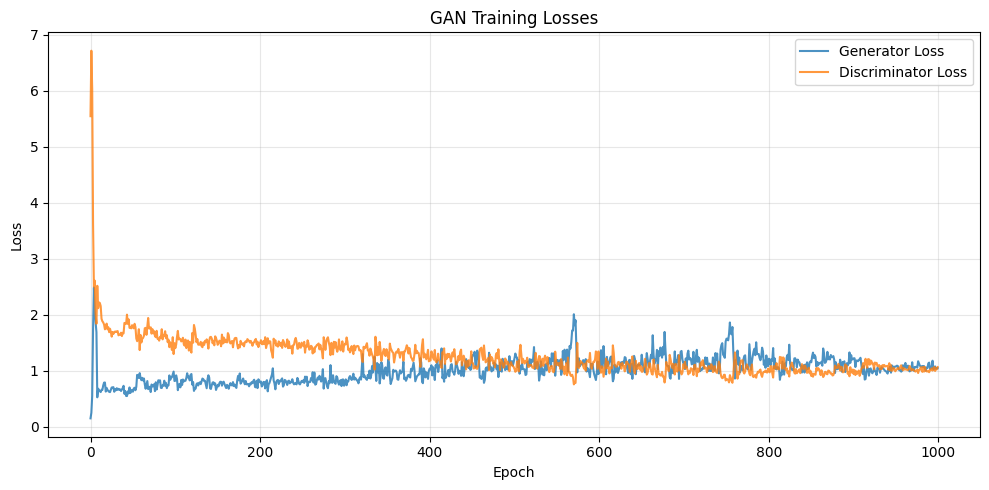

In [210]:
plt.figure(figsize=(10, 5))
plt.plot(g_losses, label='Generator Loss', alpha=0.8)
plt.plot(d_losses, label='Discriminator Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAN Training Losses')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'figures', 'loss_curves.png'), dpi=300, bbox_inches='tight')
plt.show()

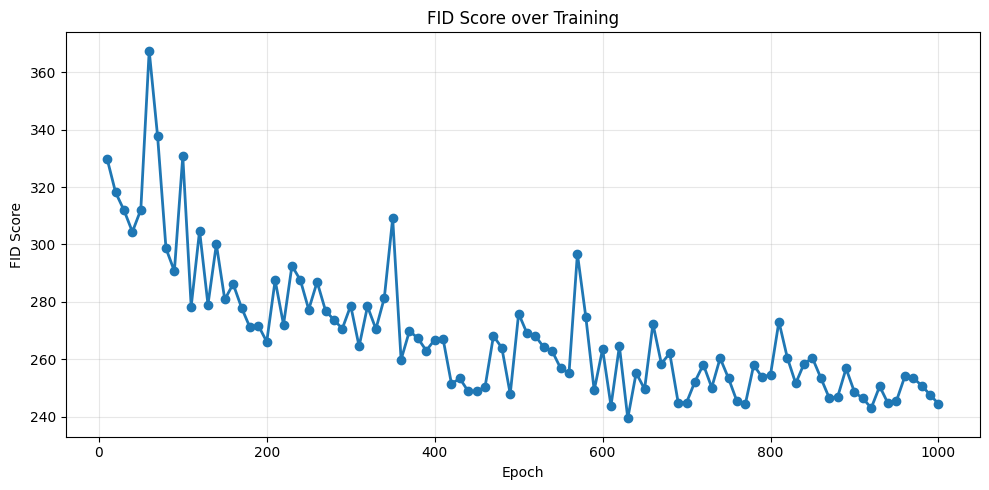

Best FID: 239.41 at epoch 630


In [211]:
plt.figure(figsize=(10, 5))
plt.plot(range(10, NUM_EPOCHS+1, 10), fid_scores, marker='o', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('FID Score')
plt.title('FID Score over Training')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'figures', 'fid_curve.png'), dpi=300, bbox_inches='tight')
plt.show()

print(f'Best FID: {min(fid_scores):.2f} at epoch {(fid_scores.index(min(fid_scores)) + 1) * 10}')

## 5. Part 3: Model Evaluation

### 5.1 (i) Qualitative Evaluation

#### Select 5 Distinct Attribute Combinations


=== Attribute Vector Analysis ===

Black_footed_Albatross:
  Non-zero attributes: 27/64
  Mean value: 0.0865
  Max value: 1.0000
  Sum: 27.00

Red_faced_Cormorant:
  Non-zero attributes: 9/64
  Mean value: 0.0288
  Max value: 1.0000
  Sum: 9.00

Bobolink:
  Non-zero attributes: 42/64
  Mean value: 0.1346
  Max value: 1.0000
  Sum: 42.00

Lazuli_Bunting:
  Non-zero attributes: 19/64
  Mean value: 0.0609
  Max value: 1.0000
  Sum: 19.00

Yellow_breasted_Chat:
  Non-zero attributes: 37/64
  Mean value: 0.1186
  Max value: 1.0000
  Sum: 37.00

=== Cross-class Similarity ===
Black_footed_Al vs Red_faced_Cormo: 0.1925
Black_footed_Al vs Bobolink: 0.1485
Black_footed_Al vs Lazuli_Bunting: 0.1766
Black_footed_Al vs Yellow_breasted: 0.3480
Red_faced_Cormo vs Bobolink: 0.2572
Red_faced_Cormo vs Lazuli_Bunting: 0.0000
Red_faced_Cormo vs Yellow_breasted: 0.0548
Bobolink vs Lazuli_Bunting: 0.2124
Bobolink vs Yellow_breasted: 0.2537
Lazuli_Bunting vs Yellow_breasted: 0.1886

=== Generator Input Che

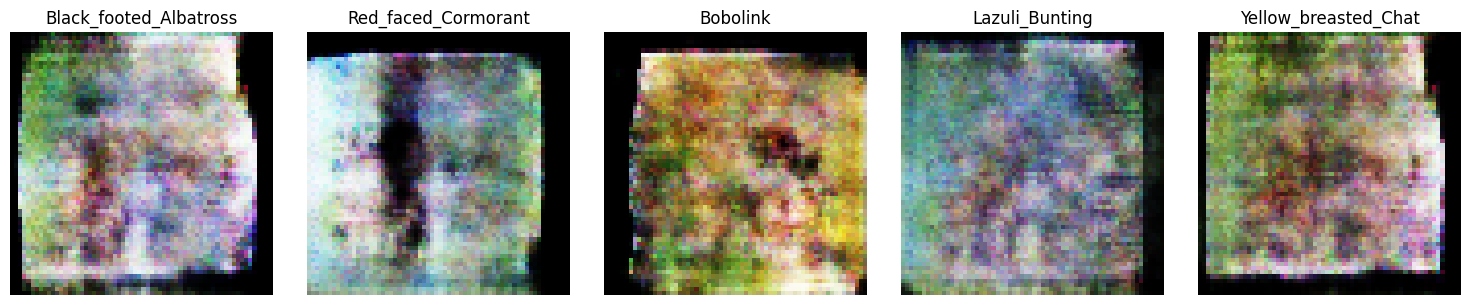

In [212]:
generator.eval()

selected_attrs = []
selected_labels = []
for class_idx in range(5):
    class_df = train_df[train_df['label'] == class_idx]
    sample_img_id = class_df.sample(1).iloc[0]['image_id']
    selected_attrs.append(train_attributes[sample_img_id])
    selected_labels.append(class_idx)

print('\n=== Attribute Vector Analysis ===')
for class_idx in range(5):
    attr = selected_attrs[class_idx]
    print(f'\n{TARGET_CLASSES[class_idx]}:')
    print(f'  Non-zero attributes: {(attr > 0).sum()}/64')
    print(f'  Mean value: {attr.mean():.4f}')
    print(f'  Max value: {attr.max():.4f}')
    print(f'  Sum: {attr.sum():.2f}')

attrs_array = np.array(selected_attrs)
print(f'\n=== Cross-class Similarity ===')
for i in range(5):
    for j in range(i+1, 5):
        similarity = np.dot(attrs_array[i], attrs_array[j]) / (np.linalg.norm(attrs_array[i]) * np.linalg.norm(attrs_array[j]))
        print(f'{TARGET_CLASSES[i][:15]} vs {TARGET_CLASSES[j][:15]}: {similarity:.4f}')

selected_attrs = torch.FloatTensor(np.array(selected_attrs)).to(device)

with torch.no_grad():
    noise = torch.randn(5, LATENT_DIM, device=device)

    print(f'\n=== Generator Input Check ===')
    print(f'Noise shape: {noise.shape}')
    print(f'Attributes shape: {selected_attrs.shape}')

    generated_samples = generator(noise, selected_attrs)

    print(f'Generated images shape: {generated_samples.shape}')
    print(f'Output value range: [{generated_samples.min():.3f}, {generated_samples.max():.3f}]')

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = generated_samples[i].cpu().permute(1, 2, 0).numpy()
    img = (img + 1) / 2
    img = np.clip(img, 0, 1)
    axes[i].imshow(img)
    axes[i].set_title(TARGET_CLASSES[selected_labels[i]])
    axes[i].axis('off')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'generated_samples', 'qualitative_samples.png'), dpi=300, bbox_inches='tight')
plt.show()

### 5.2 (ii) Quantitative Evaluation with Assignment 1 Classifier

#### Load Assignment 1 CNN Model

In [213]:
class BirdCNN(nn.Module):
    def __init__(self, num_classes=5):
        super(BirdCNN, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, 3, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.block3 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.block4 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.block5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )

        self.classifier = nn.Sequential(
            nn.Linear(256 * 7 * 7, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

classifier = BirdCNN(num_classes=5).to(device)
checkpoint = torch.load(os.path.join(MODEL_DIR, 'best_bird_cnn.pt'), map_location=device)
classifier.load_state_dict(checkpoint['model_state_dict'])
classifier.eval()
print('Assignment 1 classifier loaded successfully!')

Assignment 1 classifier loaded successfully!


#### Generate 50 Synthetic Images (10 per class)

In [214]:
generator.eval()

synthetic_images = []
synthetic_labels = []

for class_idx in range(5):
    class_df = train_df[train_df['label'] == class_idx]
    sampled_imgs = class_df.sample(min(30, len(class_df)))

    class_dir = os.path.join(OUTPUT_DIR, 'evaluation_images', f'class_{class_idx}')
    os.makedirs(class_dir, exist_ok=True)

    for i, (_, row) in enumerate(sampled_imgs.iterrows()):
        attr_vector = torch.FloatTensor(train_attributes[row['image_id']]).unsqueeze(0).to(device)

        with torch.no_grad():
            noise = torch.randn(1, LATENT_DIM, device=device)
            fake_img = generator(noise, attr_vector)

        save_image(
            fake_img,
            os.path.join(class_dir, f'img_{i}.png'),
            normalize=True
        )

        synthetic_images.append(fake_img)
        synthetic_labels.append(class_idx)

print(f'Generated {len(synthetic_images)} synthetic images')

Generated 150 synthetic images


#### Classify Synthetic Images

In [215]:
true_labels = synthetic_labels

predictions = []
classifier.eval()

with torch.no_grad():
    for img in synthetic_images:
        img = (img + 1) / 2
        img = torch.clamp(img, 0, 1)

        img_224 = transforms.functional.resize(img, (224, 224))

        mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)
        img_224 = (img_224 - mean) / std

        output = classifier(img_224)
        pred = output.argmax(dim=1).item()
        predictions.append(pred)

predictions = np.array(predictions)
true_labels = np.array(synthetic_labels)

accuracy = (predictions == true_labels).mean()
print(f'Classification Accuracy on Generated Images: {accuracy:.4f}')

Classification Accuracy on Generated Images: 0.3667


#### Confusion Matrix

<Figure size 1000x800 with 0 Axes>

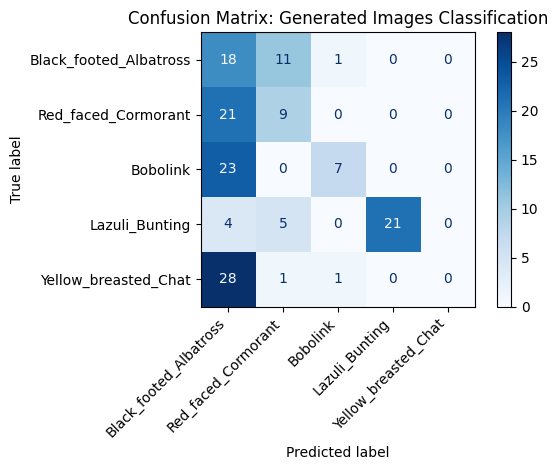

In [216]:
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=TARGET_CLASSES)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix: Generated Images Classification')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

#### Classification Report

In [217]:
report = classification_report(true_labels, predictions, target_names=TARGET_CLASSES, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)

                        precision    recall  f1-score     support
Black_footed_Albatross   0.191489  0.600000  0.290323   30.000000
Red_faced_Cormorant      0.346154  0.300000  0.321429   30.000000
Bobolink                 0.777778  0.233333  0.358974   30.000000
Lazuli_Bunting           1.000000  0.700000  0.823529   30.000000
Yellow_breasted_Chat     0.000000  0.000000  0.000000   30.000000
accuracy                 0.366667  0.366667  0.366667    0.366667
macro avg                0.463084  0.366667  0.358851  150.000000
weighted avg             0.463084  0.366667  0.358851  150.000000


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
